## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
import seaborn as sn
import os

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

## Plot general

In [2]:
EXPERIMENT_NAME = "Final_Classification"
figure_title = "Classificação - SCM"
datasets_name_list = ['SCM_Acceleration_Classification', 'SCM_Gyroscope_Classification', 'SCM_All_Signals_Classification']
classifiers_name_list = ['Naive_Bayes','MLP','Nearest_Neighbors','Random_Forest','SVM_Linear','SVM_Polynomial','SVM_RBF']
metrics_name_list = ['accuracy','precision','sensitivity','specificity','f1_score','fit_time','predict_time']

labels_radar = ('AcX/AcY/AcZ', 'GyX/GyY/GyZ', 'AcX/AcY/AcZ/GyX/GyY/GyZ')

validation_set = False
cmx_plot = True

In [3]:
srcpath = path.join("..","results","classification",EXPERIMENT_NAME)
outpath = path.join(srcpath, "Train")

if validation_set:
    val_outpath = path.join(srcpath, "Validation")

## Functions

In [4]:
def autolabel(rects, ax): # Attach a text label above each bar in *rects*, displaying its height
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [5]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=8)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

### Results of train bar plot

In [6]:
fig, ax = plt.subplots(figsize=(16, 10), nrows=len(datasets_name_list), ncols=1, dpi=300)

for row, dataset in enumerate(datasets_name_list):
    plot_csv = pd.read_csv(path.join(outpath, dataset,"evaluation_metrics.csv"), sep=',', index_col=0)
    plot_csv.drop(columns=['fit_time_mean','fit_time_std','predict_time_mean',
                           'predict_time_std'], inplace=True) # Exclude time columns
    
    lines = list(range(len(plot_csv)))
#     lines = [0,1,4,5,6] 

    x_pos = np.arange(len(lines))
    x_pos = np.arange(1, 2*len(lines)+1, 2)
    materials = classifiers_name_list
    n_classifiers = len(classifiers_name_list)

    width = 0.29
    factor = 0.3
    
    metrics_names = ['accuracy','precision','sensitivity','specificity','f1_score']
    means = []
    stds = []
    for metric in metrics_names:
        x_mean = plot_csv.columns.get_loc(metric+"_mean")
        x_std = plot_csv.columns.get_loc(metric+"_std")
        means.append(x_mean)
        stds.append(x_std)

    CTEs = []
    errors = []

    # Metrics
    for i in range(len(metrics_name_list)-2):
        CTE = [plot_csv.iloc[lines[j],means[i]] for j in range(n_classifiers)]
        error = [plot_csv.iloc[lines[j],stds[i]] for j in range(n_classifiers)]

        CTEs.append(CTE)
        errors.append(error)


    r1 = ax[row].bar(x_pos - width - factor, CTEs[0], yerr=errors[0], width=width,align='center', alpha=0.5, ecolor='black', capsize=1, label='Acurácia')
    r2 = ax[row].bar(x_pos - factor , CTEs[1], yerr=0, width=width,align='center', alpha=0.5, ecolor='black', capsize=3, label='Precisão')
    r3 = ax[row].bar(x_pos + width - factor,CTEs[2],yerr=errors[2],width=width,align='center',alpha=0.5,ecolor='black',capsize=3,label='Sensitividade')
    r4 = ax[row].bar(x_pos + 2*width - factor,CTEs[3],yerr=errors[3],width=width,align='center',alpha=0.5,ecolor='black',capsize=3,label='Especificidade')
    r5 = ax[row].bar(x_pos + 3*width - factor, CTEs[4], yerr=errors[4], width=width,align='center', alpha=0.5, ecolor='black',capsize=3, label='F1-Score')


    ax[row].set_ylabel('%')
    ax[row].set_yticks(np.arange(0,1.2,0.1))
    ax[row].set_yticklabels([0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0, ""])
    ax[row].set_xticks(x_pos)
    ax[row].set_xticklabels(materials)
    ax[row].set_title(dataset, fontsize=16, fontweight='bold')
    ax[row].yaxis.grid(True)
    if row == 0:
        ax[row].legend(fontsize=10)
    
    autolabel(r1, ax[row])
    autolabel(r2, ax[row])
    autolabel(r3, ax[row])
    autolabel(r4, ax[row])
    autolabel(r5, ax[row])

# Save the figure and show
plt.tight_layout()
# fig.suptitle(figure_title, fontsize=28, fontweight='bold')
fig.savefig(path.join(outpath,'evaluation_bar_plot.png'))
fig.clear()

<Figure size 4800x3000 with 0 Axes>

### Results of validation bar plot

In [7]:
if validation_set:
    fig, ax = plt.subplots(figsize=(15, 9), nrows=len(datasets_name_list), ncols=1, dpi=600)

    for row, dataset in enumerate(datasets_name_list):
        plot_csv = pd.read_csv(path.join(val_outpath, dataset,"evaluation_metrics.csv"), sep=',', index_col=0)
        plot_csv.drop(columns=['fit_time','predict_time'], inplace=True) # Exclude time columns

        lines = list(range(len(plot_csv)))
    #     lines = [0,1,4,5,6] 

        x_pos = np.arange(len(lines))
        x_pos = np.arange(1, 2*len(lines)+1, 2)
        materials = classifiers_name_list
        n_classifiers = len(classifiers_name_list)

        width = 0.28
        factor = 0.3

        metrics_names = ['accuracy','balanced_accuracy','precision','sensitivity','specificity','f1_score']
        means = []
        for metric in metrics_names:
            x_mean = plot_csv.columns.get_loc(metric)
            means.append(x_mean)

        CTEs = []

        # Metrics
        for i in range(len(metrics_name_list)-2):
            CTE = [plot_csv.iloc[lines[j], means[i]] for j in range(n_classifiers)]
            CTEs.append(CTE)

        r1 = ax[row].bar(x_pos - width - factor, CTEs[0], yerr=0, width=width,align='center', alpha=0.5, ecolor='black', capsize=3, label='Acurácia')
        r2 = ax[row].bar(x_pos - factor , CTEs[1], yerr=0, width=width,align='center', alpha=0.5, ecolor='black', capsize=3, label='Acurácia Balanceada')
        r3 = ax[row].bar(x_pos + width - factor, CTEs[2], yerr=0, width=width,align='center', alpha=0.5, ecolor='black', capsize=3, label='Precisão')
        r4 = ax[row].bar(x_pos + 2*width - factor, CTEs[3], yerr=0, width=width,align='center', alpha=0.5, ecolor='black', capsize=3, label='Sensitividade')
        r5 = ax[row].bar(x_pos + 3*width - factor, CTEs[4], yerr=0, width=width,align='center', alpha=0.5, ecolor='black', capsize=3, label='Especificidade')
        r6 = ax[row].bar(x_pos + 4*width - factor, CTEs[5], yerr=0, width=width,align='center', alpha=0.5, ecolor='black', capsize=3, label='F1-Score')

        ax[row].set_ylabel('%')
        ax[row].set_yticks(np.arange(0,1.2,0.1))
        ax[row].set_yticklabels([0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0, ""])
        ax[row].set_xticks(x_pos)
        ax[row].set_xticklabels(materials)
        ax[row].set_title(dataset, fontsize=16, fontweight='bold')
        ax[row].yaxis.grid(True)
        if row == 0:
            ax[row].legend(fontsize=10)

        autolabel(r1, ax[row])
        autolabel(r2, ax[row])
        autolabel(r3, ax[row])
        autolabel(r4, ax[row])
        autolabel(r5, ax[row])
        autolabel(r6, ax[row])

    # Save the figure and show
    plt.tight_layout()
    # fig.suptitle(figure_title, fontsize=28, fontweight='bold')
    fig.savefig(path.join(val_outpath,'evaluation_bar_plot.png'))
    fig.clear()

### Results of train radar plot

In [8]:
metrics_list = ['accuracy_mean','precision_mean','sensitivity_mean','specificity_mean','f1_score_mean']

mean_classifiers_list = []
for classifier in classifiers_name_list:
    mean_list = []
    for dataset in datasets_name_list:
        plot_csv = pd.read_csv(path.join(outpath, dataset,"evaluation_metrics.csv"), sep=',', index_col=0)
        plot_csv.drop(columns=['fit_time_mean','fit_time_std','predict_time_mean',
                               'predict_time_std'], inplace=True) # Exclude time columns
        ds_means = list(plot_csv.loc[classifier, metrics_list])
        mean_list.append(ds_means)
    mean_classifiers_list.append(mean_list)

N = 5 # metrics number
theta = radar_factory(N, frame='polygon')

spoke_labels = ['Acurácia','Precisão','Sensitividade','Especificidade','F1-Score']

fig, axes = plt.subplots(figsize=(24, 12), nrows=2, ncols=4, subplot_kw=dict(projection='radar'), dpi=300)   

colors = ['b', 'r', 'g', 'y']

i = 0
for row in range(2):
    for col in range(4):
        if row != 1 or col != 3:
            title = classifiers_name_list[i]
            case_data = mean_classifiers_list[i]

            axes[row,col].set_ylim(0, 1.1)
            axes[row,col].tick_params(axis='y',which='major',direction='out',length=4,width=4,color='b',
                                      pad=20,labelsize=10)
            axes[row,col].set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                             horizontalalignment='center', verticalalignment='center')


            for d, color in zip(case_data, colors):
                axes[row,col].plot(theta, d, color=color)
                axes[row,col].fill(theta, d, facecolor=color, alpha=0.10)

            axes[row,col].set_varlabels(spoke_labels)
            i += 1

fig.delaxes(axes[1,3])
fig.suptitle(figure_title, fontsize=25, fontweight='bold')
fig.legend(labels_radar, loc=(0.75, .2),labelspacing=0.1, fontsize=20, markerscale=3)
fig.savefig(path.join(outpath, 'evaluation_radar_plot.png'))
fig.clear()

<Figure size 7200x3600 with 0 Axes>

### Results of validation radar plot

In [9]:
if validation_set:
    metrics_list = ['accuracy','balanced_accuracy','precision','sensitivity','specificity','f1_score']

    mean_classifiers_list = []
    for classifier in classifiers_name_list:
        mean_list = []
        for dataset in datasets_name_list:
            plot_csv = pd.read_csv(path.join(val_outpath, dataset,"evaluation_metrics.csv"), sep=',', index_col=0)
            plot_csv.drop(columns=['fit_time','predict_time'], inplace=True) # Exclude time columns
            ds_means = list(plot_csv.loc[classifier, metrics_list])
            mean_list.append(ds_means)
        mean_classifiers_list.append(mean_list)

    N = 6 # metrics number
    theta = radar_factory(N, frame='polygon')

    spoke_labels = ['Acurácia','Acurácia Balanceada','Precisão','Sensitividade','Especificidade','F1-Score']

    fig, axes = plt.subplots(figsize=(24, 12), nrows=2, ncols=4, subplot_kw=dict(projection='radar'), dpi=300)   

    colors = ['b', 'r', 'g']

    i = 0
    for row in range(2):
        for col in range(4):
            if row != 1 or col != 3:
                title = classifiers_name_list[i]
                case_data = mean_classifiers_list[i]

                axes[row,col].set_ylim(0, 1.1)
                axes[row,col].tick_params(axis='y',which='major',direction='out',length=4,width=4,color='b',
                                          pad=20,labelsize=10)
                axes[row,col].set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                                 horizontalalignment='center', verticalalignment='center')


                for d, color in zip(case_data, colors):
                    axes[row,col].plot(theta, d, color=color)
                    axes[row,col].fill(theta, d, facecolor=color, alpha=0.10)

                axes[row,col].set_varlabels(spoke_labels)
                i += 1

    fig.delaxes(axes[1,3])
    fig.suptitle(figure_title, fontsize=25, fontweight='bold')
    fig.legend(labels_radar, loc=(0.82, .2),labelspacing=0.1, fontsize=20, markerscale=3)
    fig.savefig(path.join(val_outpath, 'evaluation_radar_plot.png'))
    fig.clear()

/home/matheus-a-s/.virtualenvs/.PumpsEnv/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


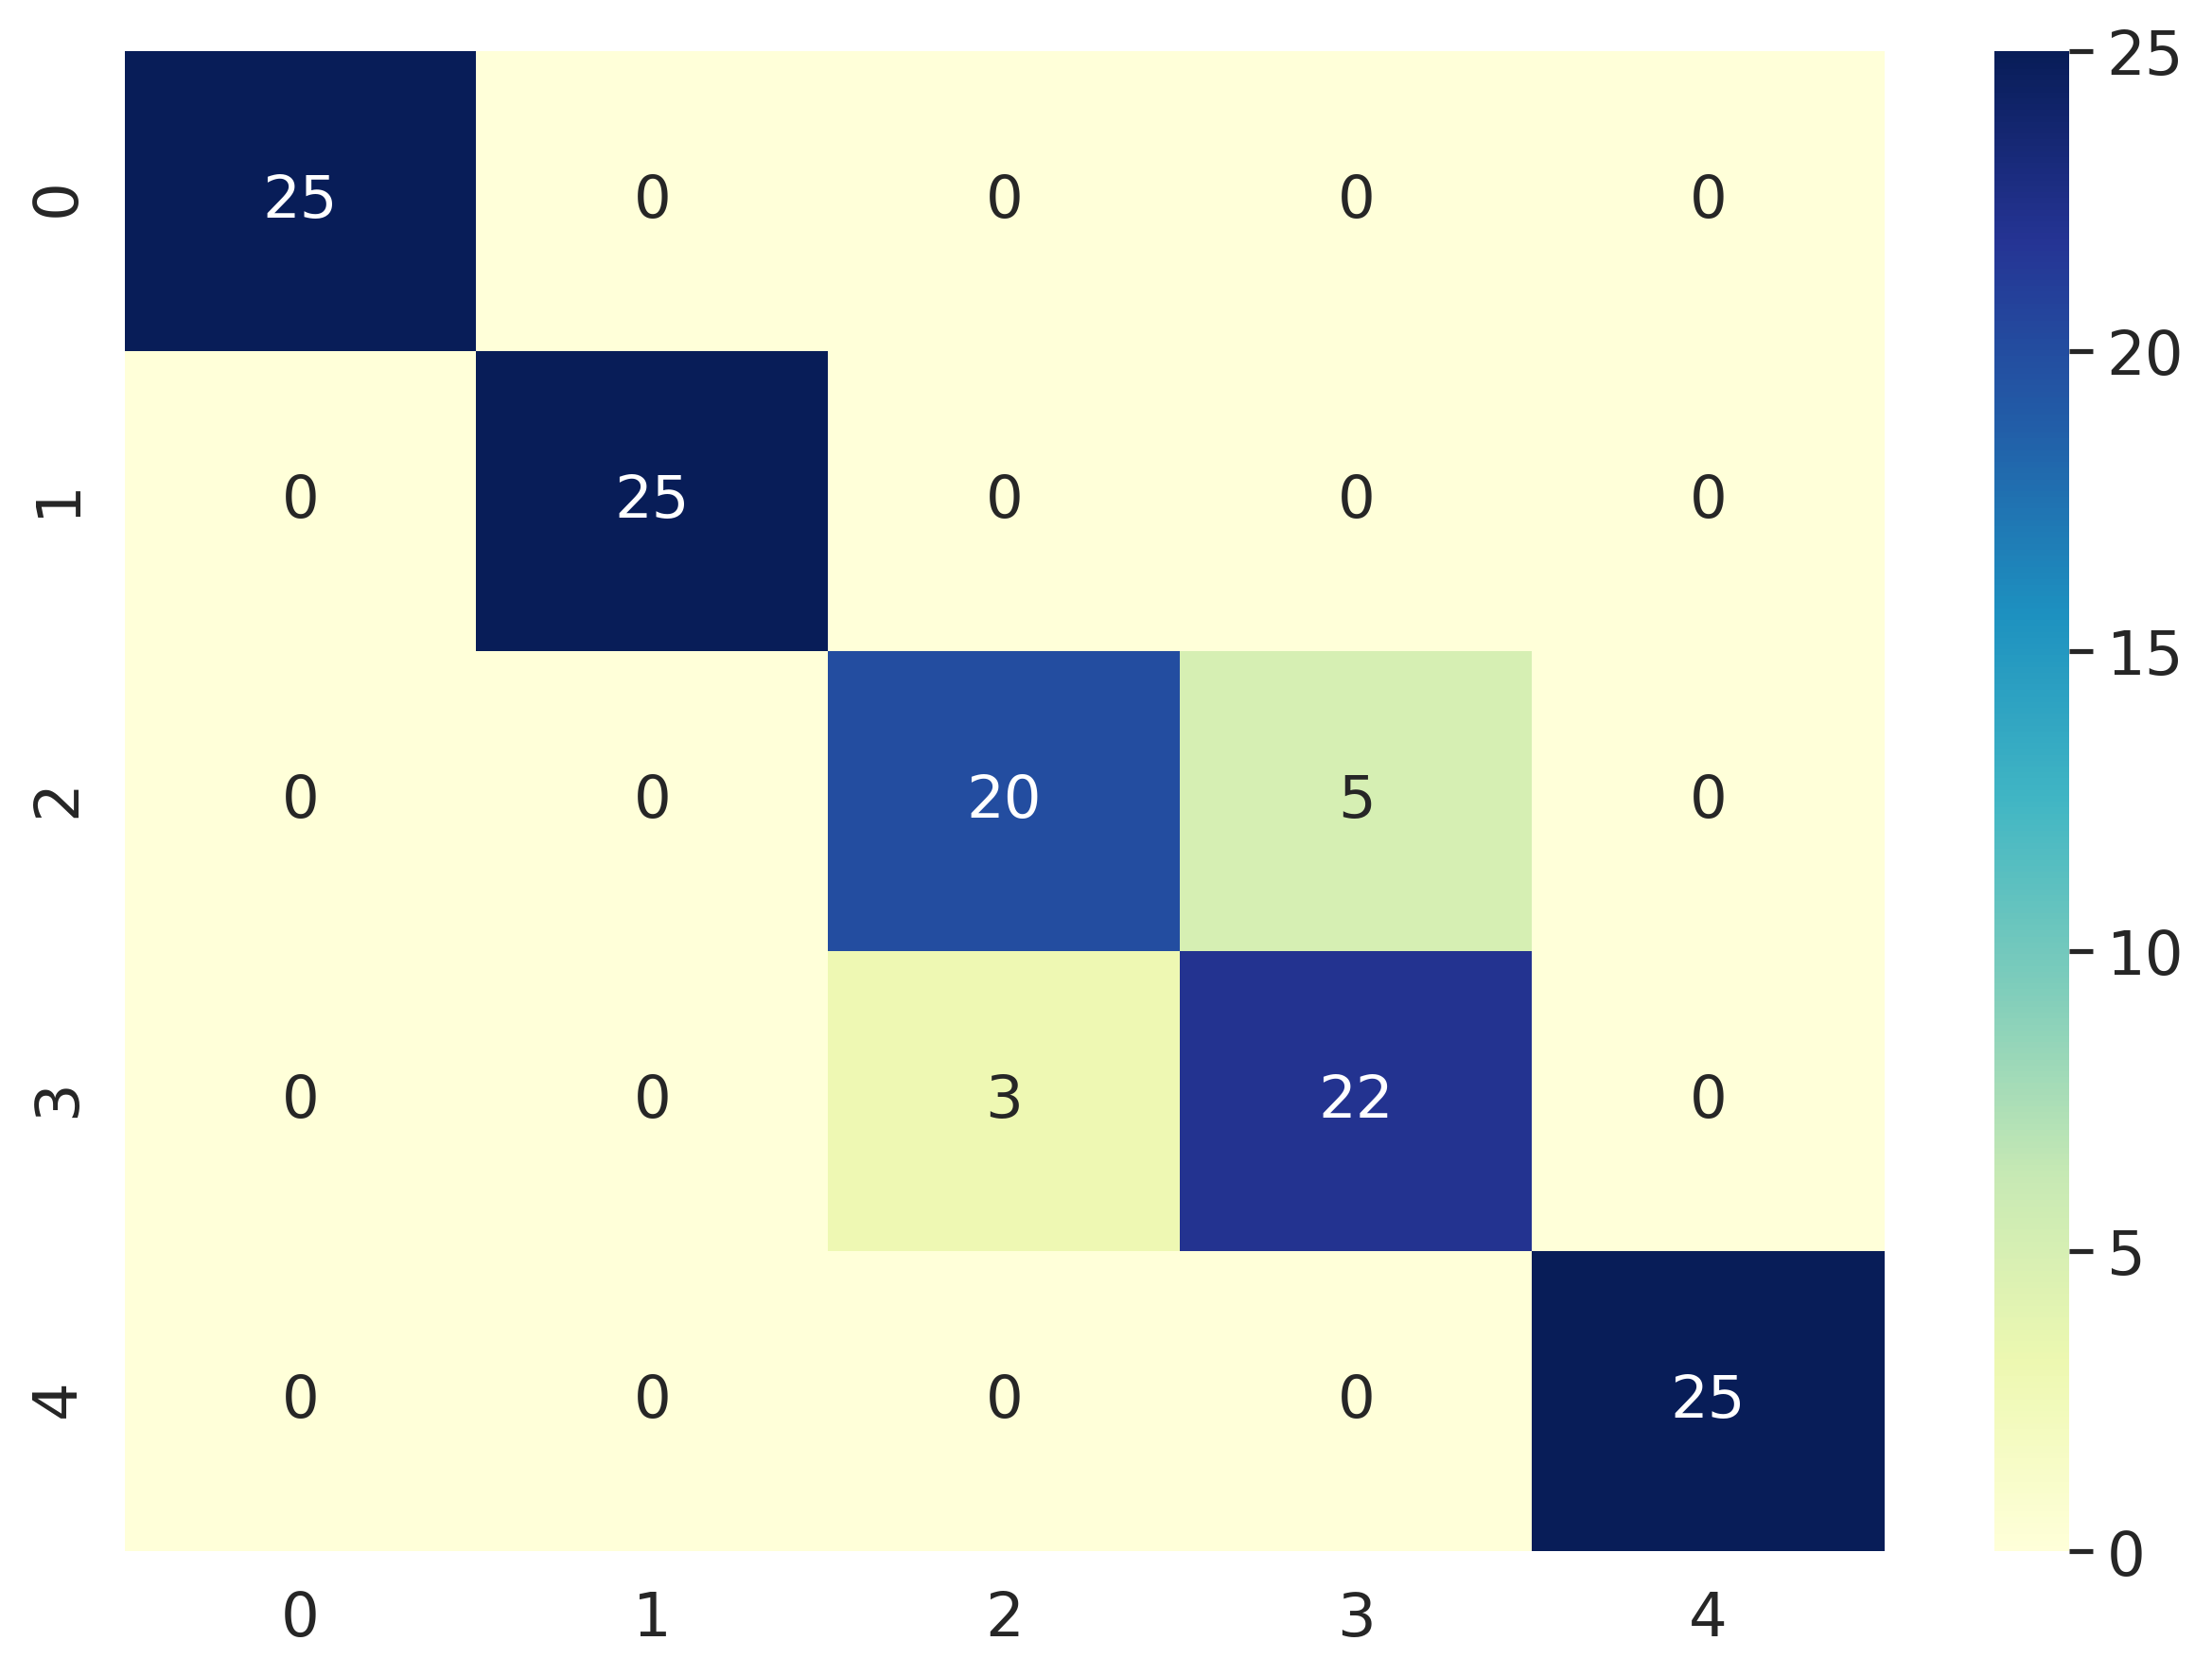

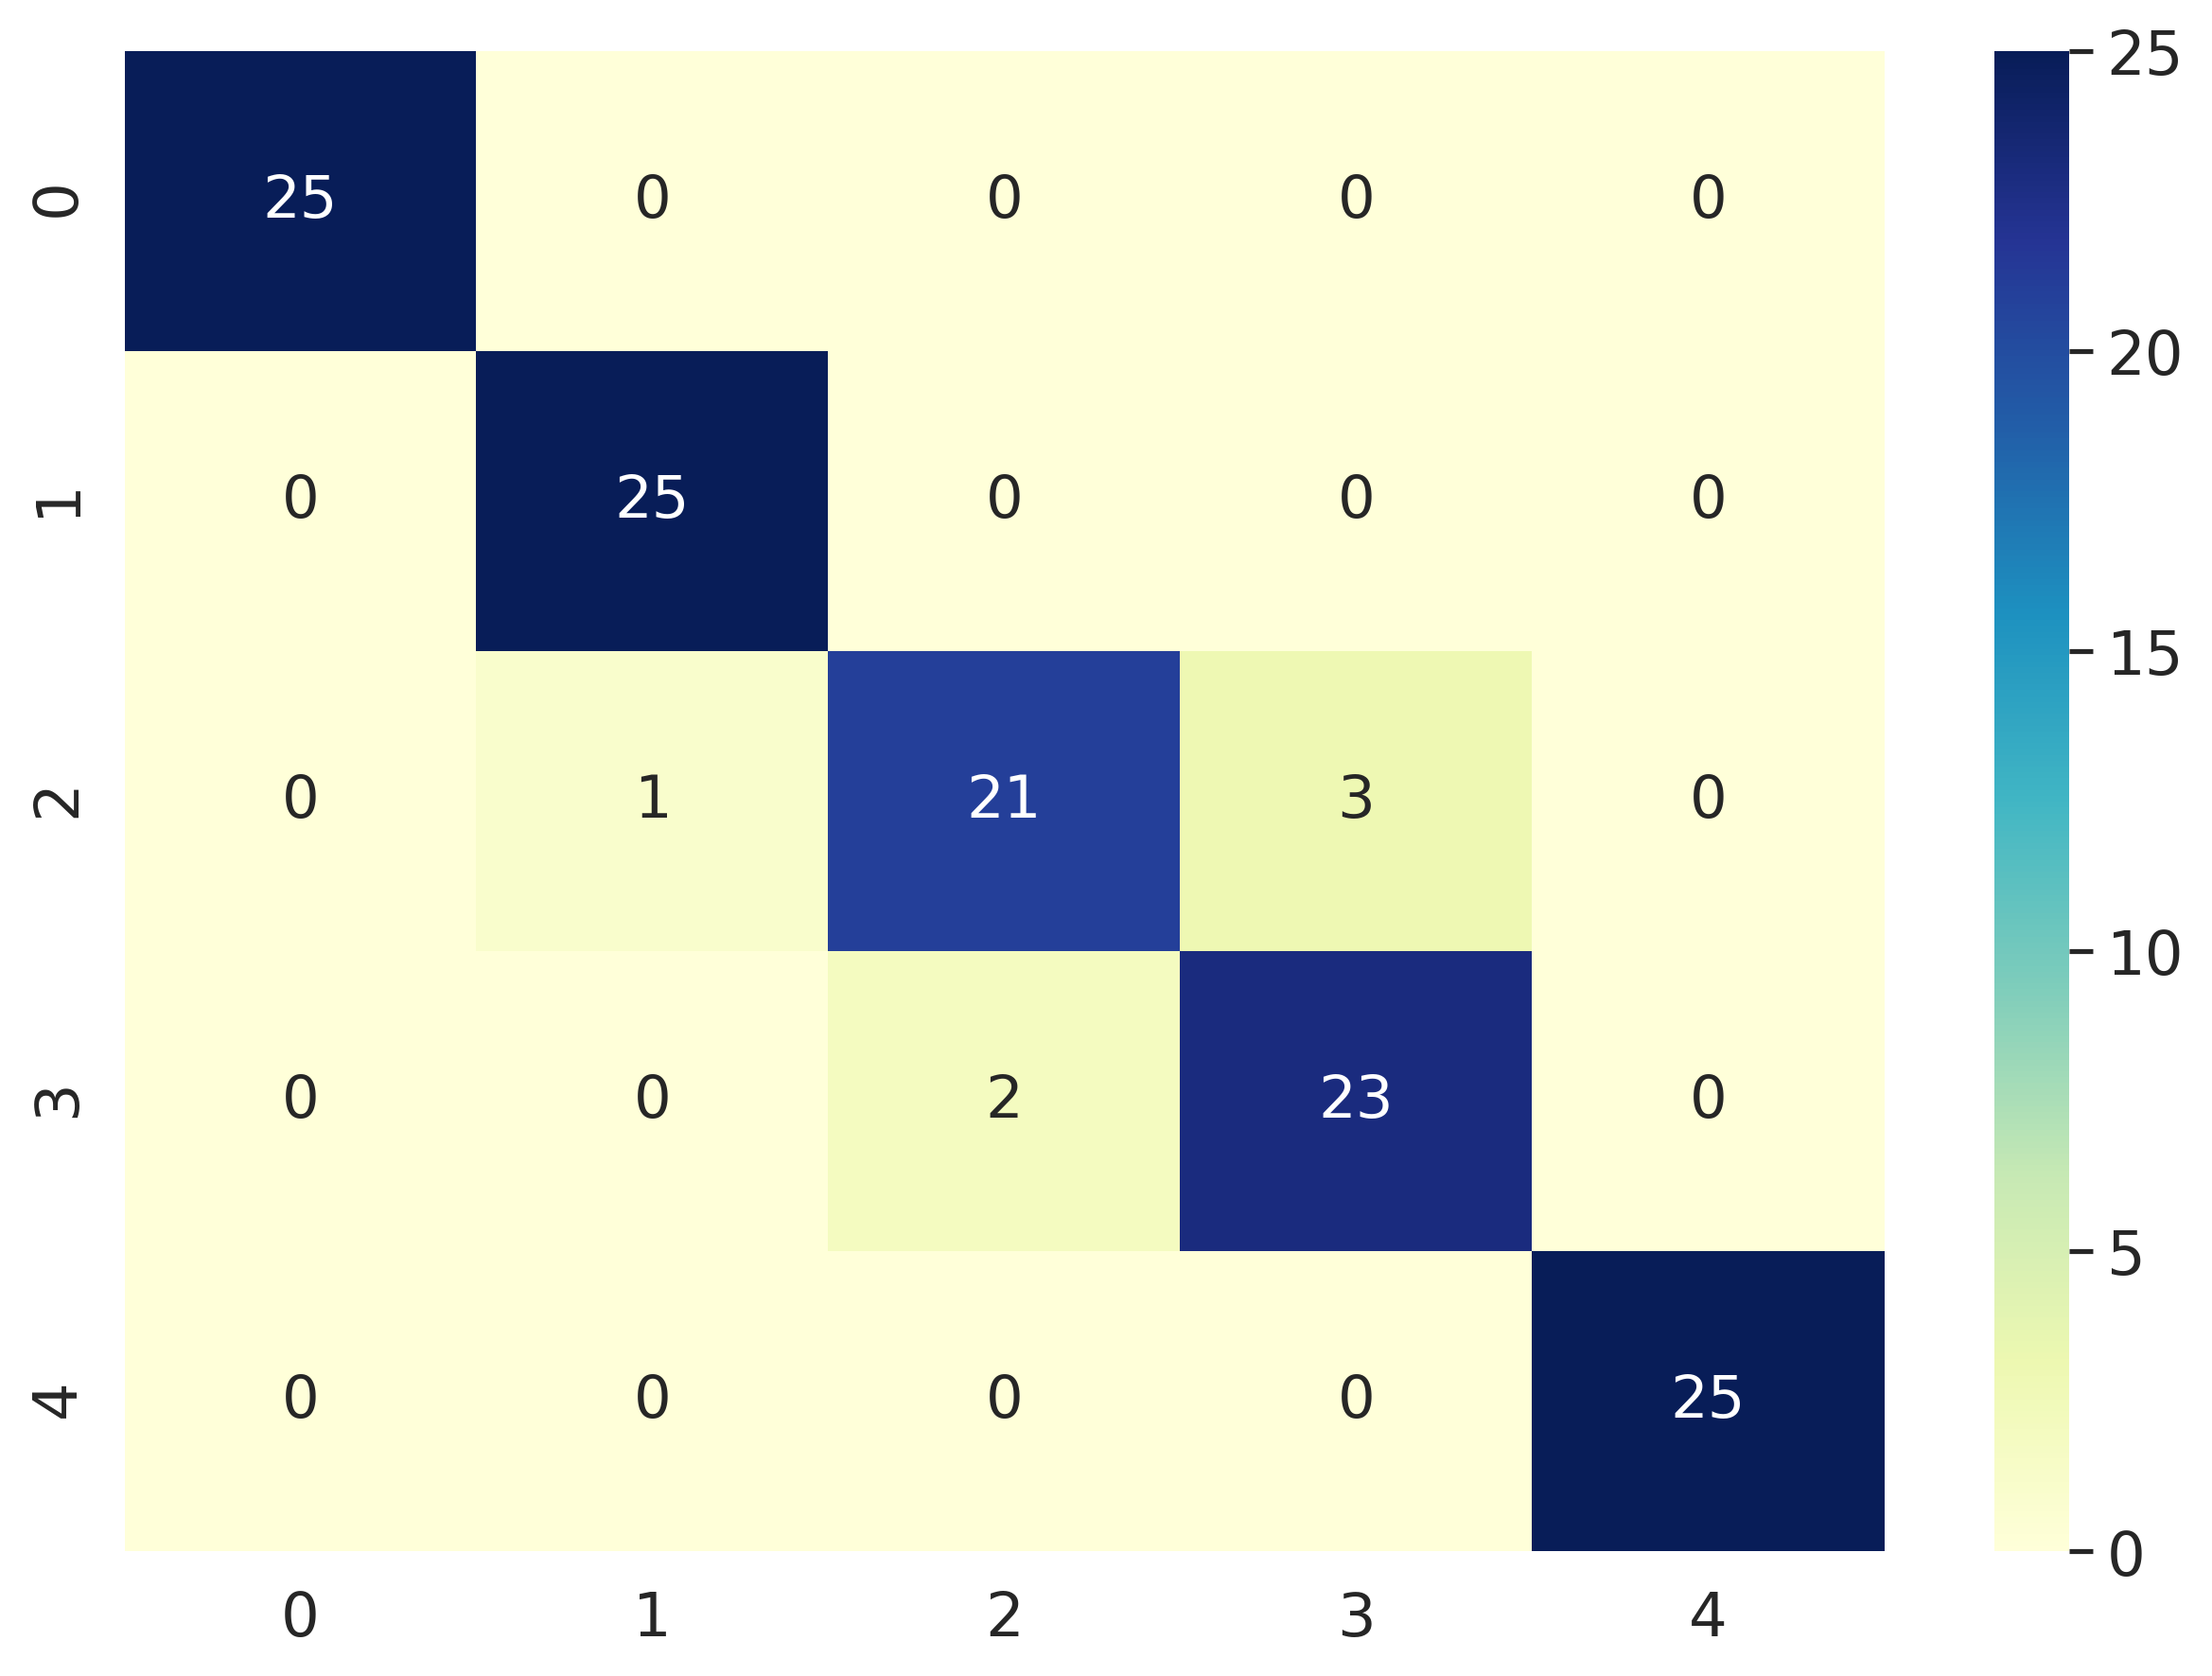

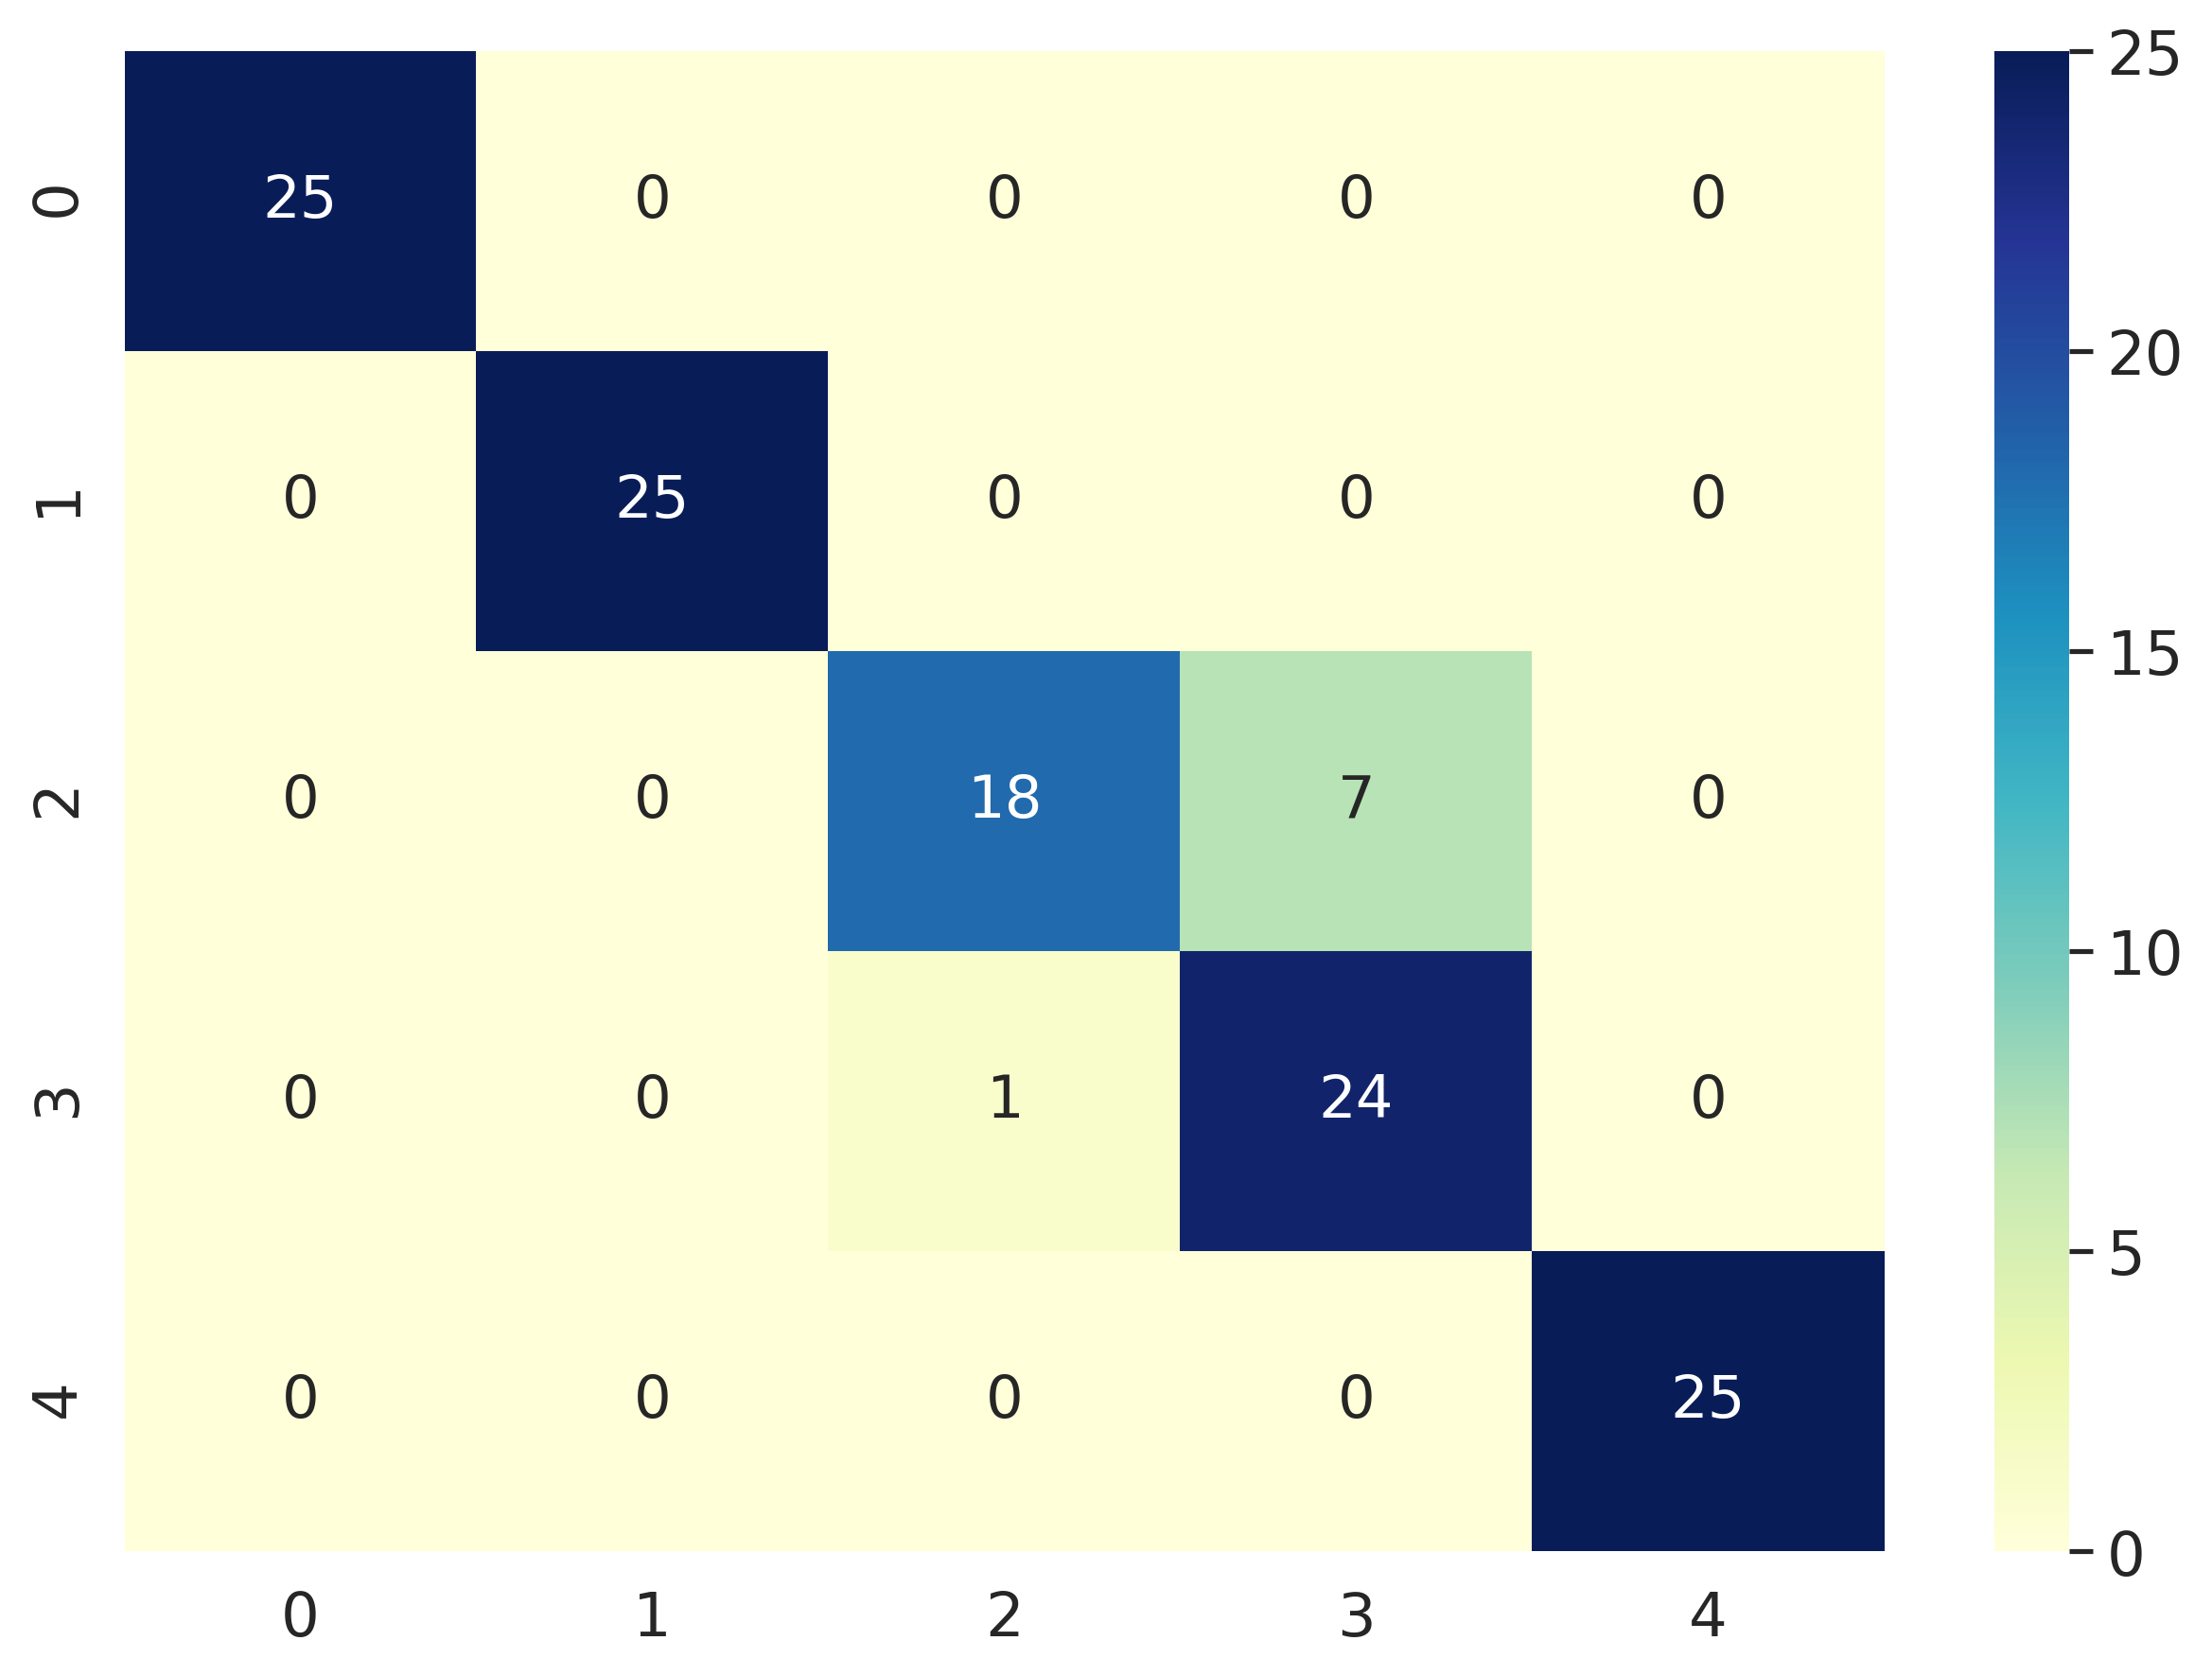

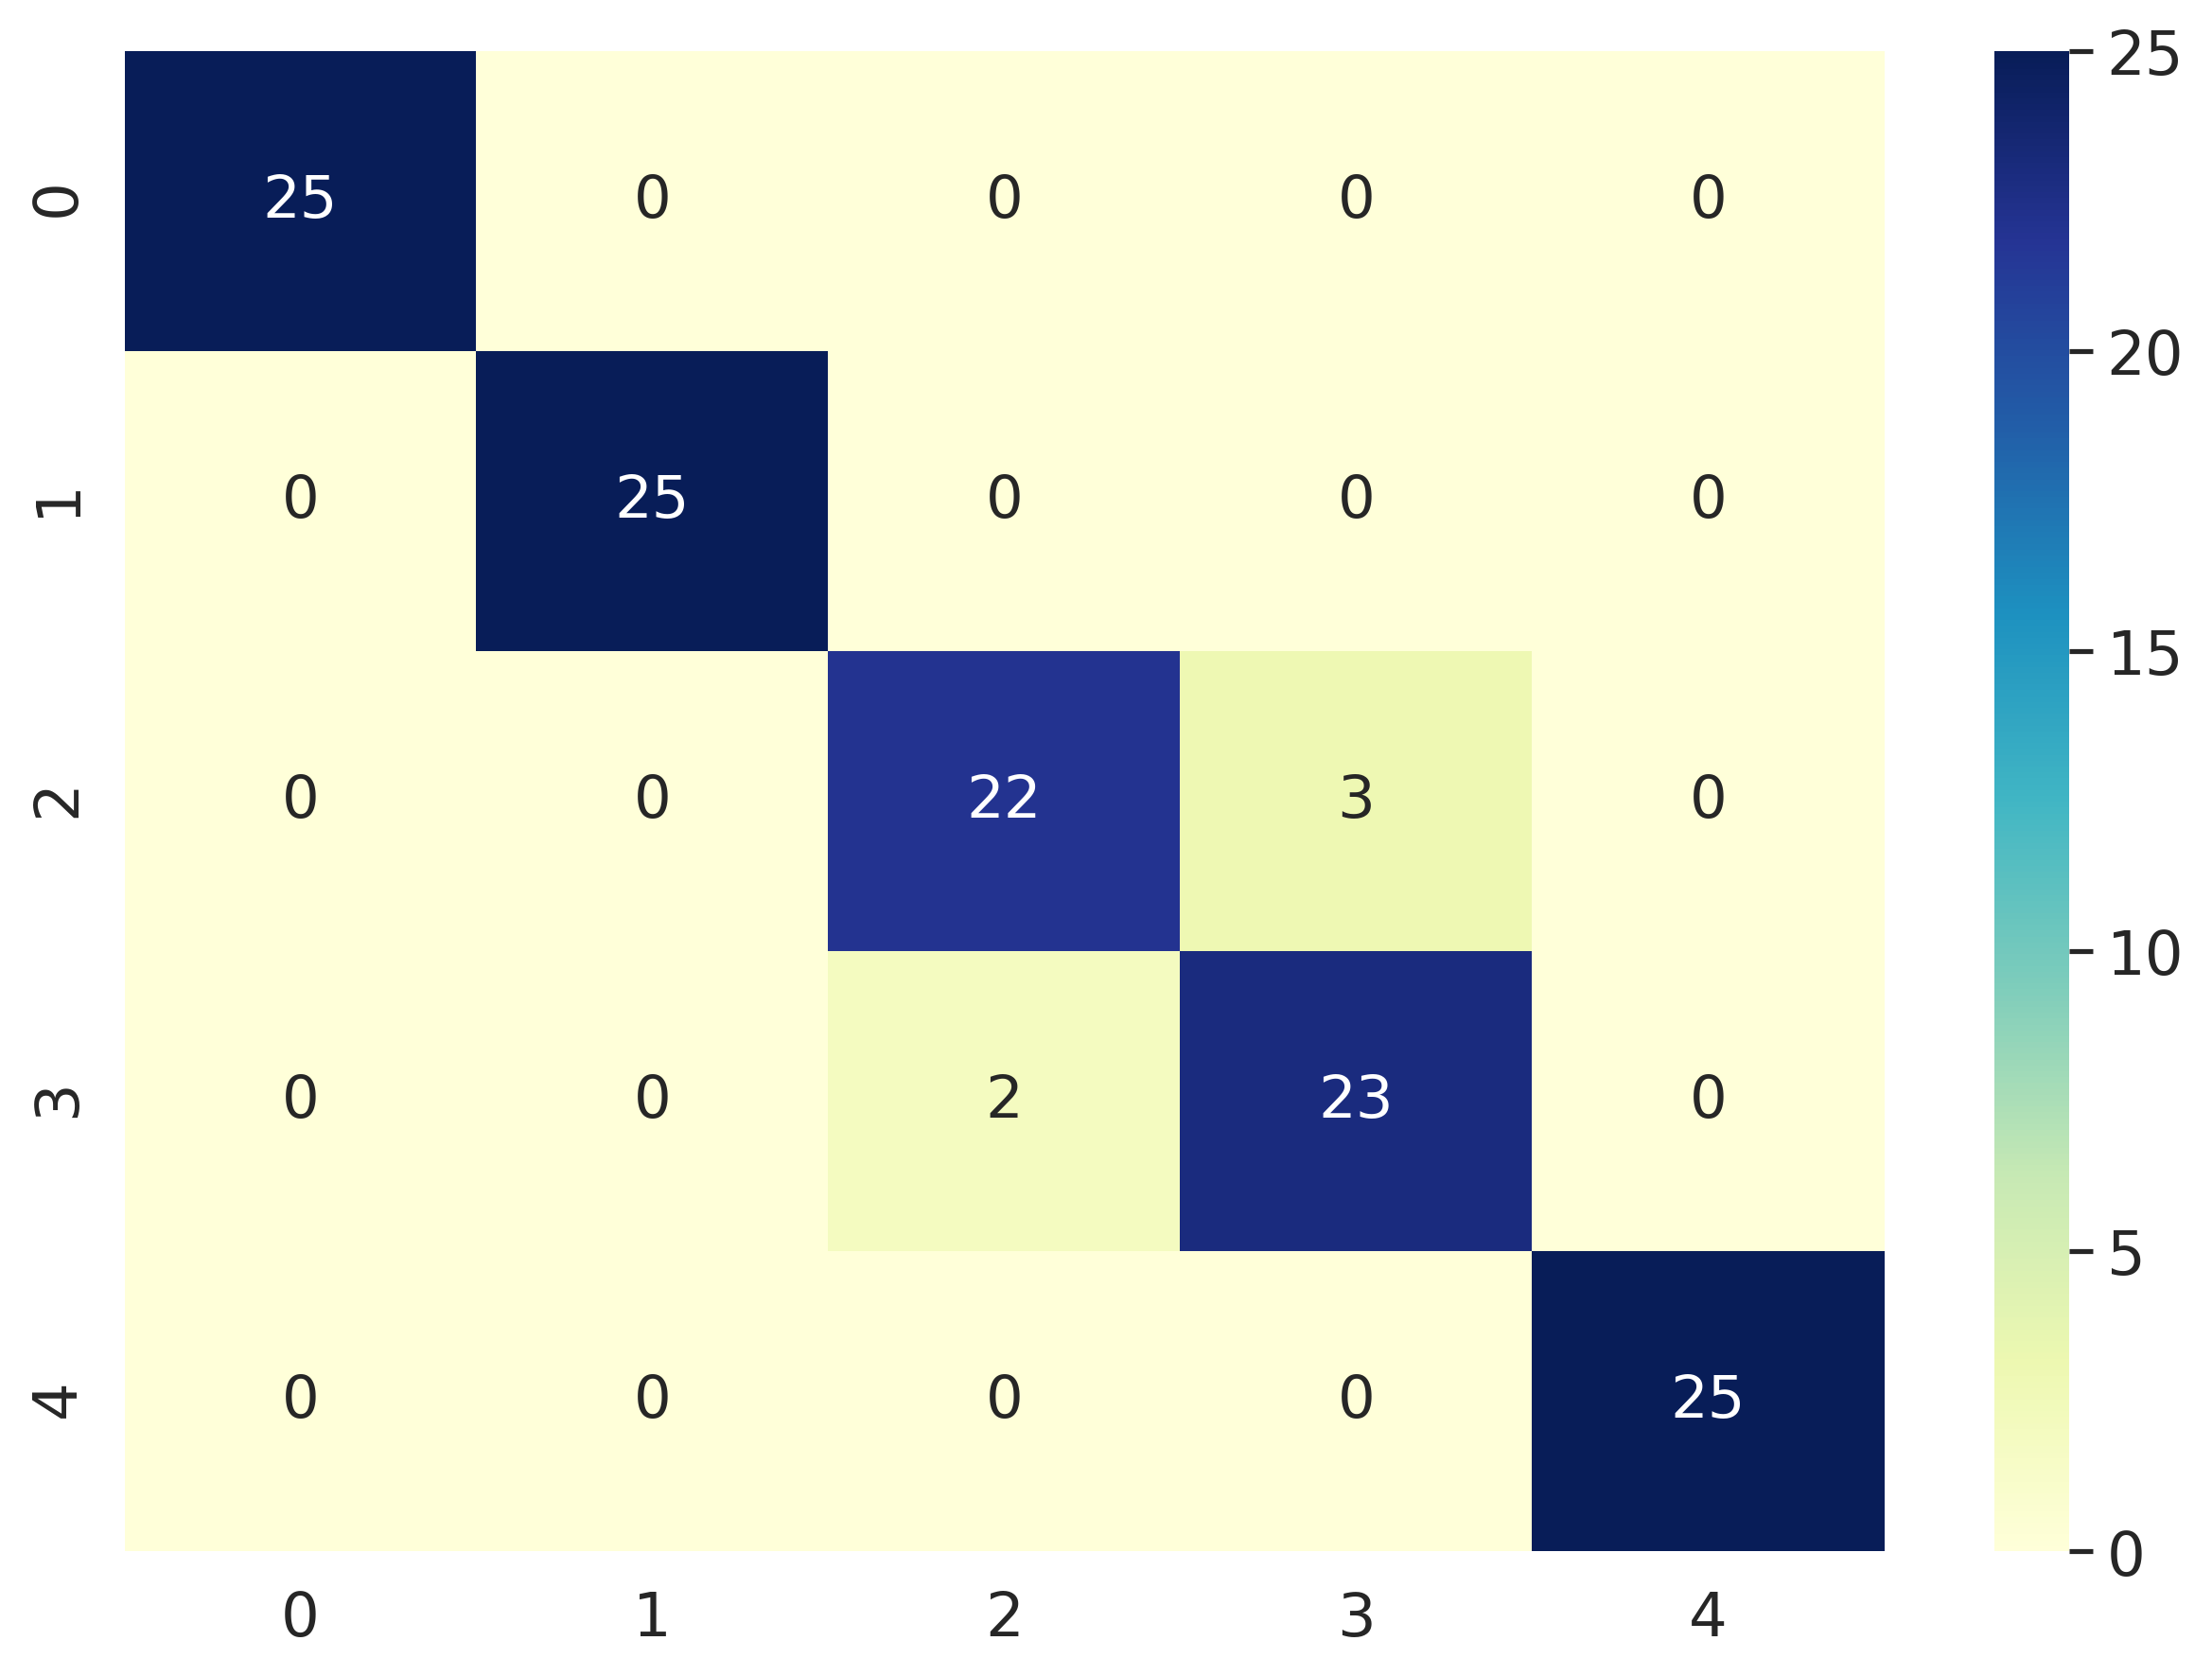

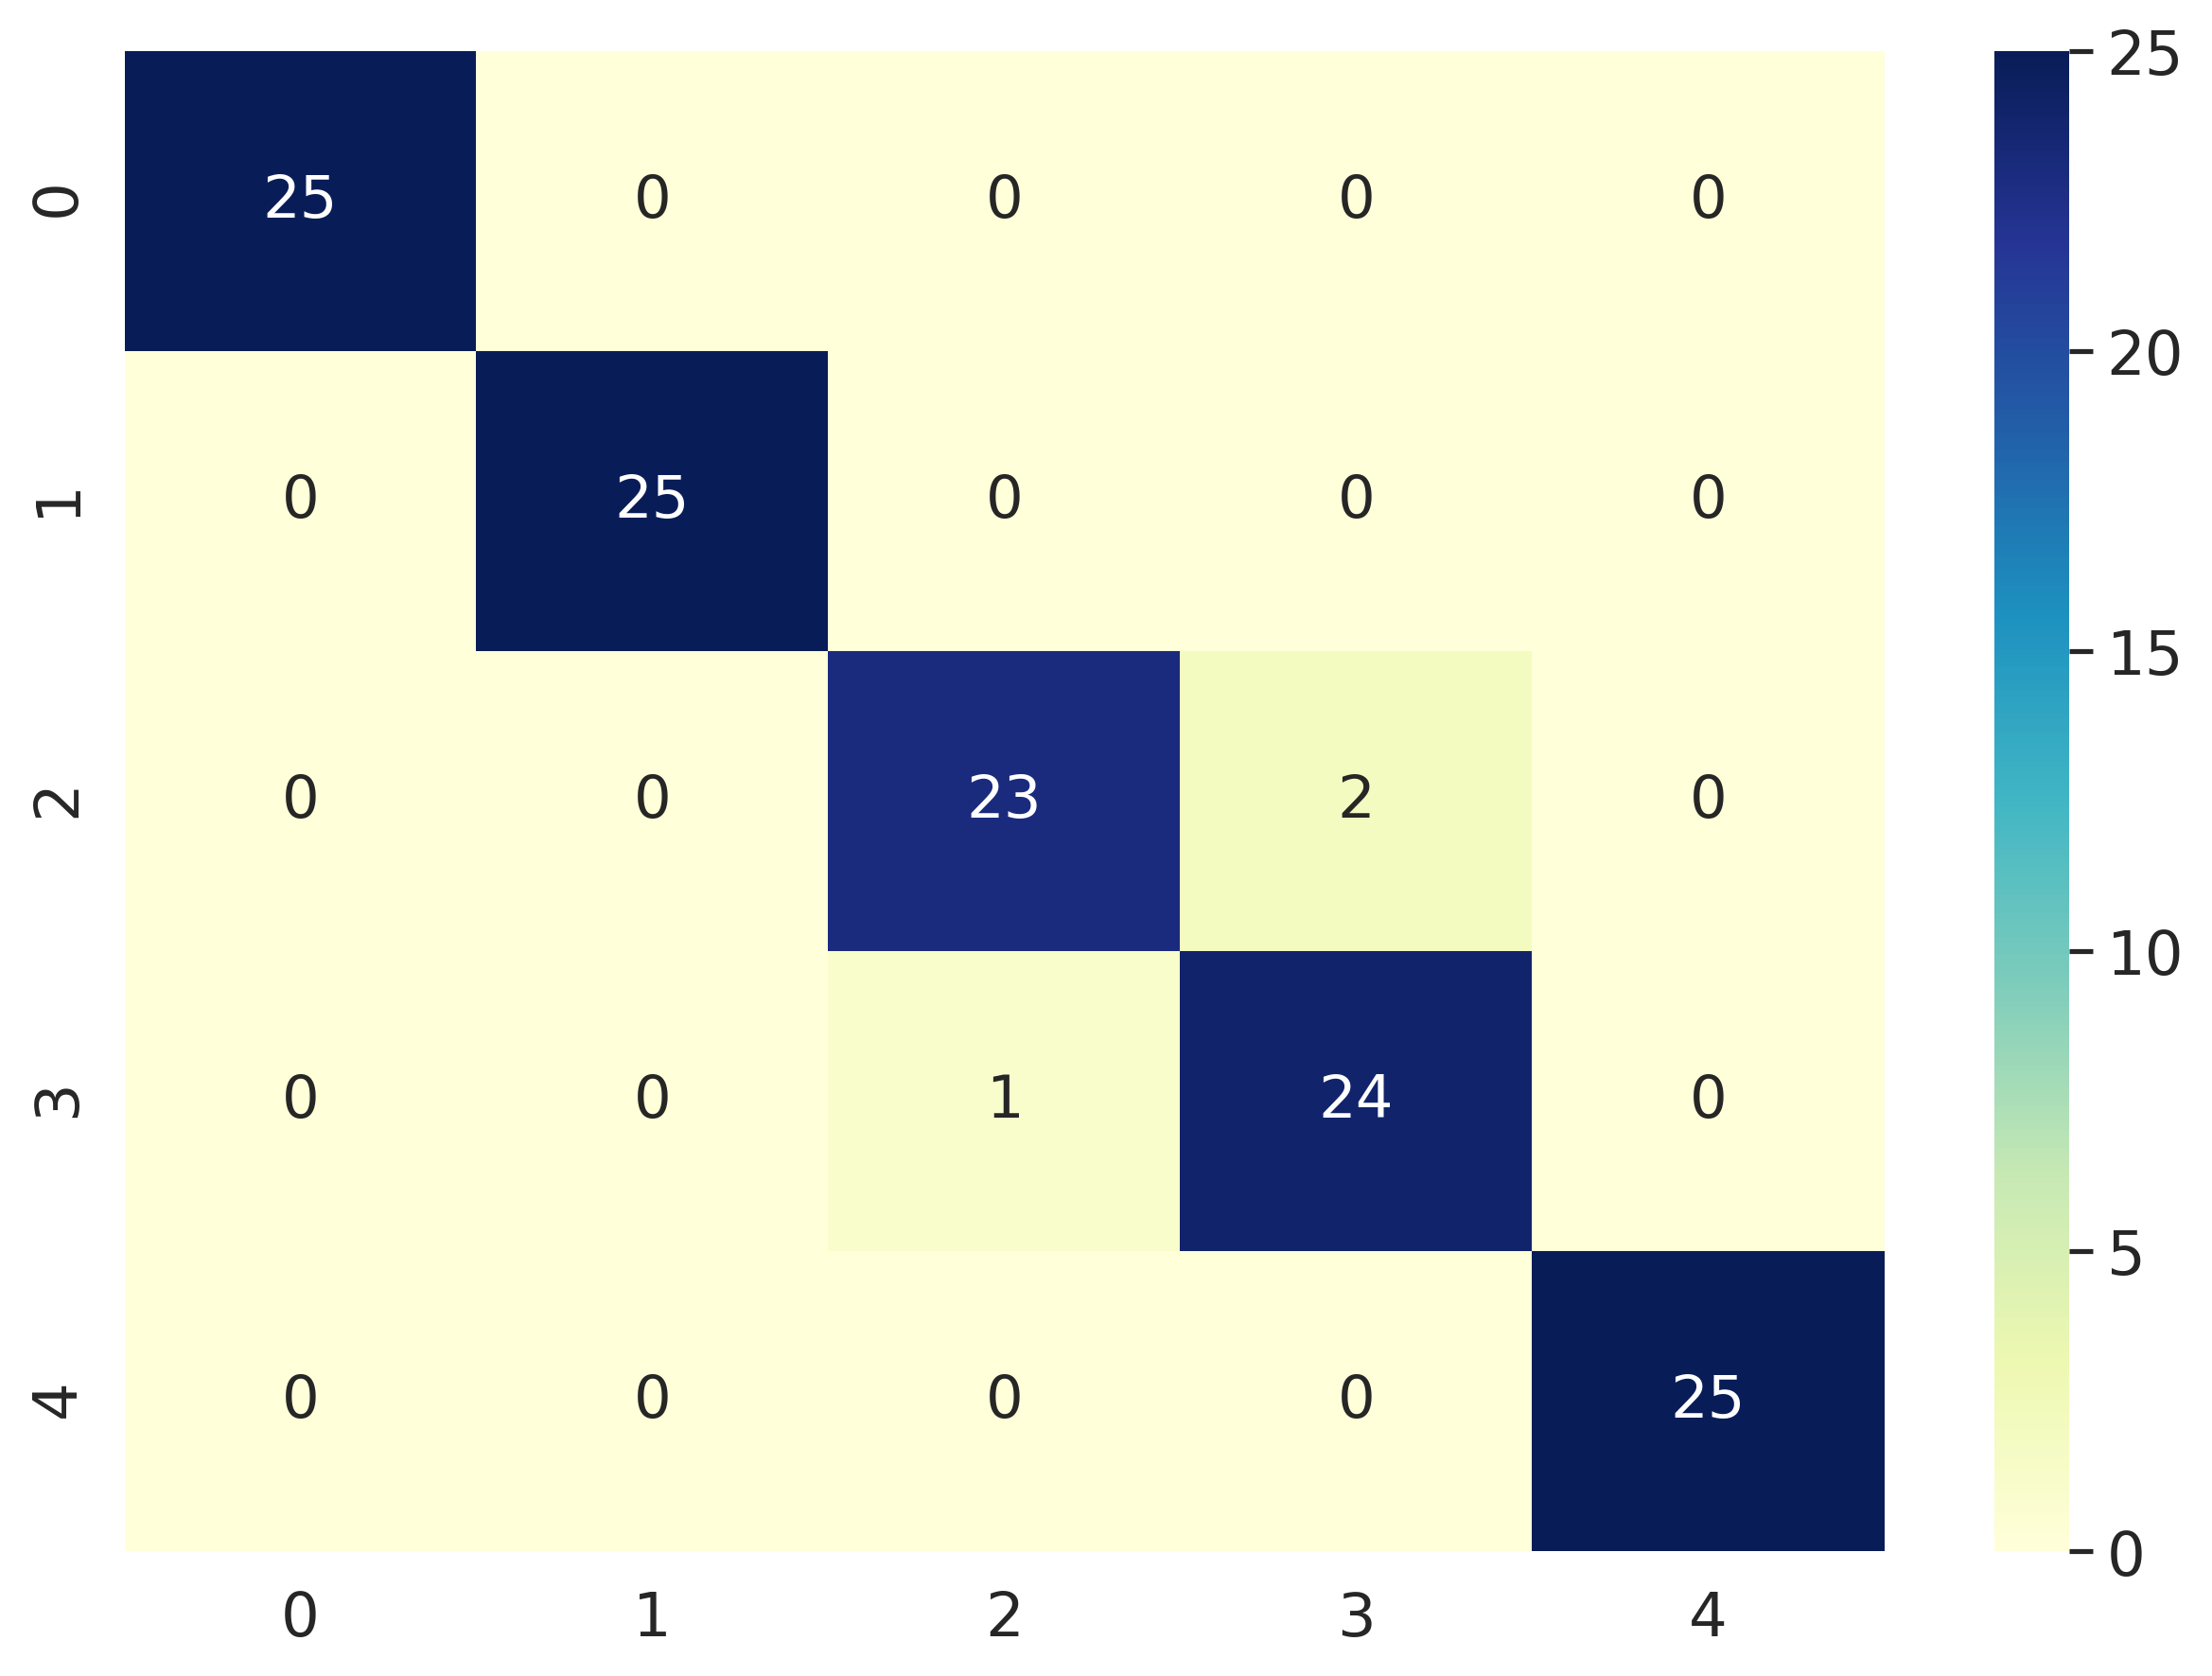

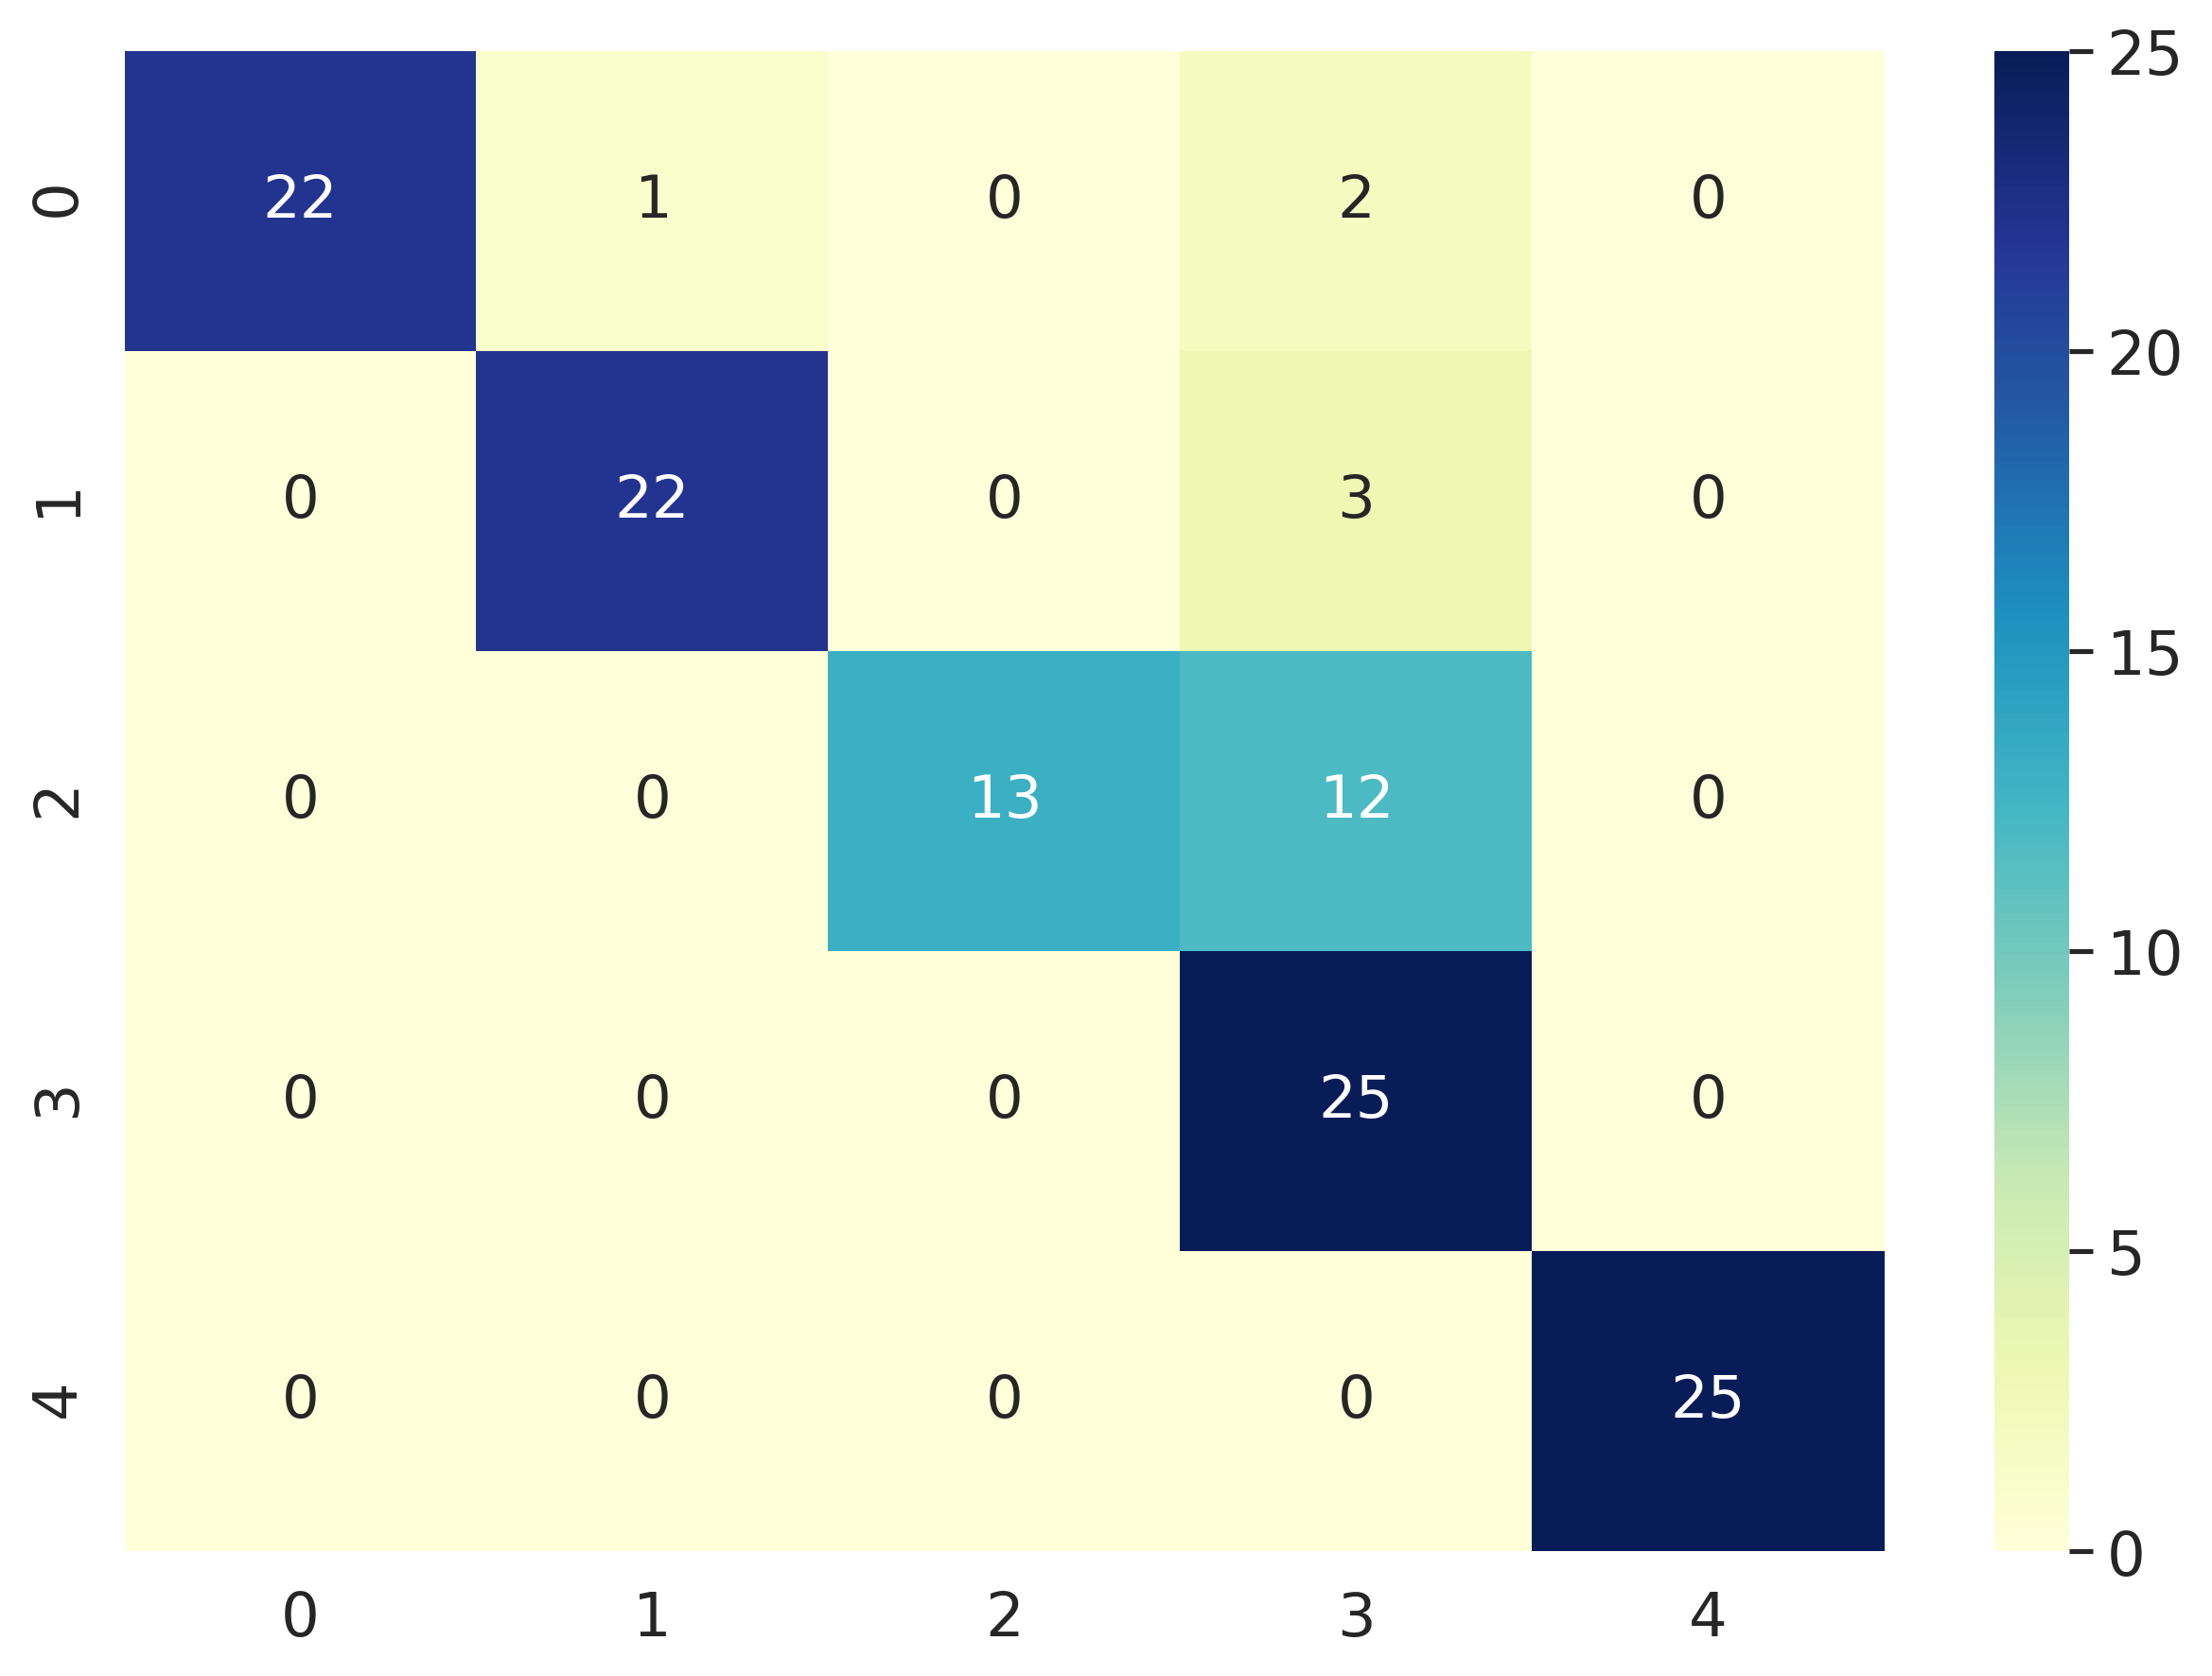

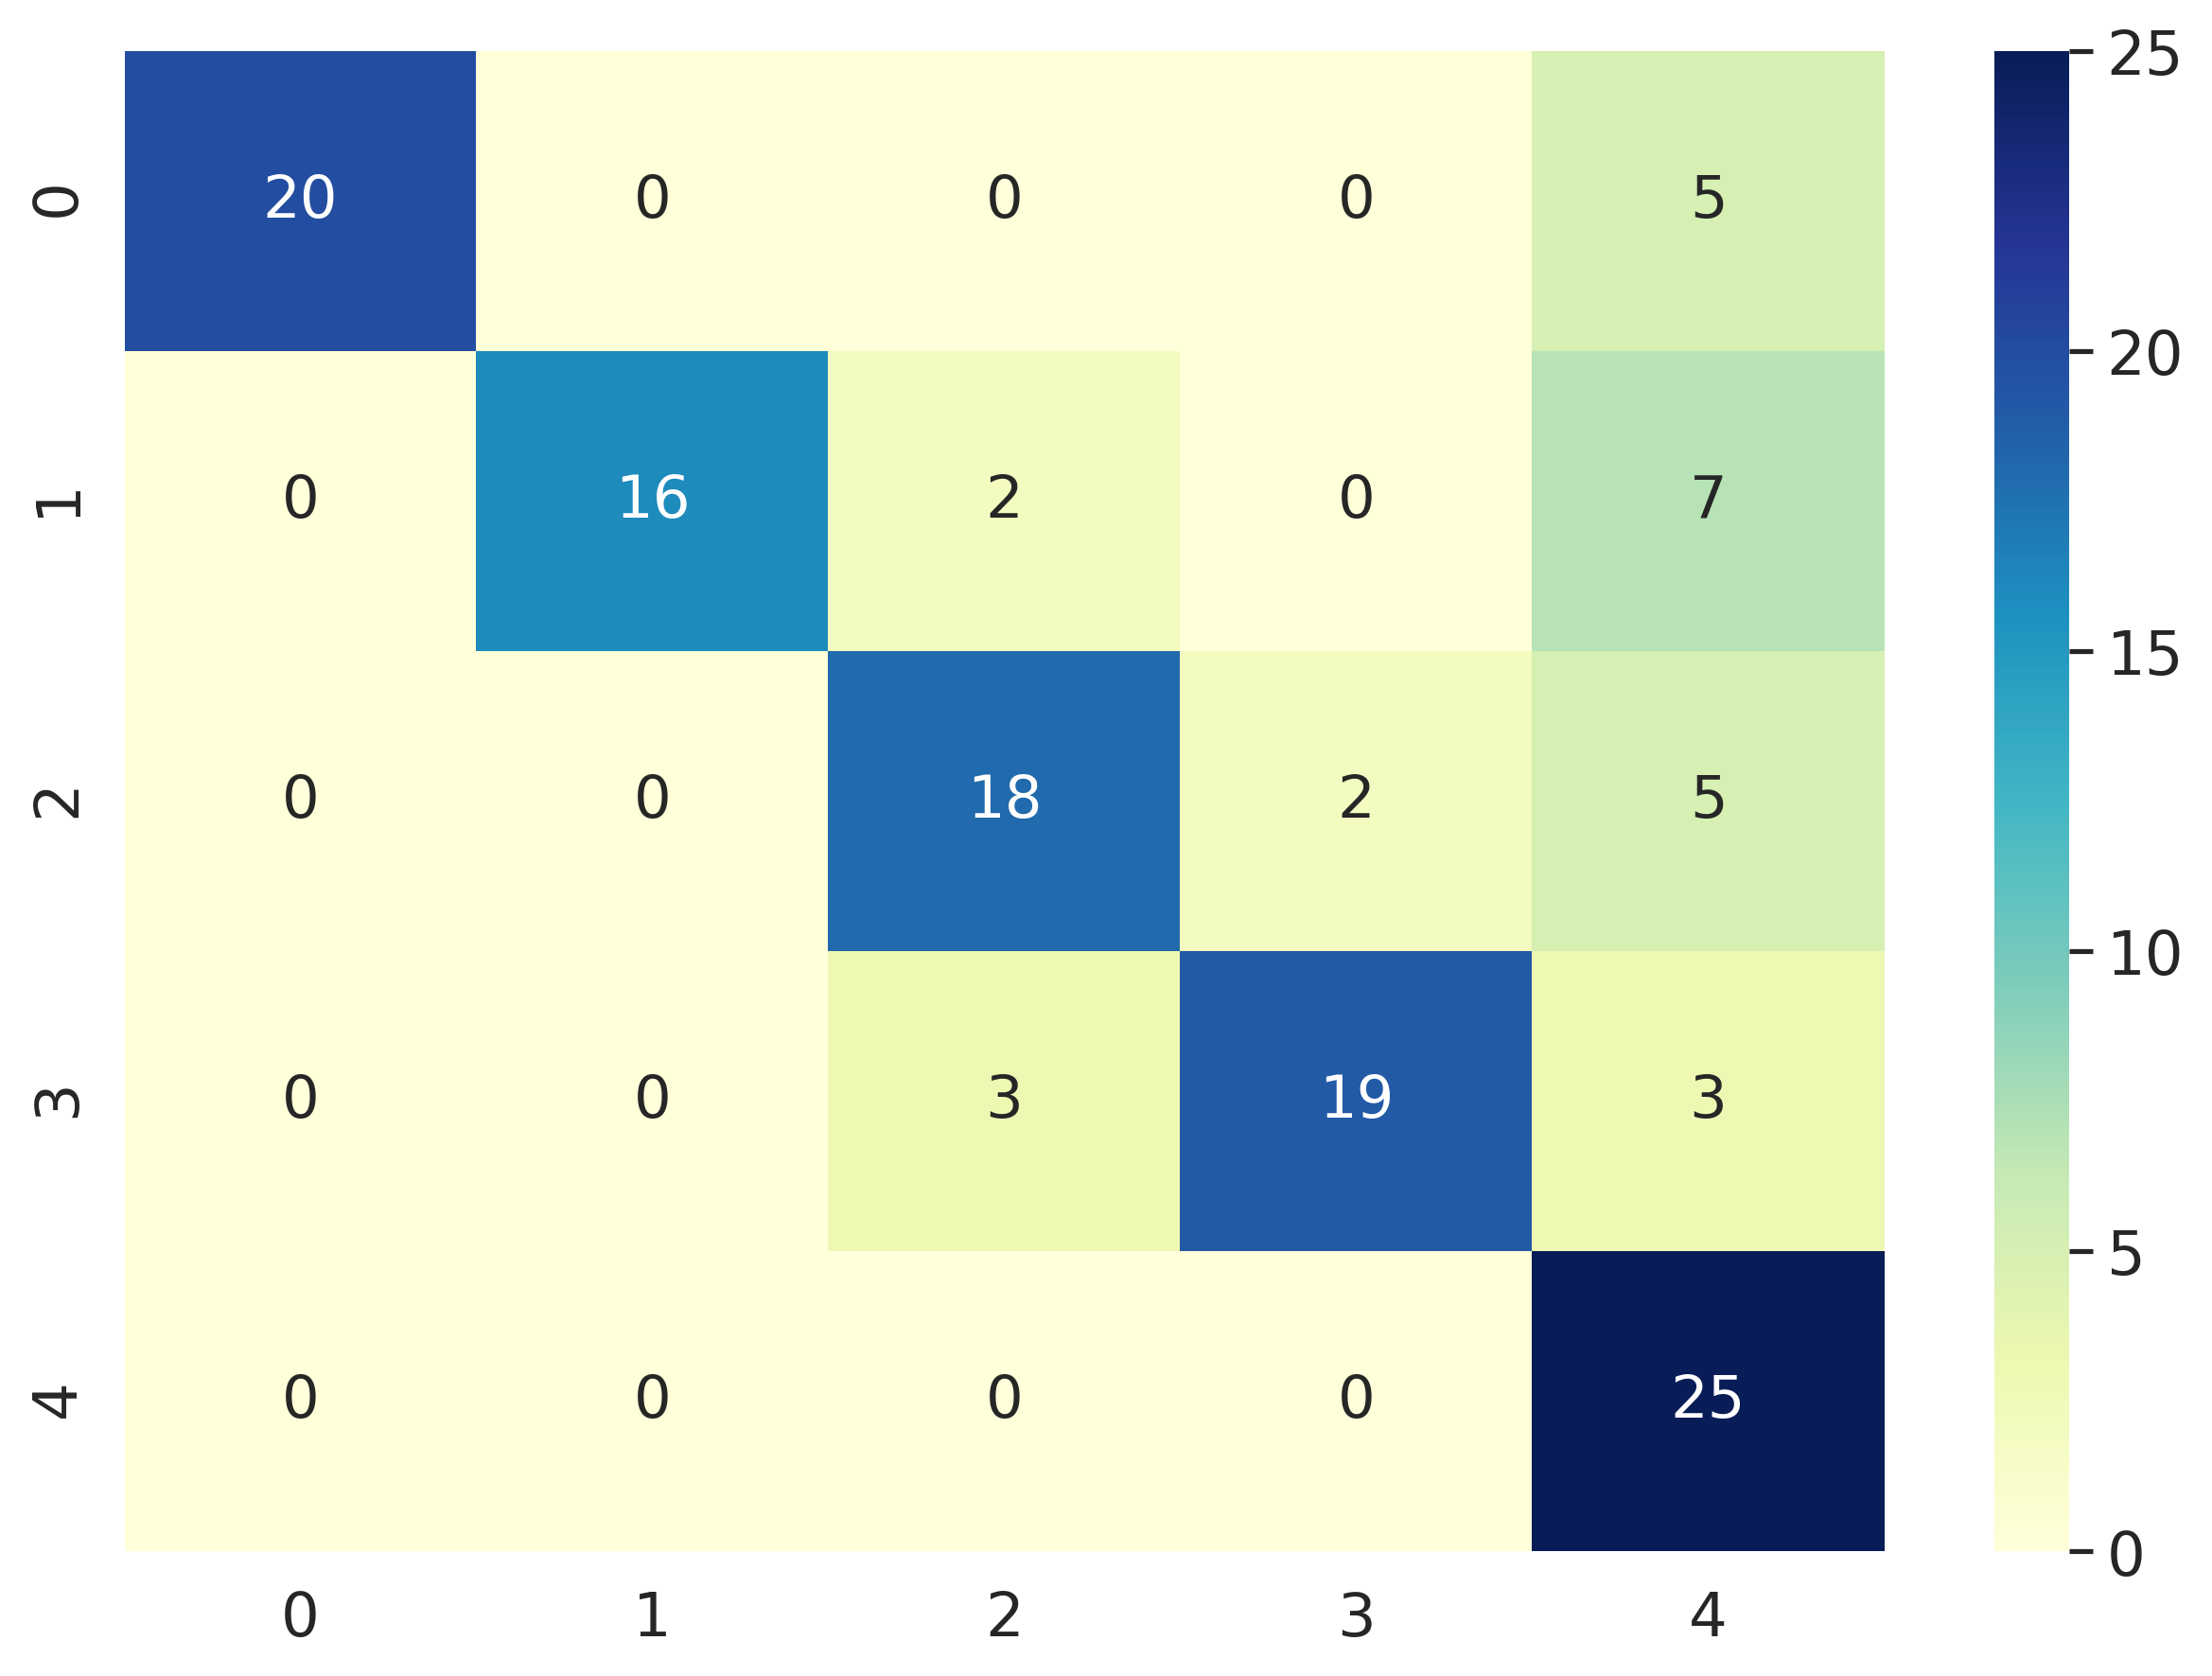

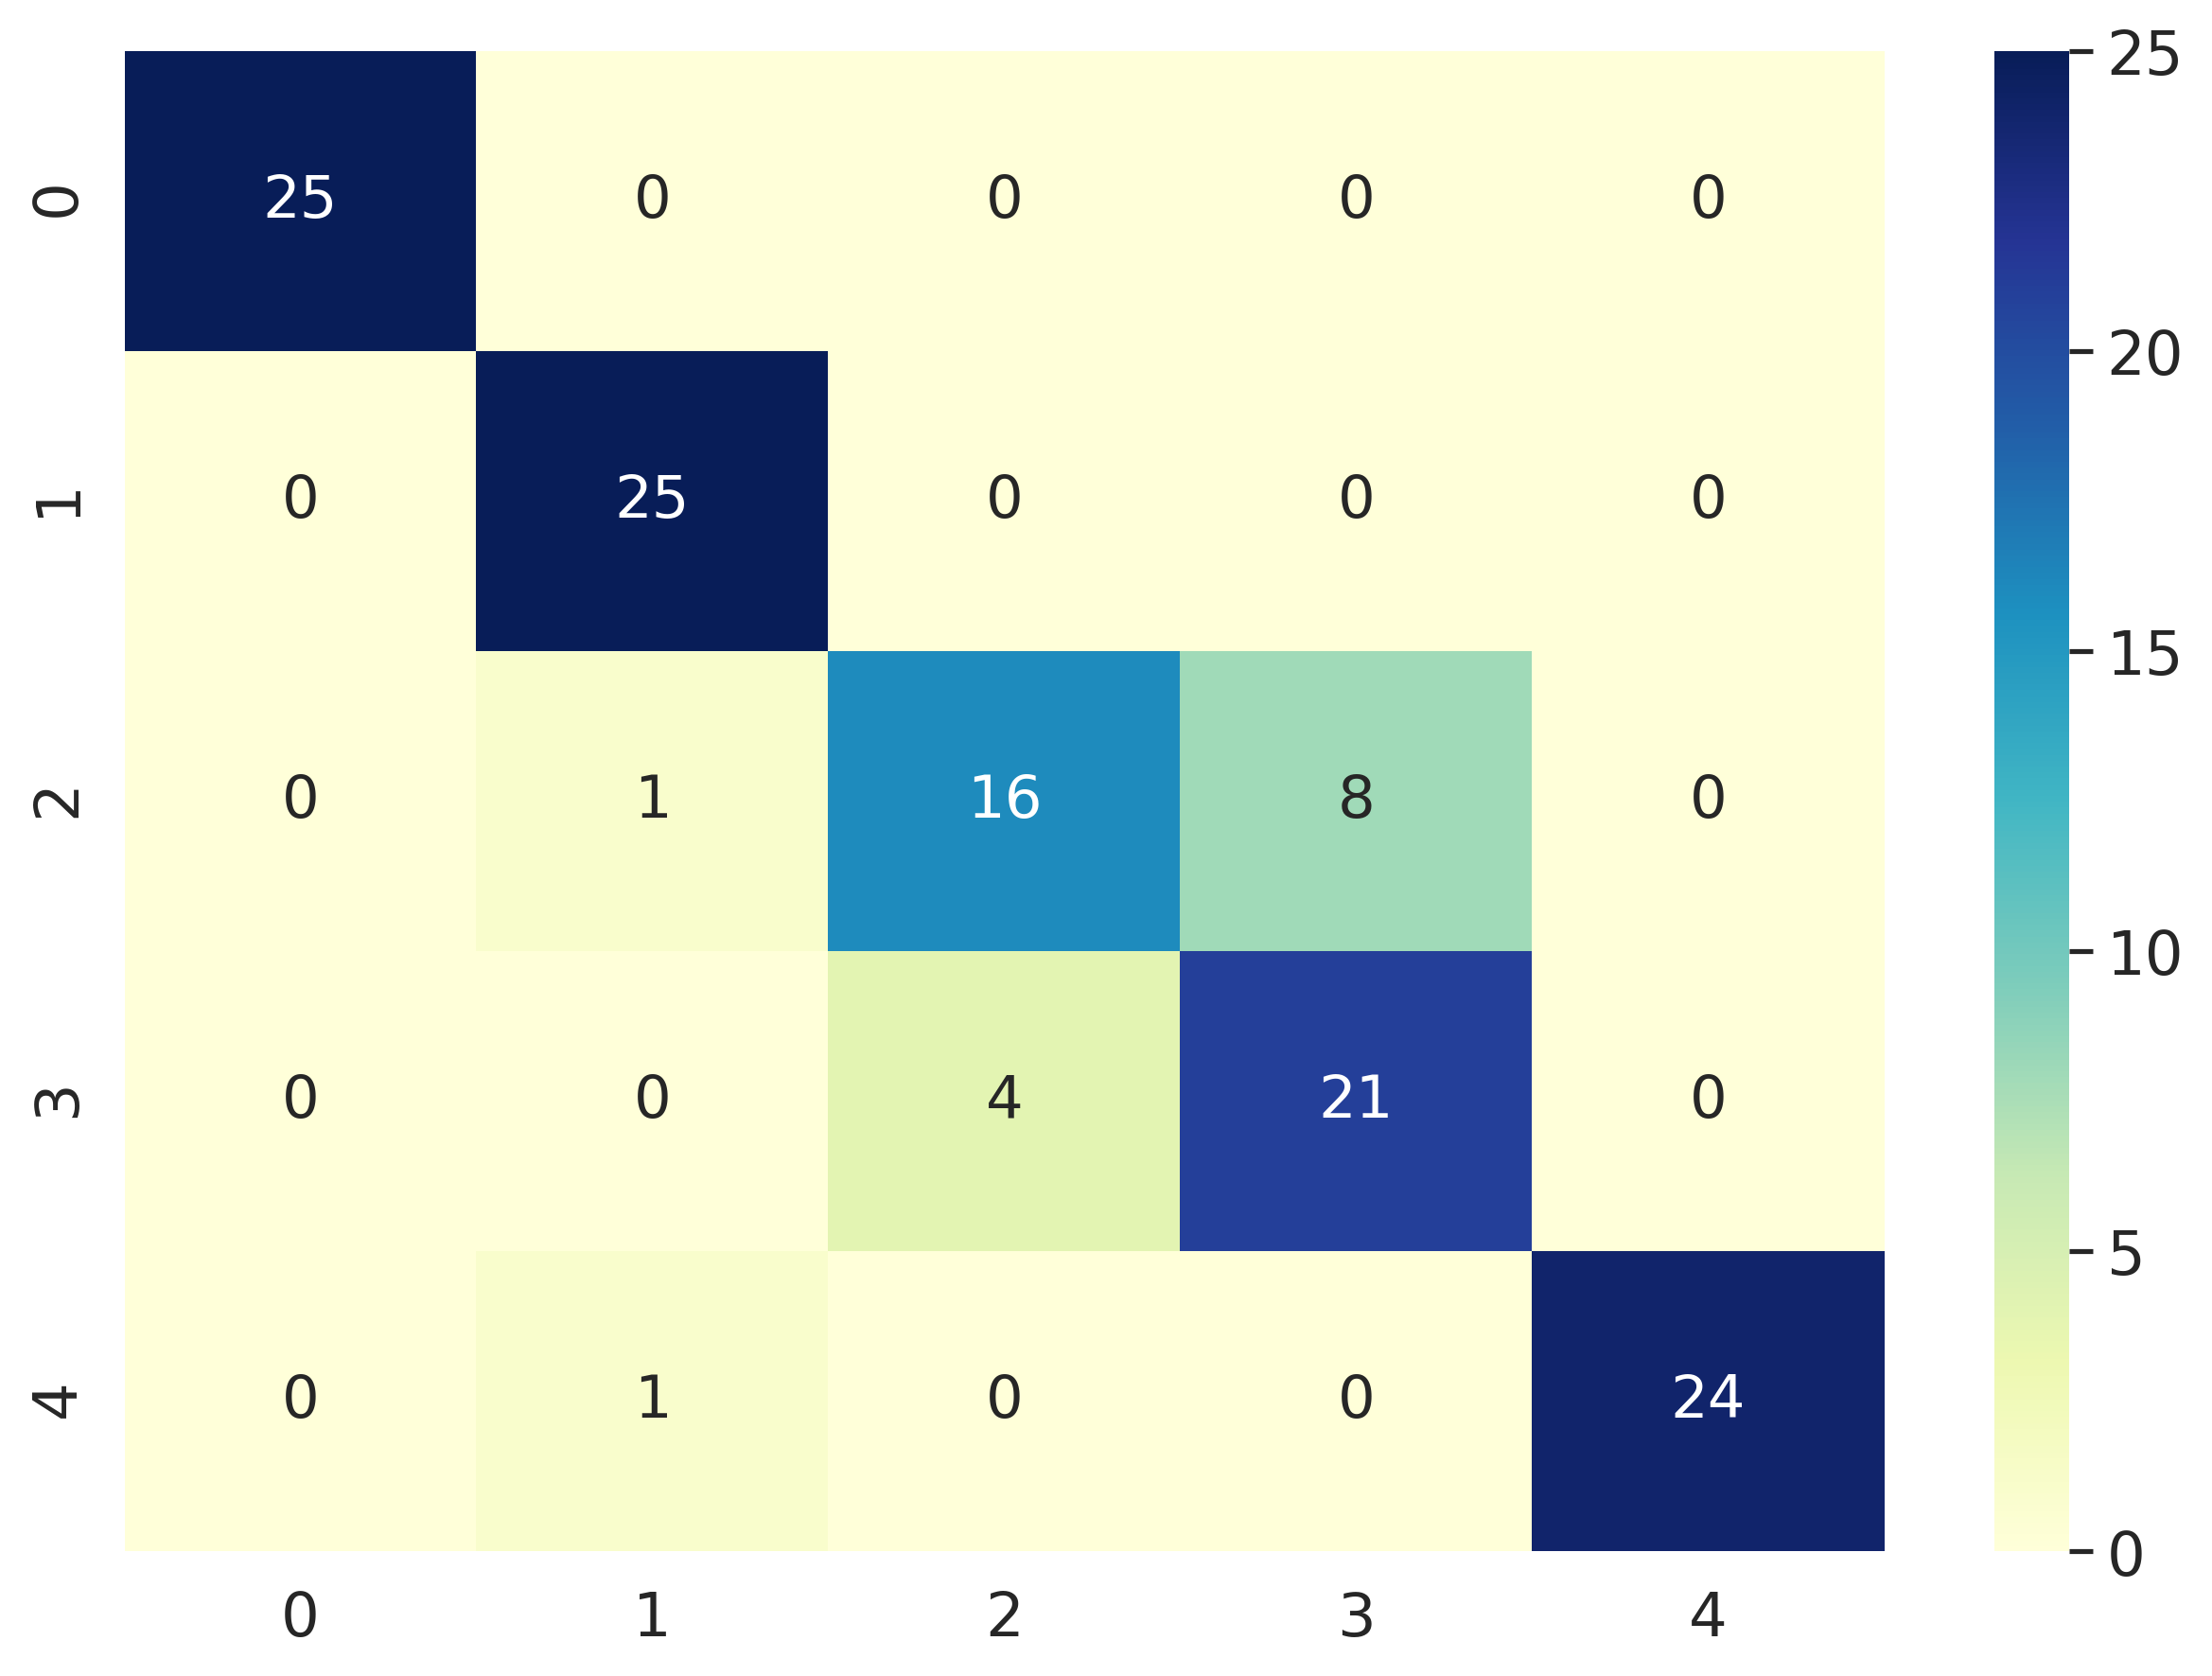

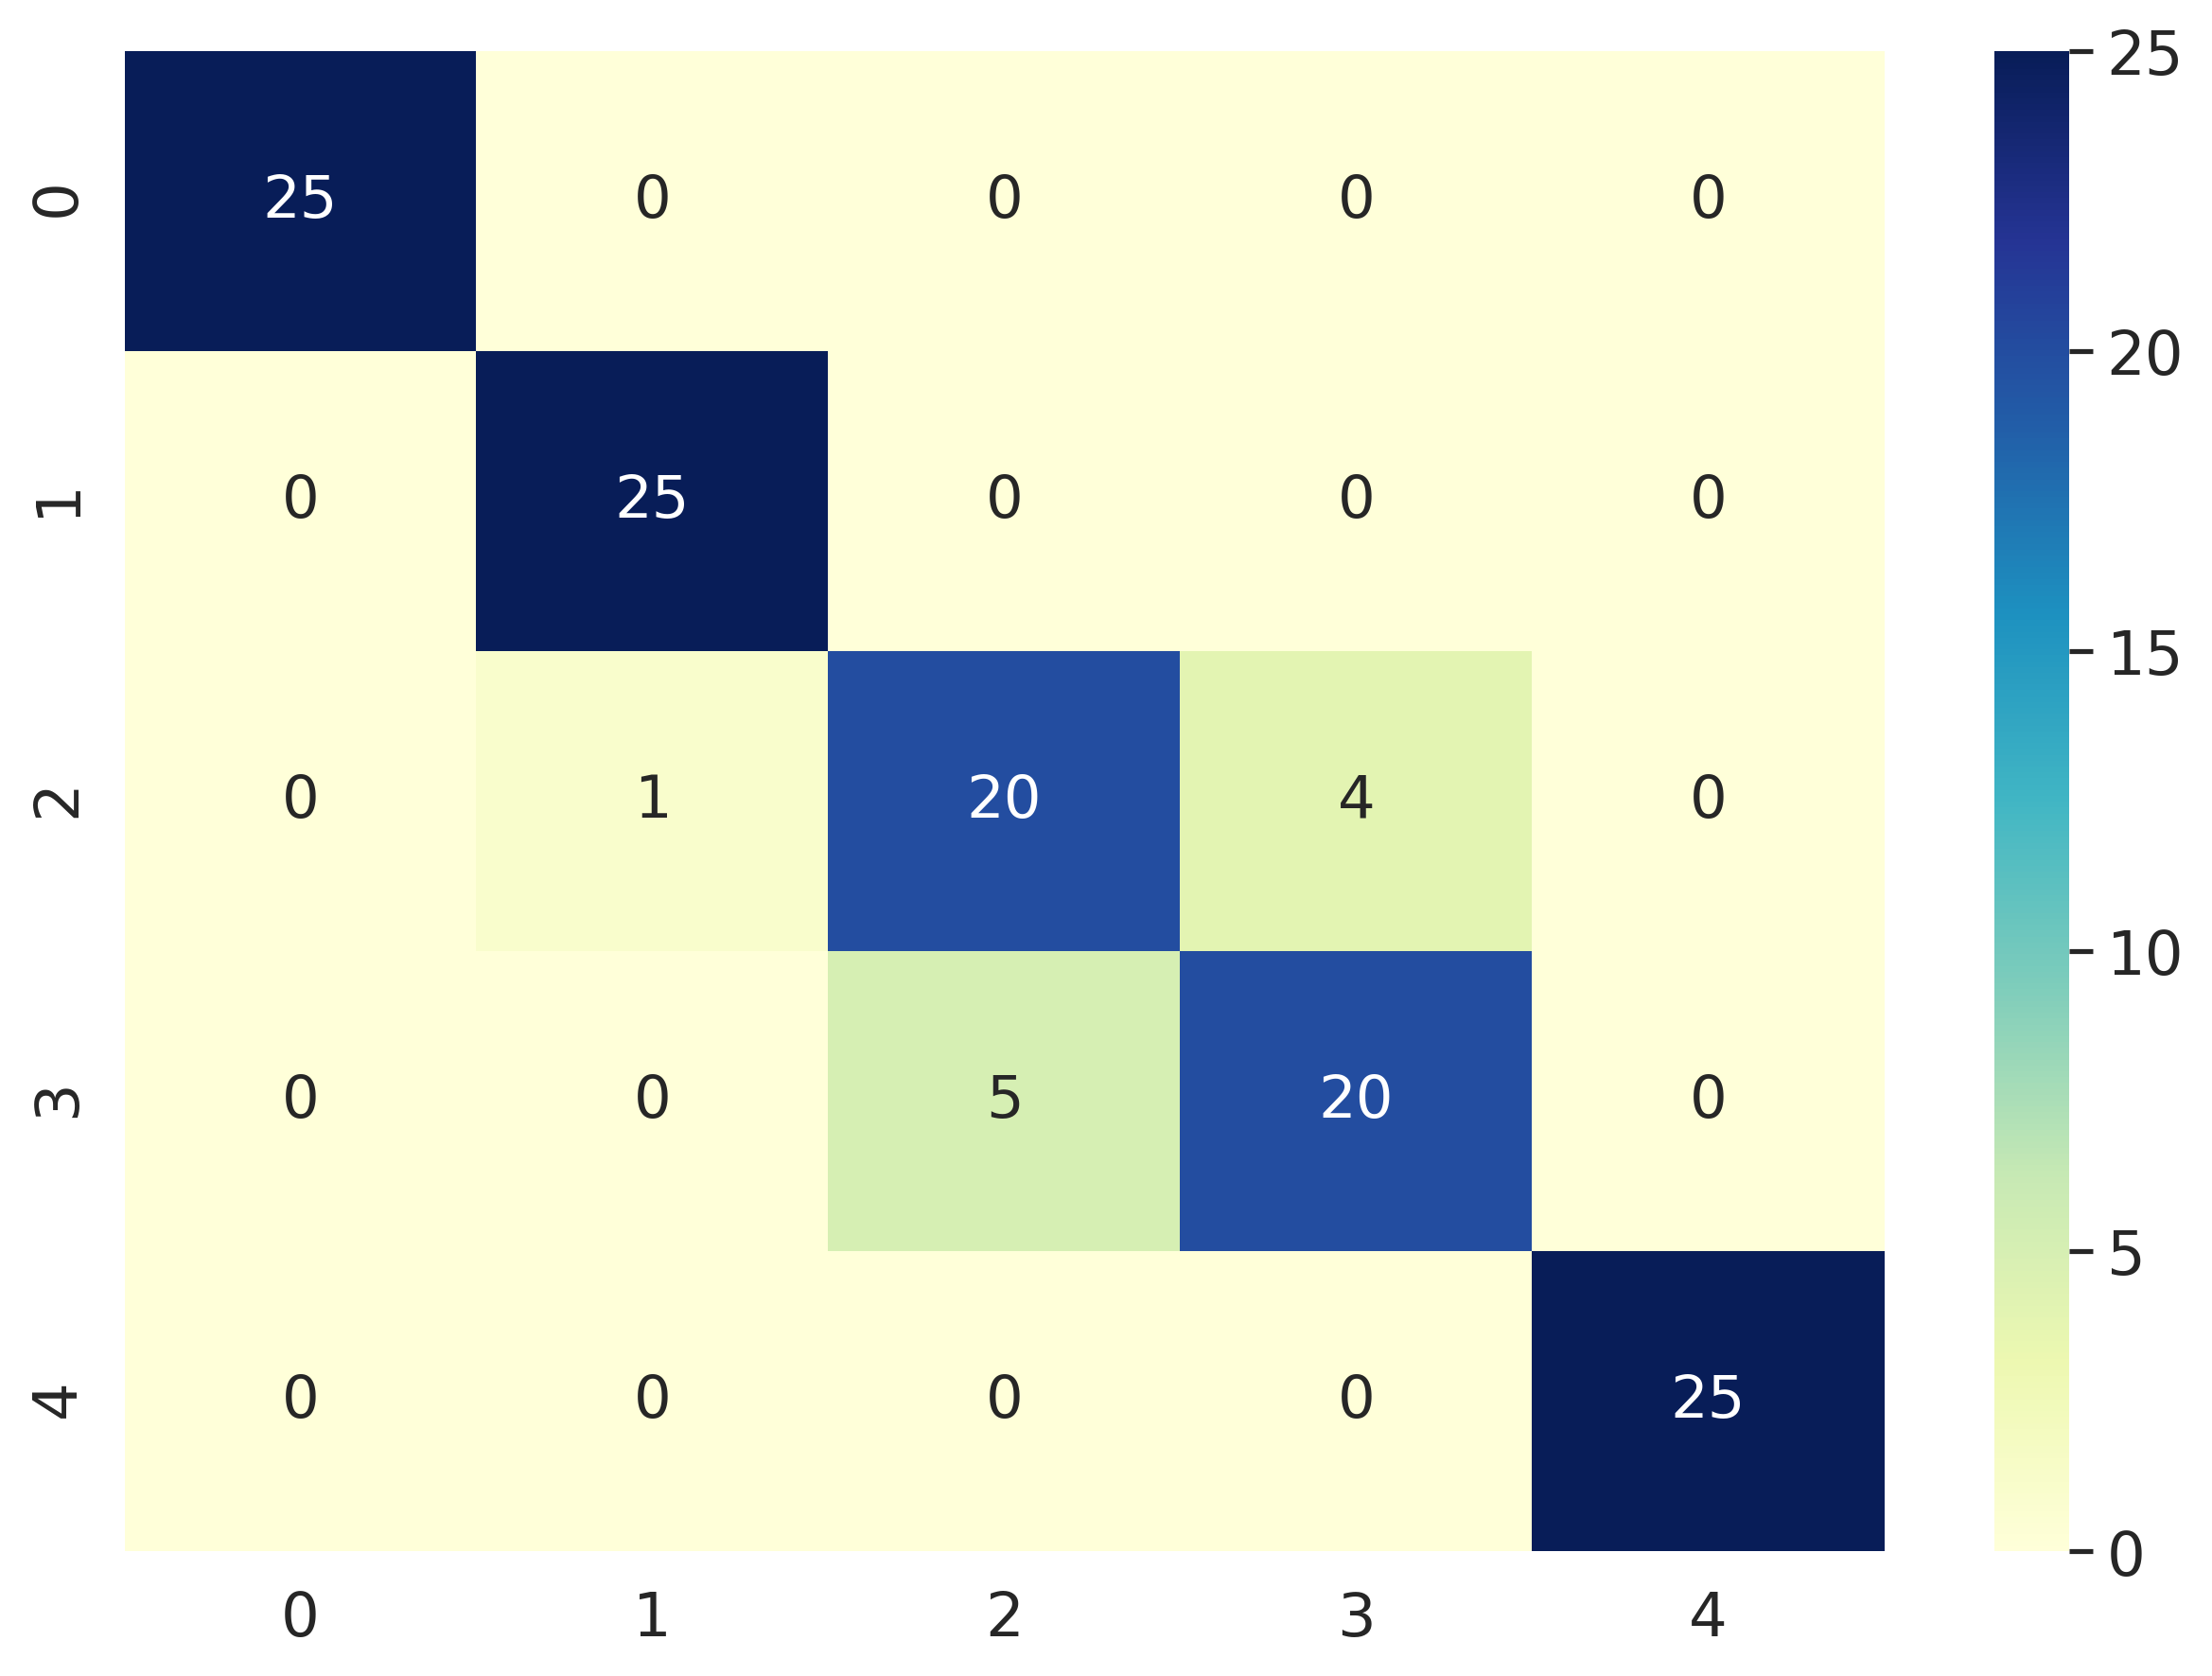

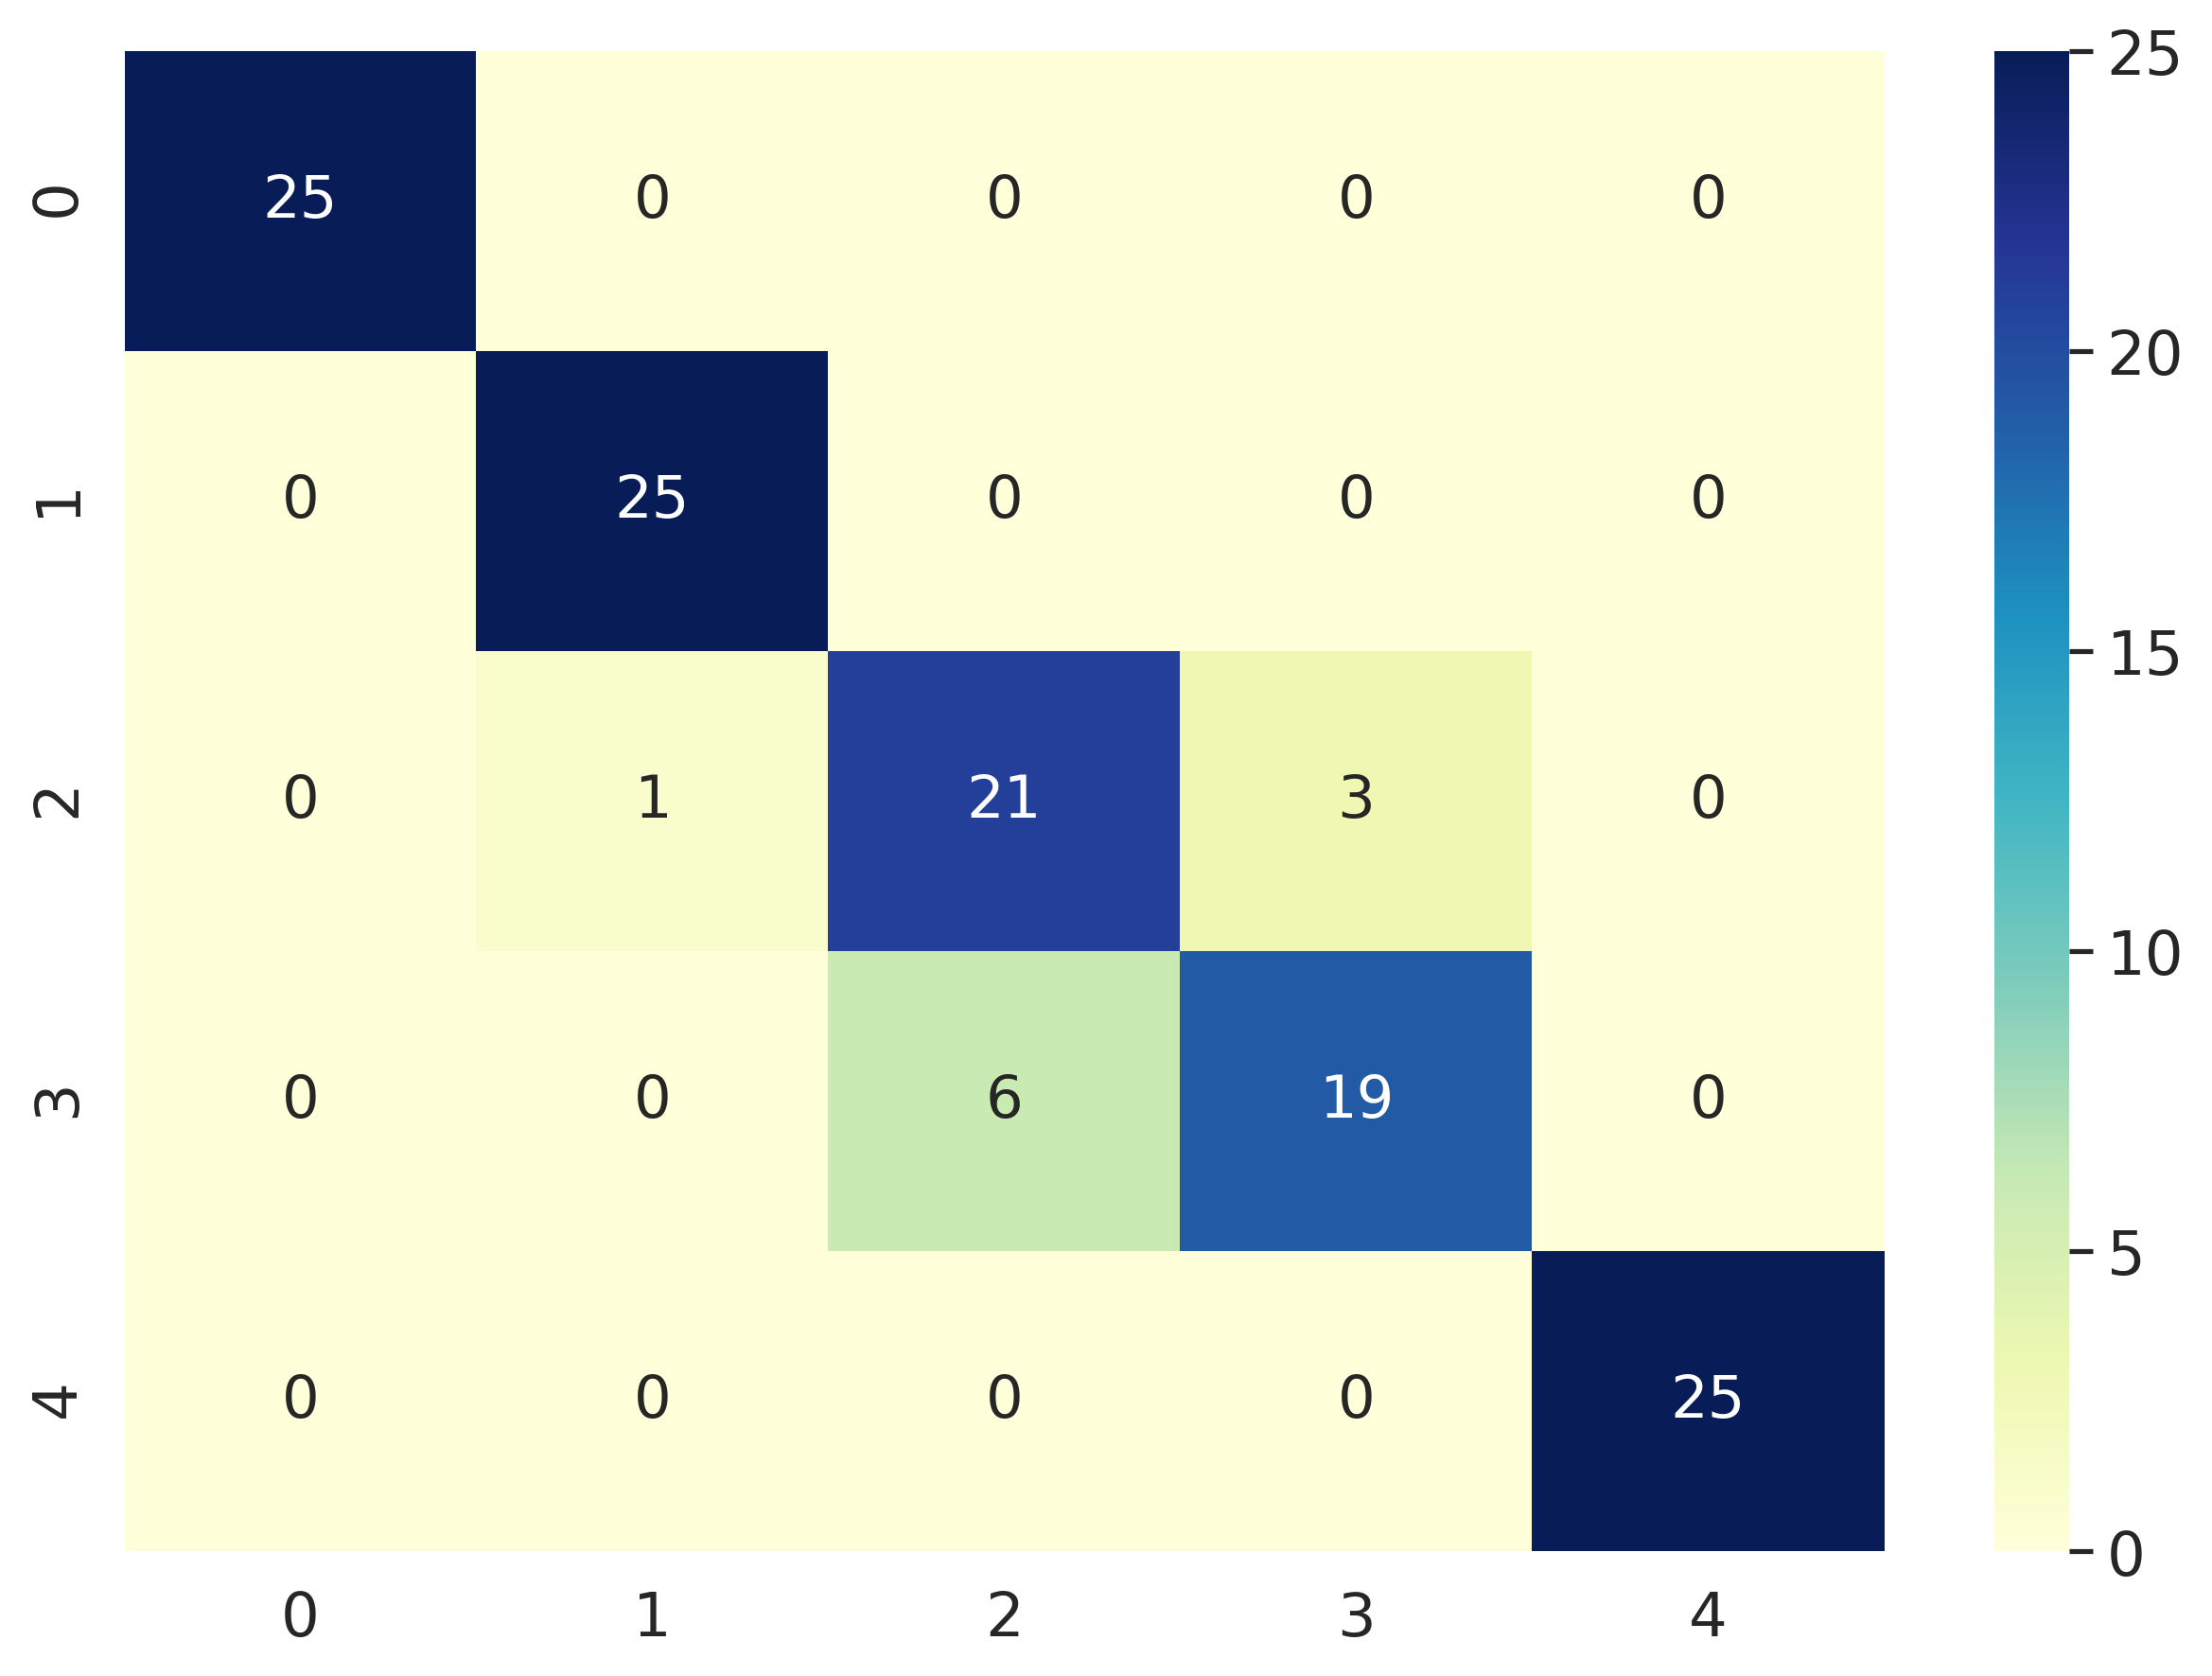

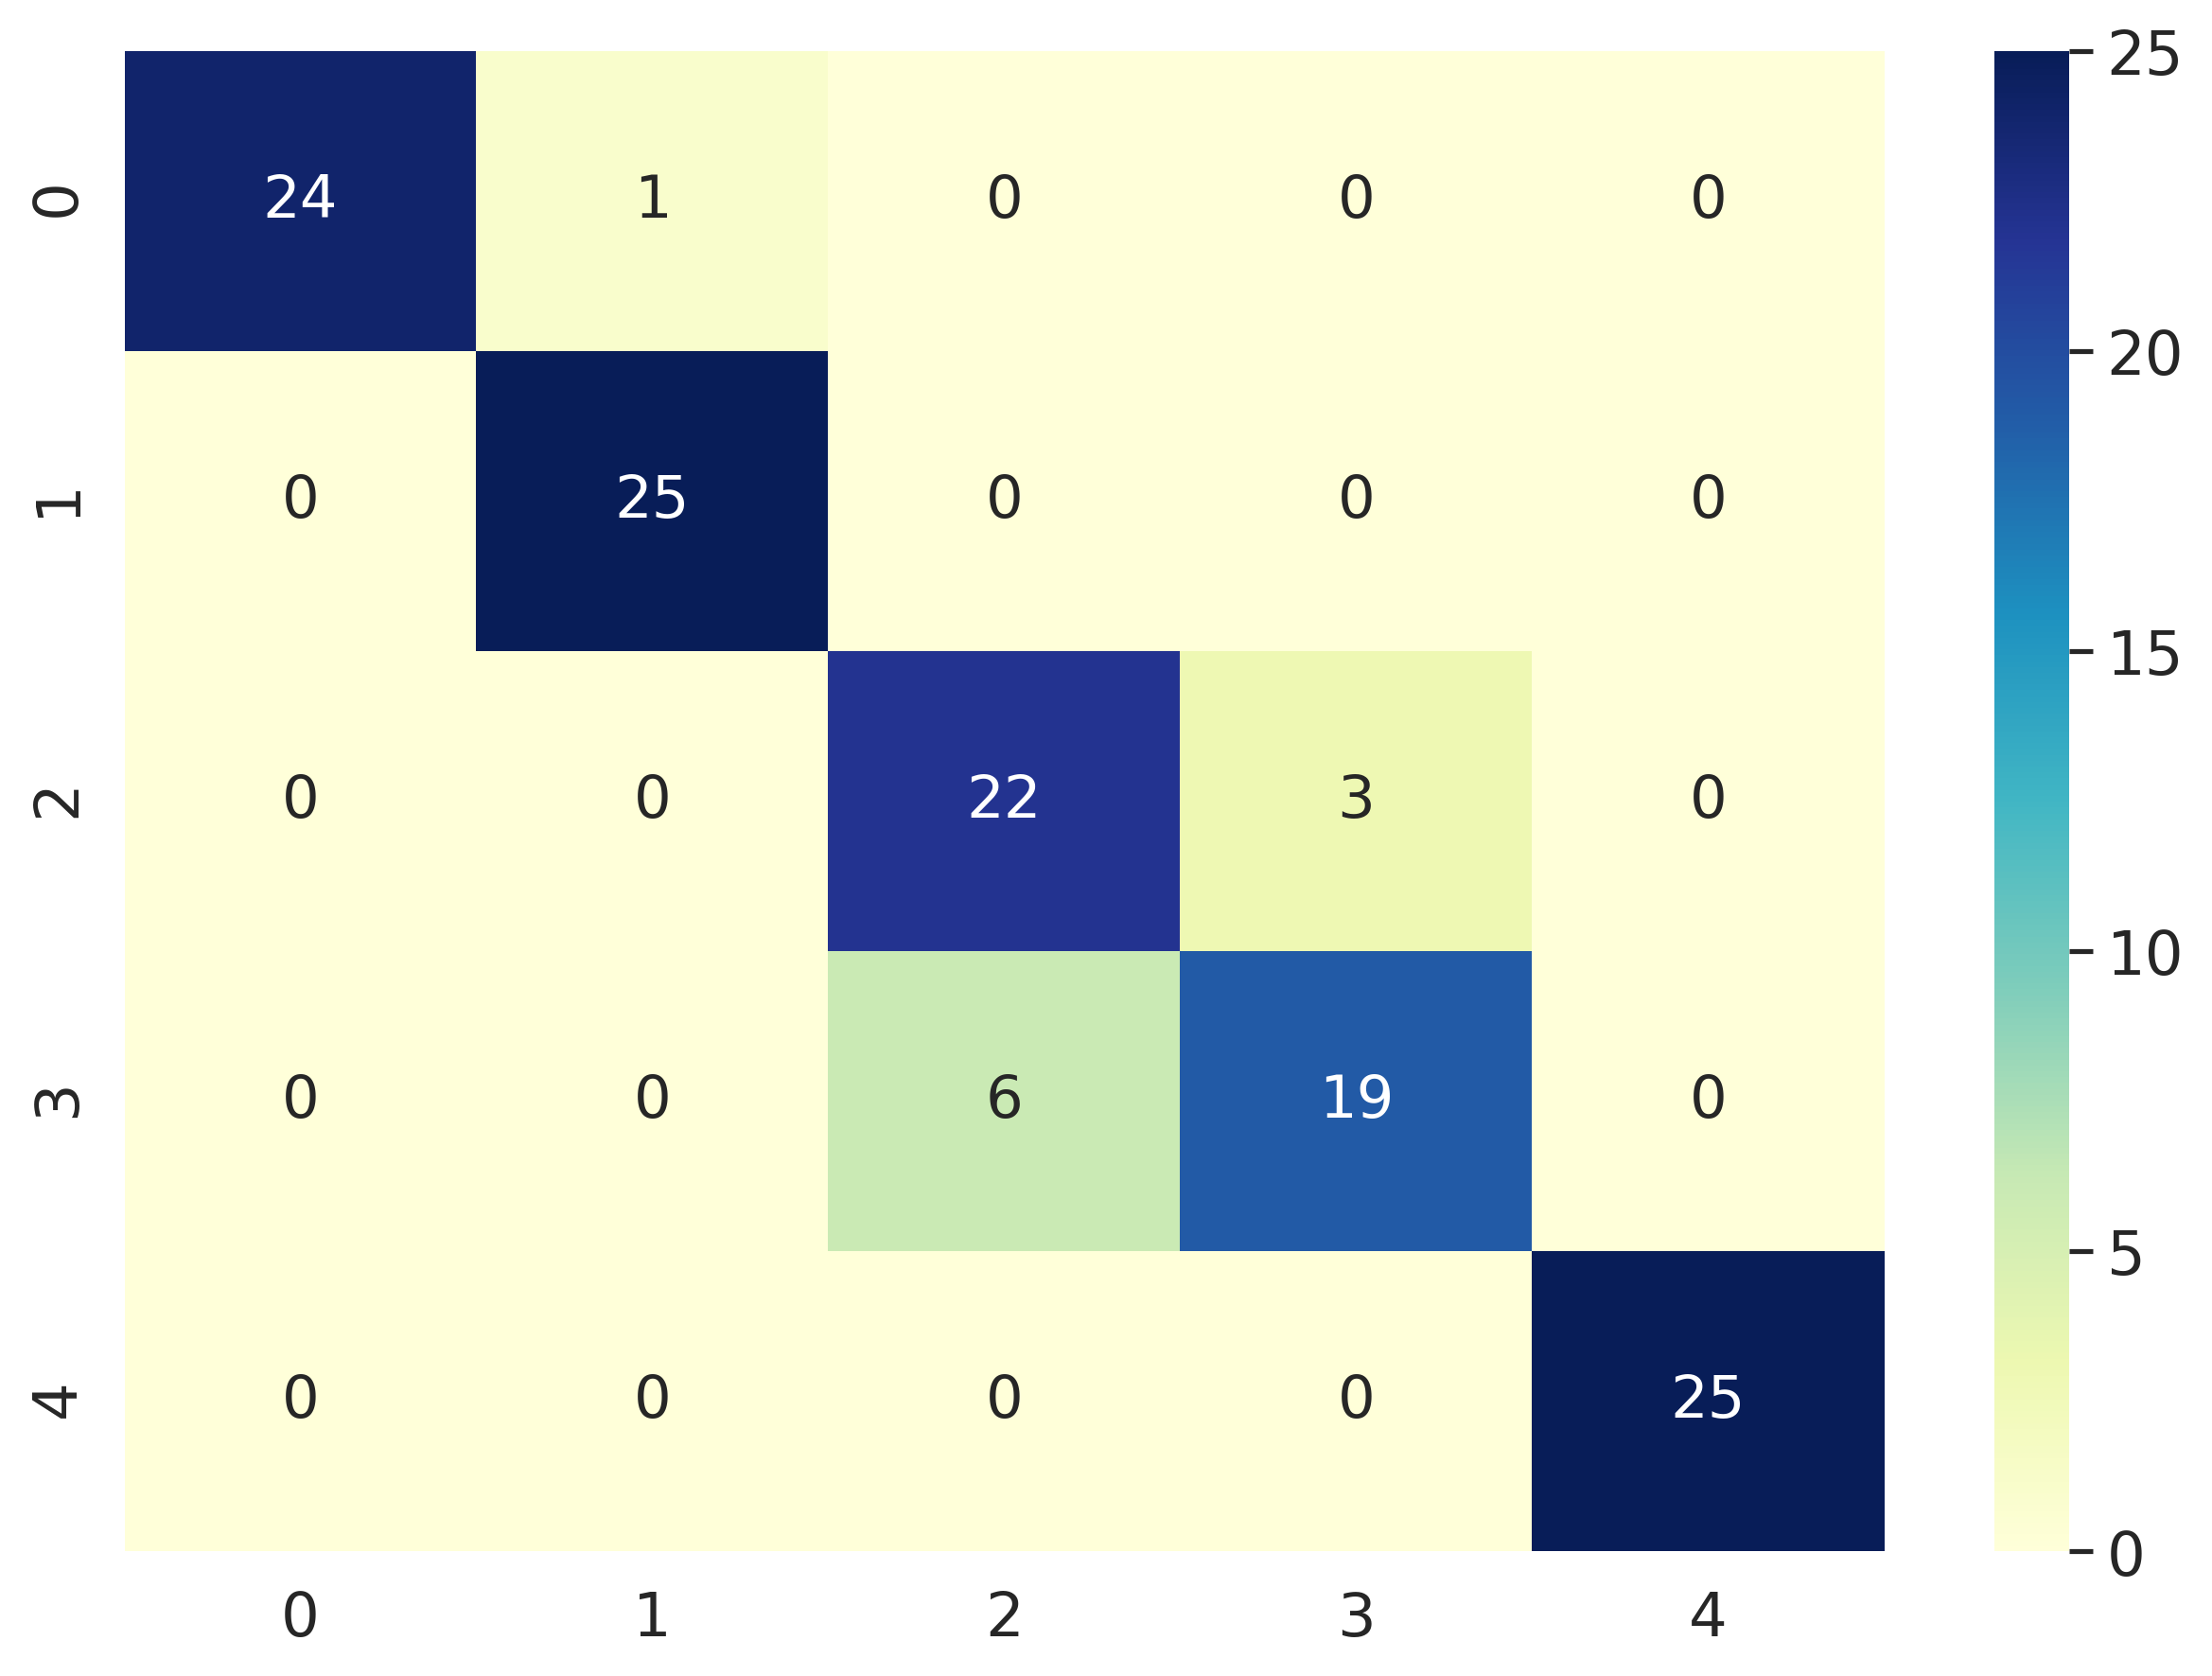

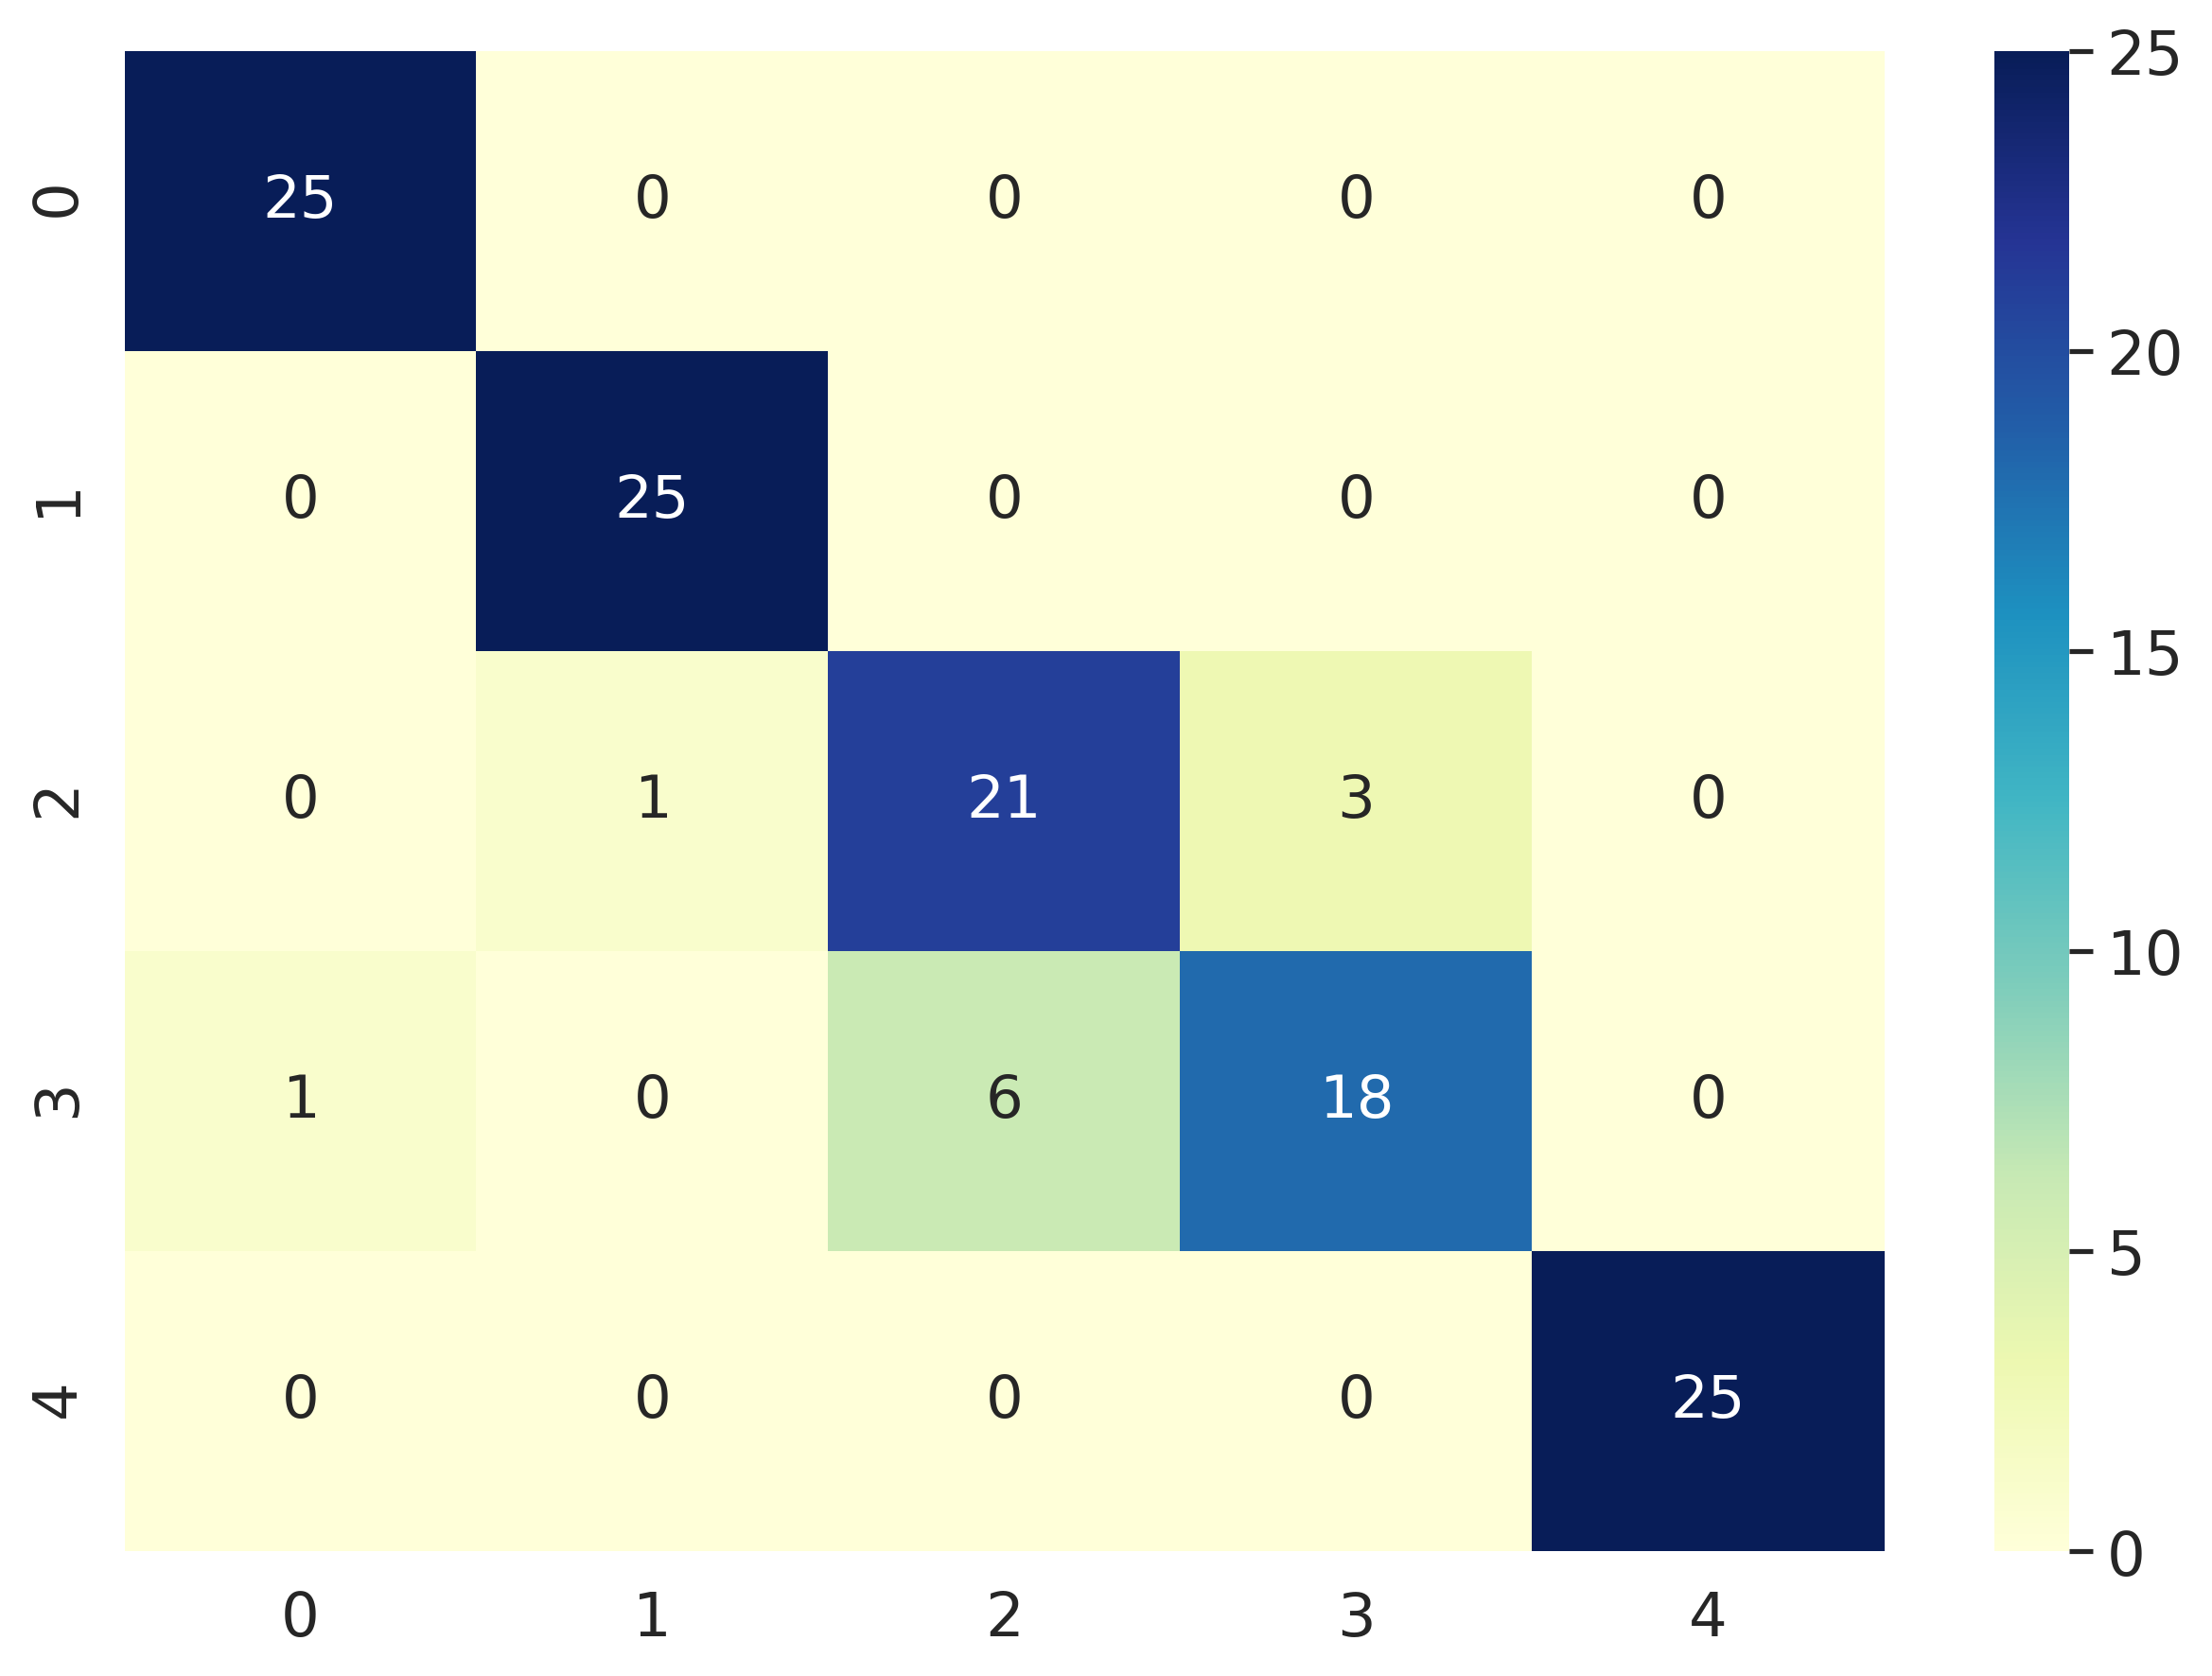

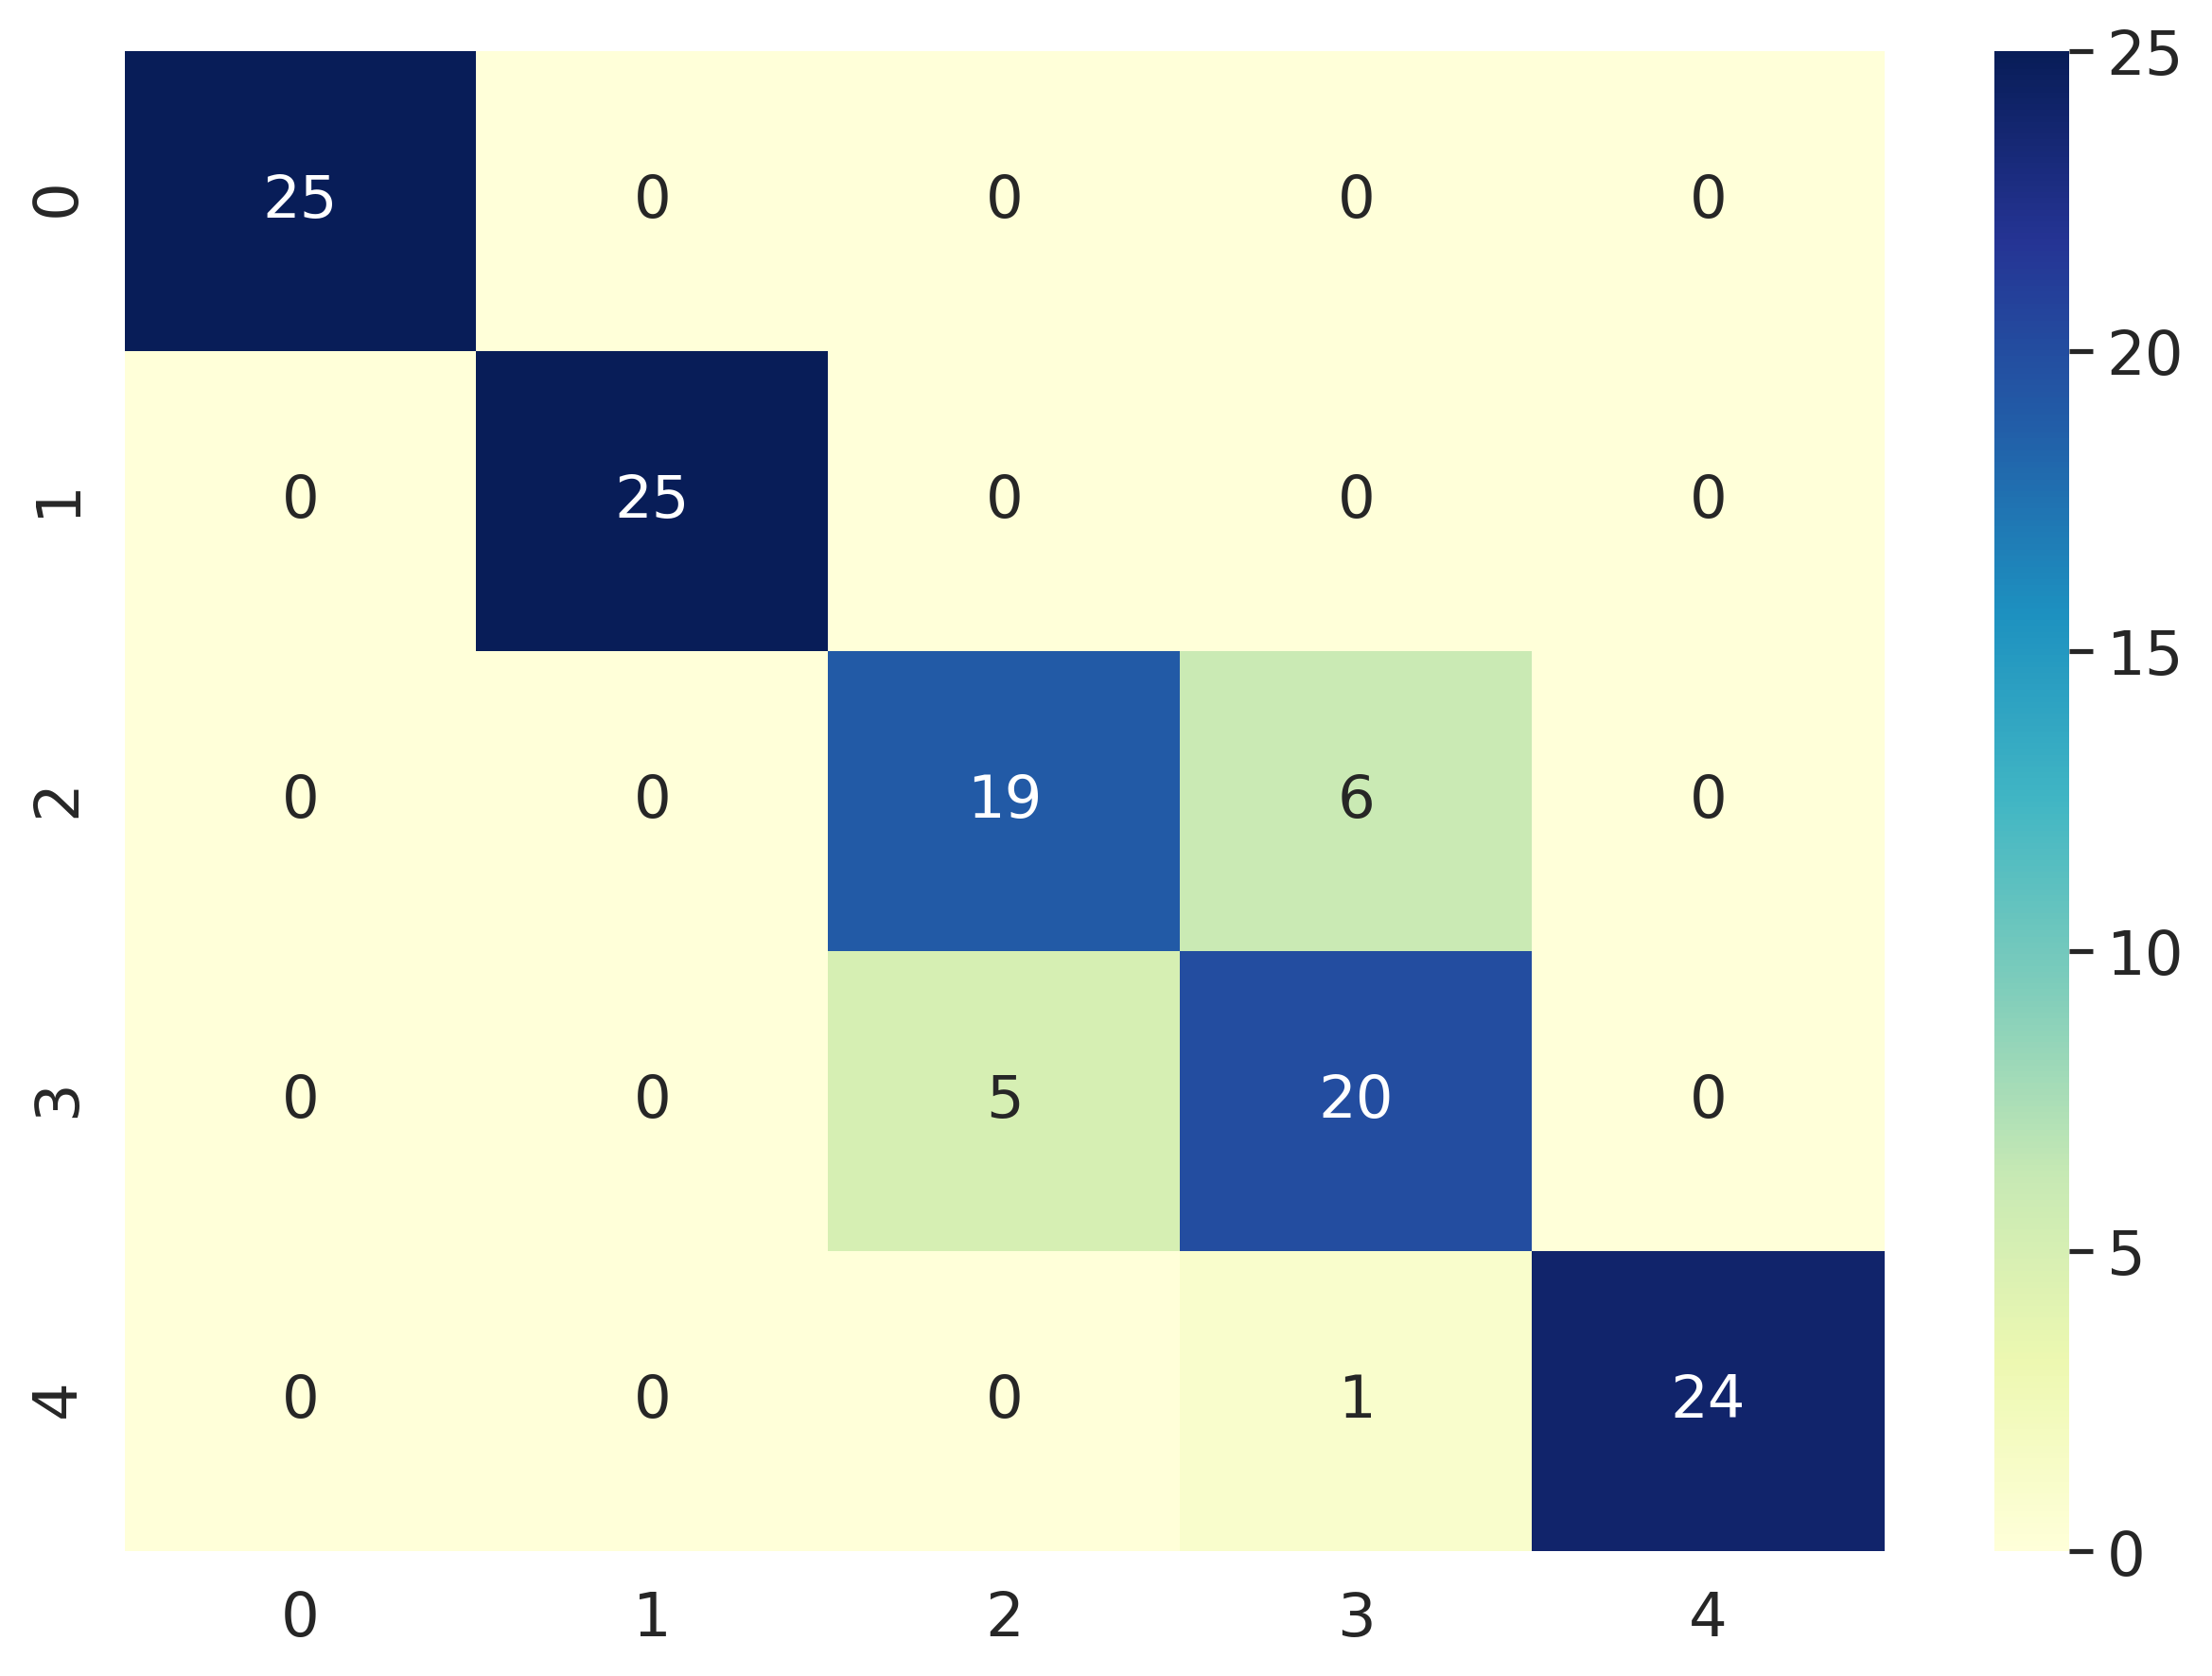

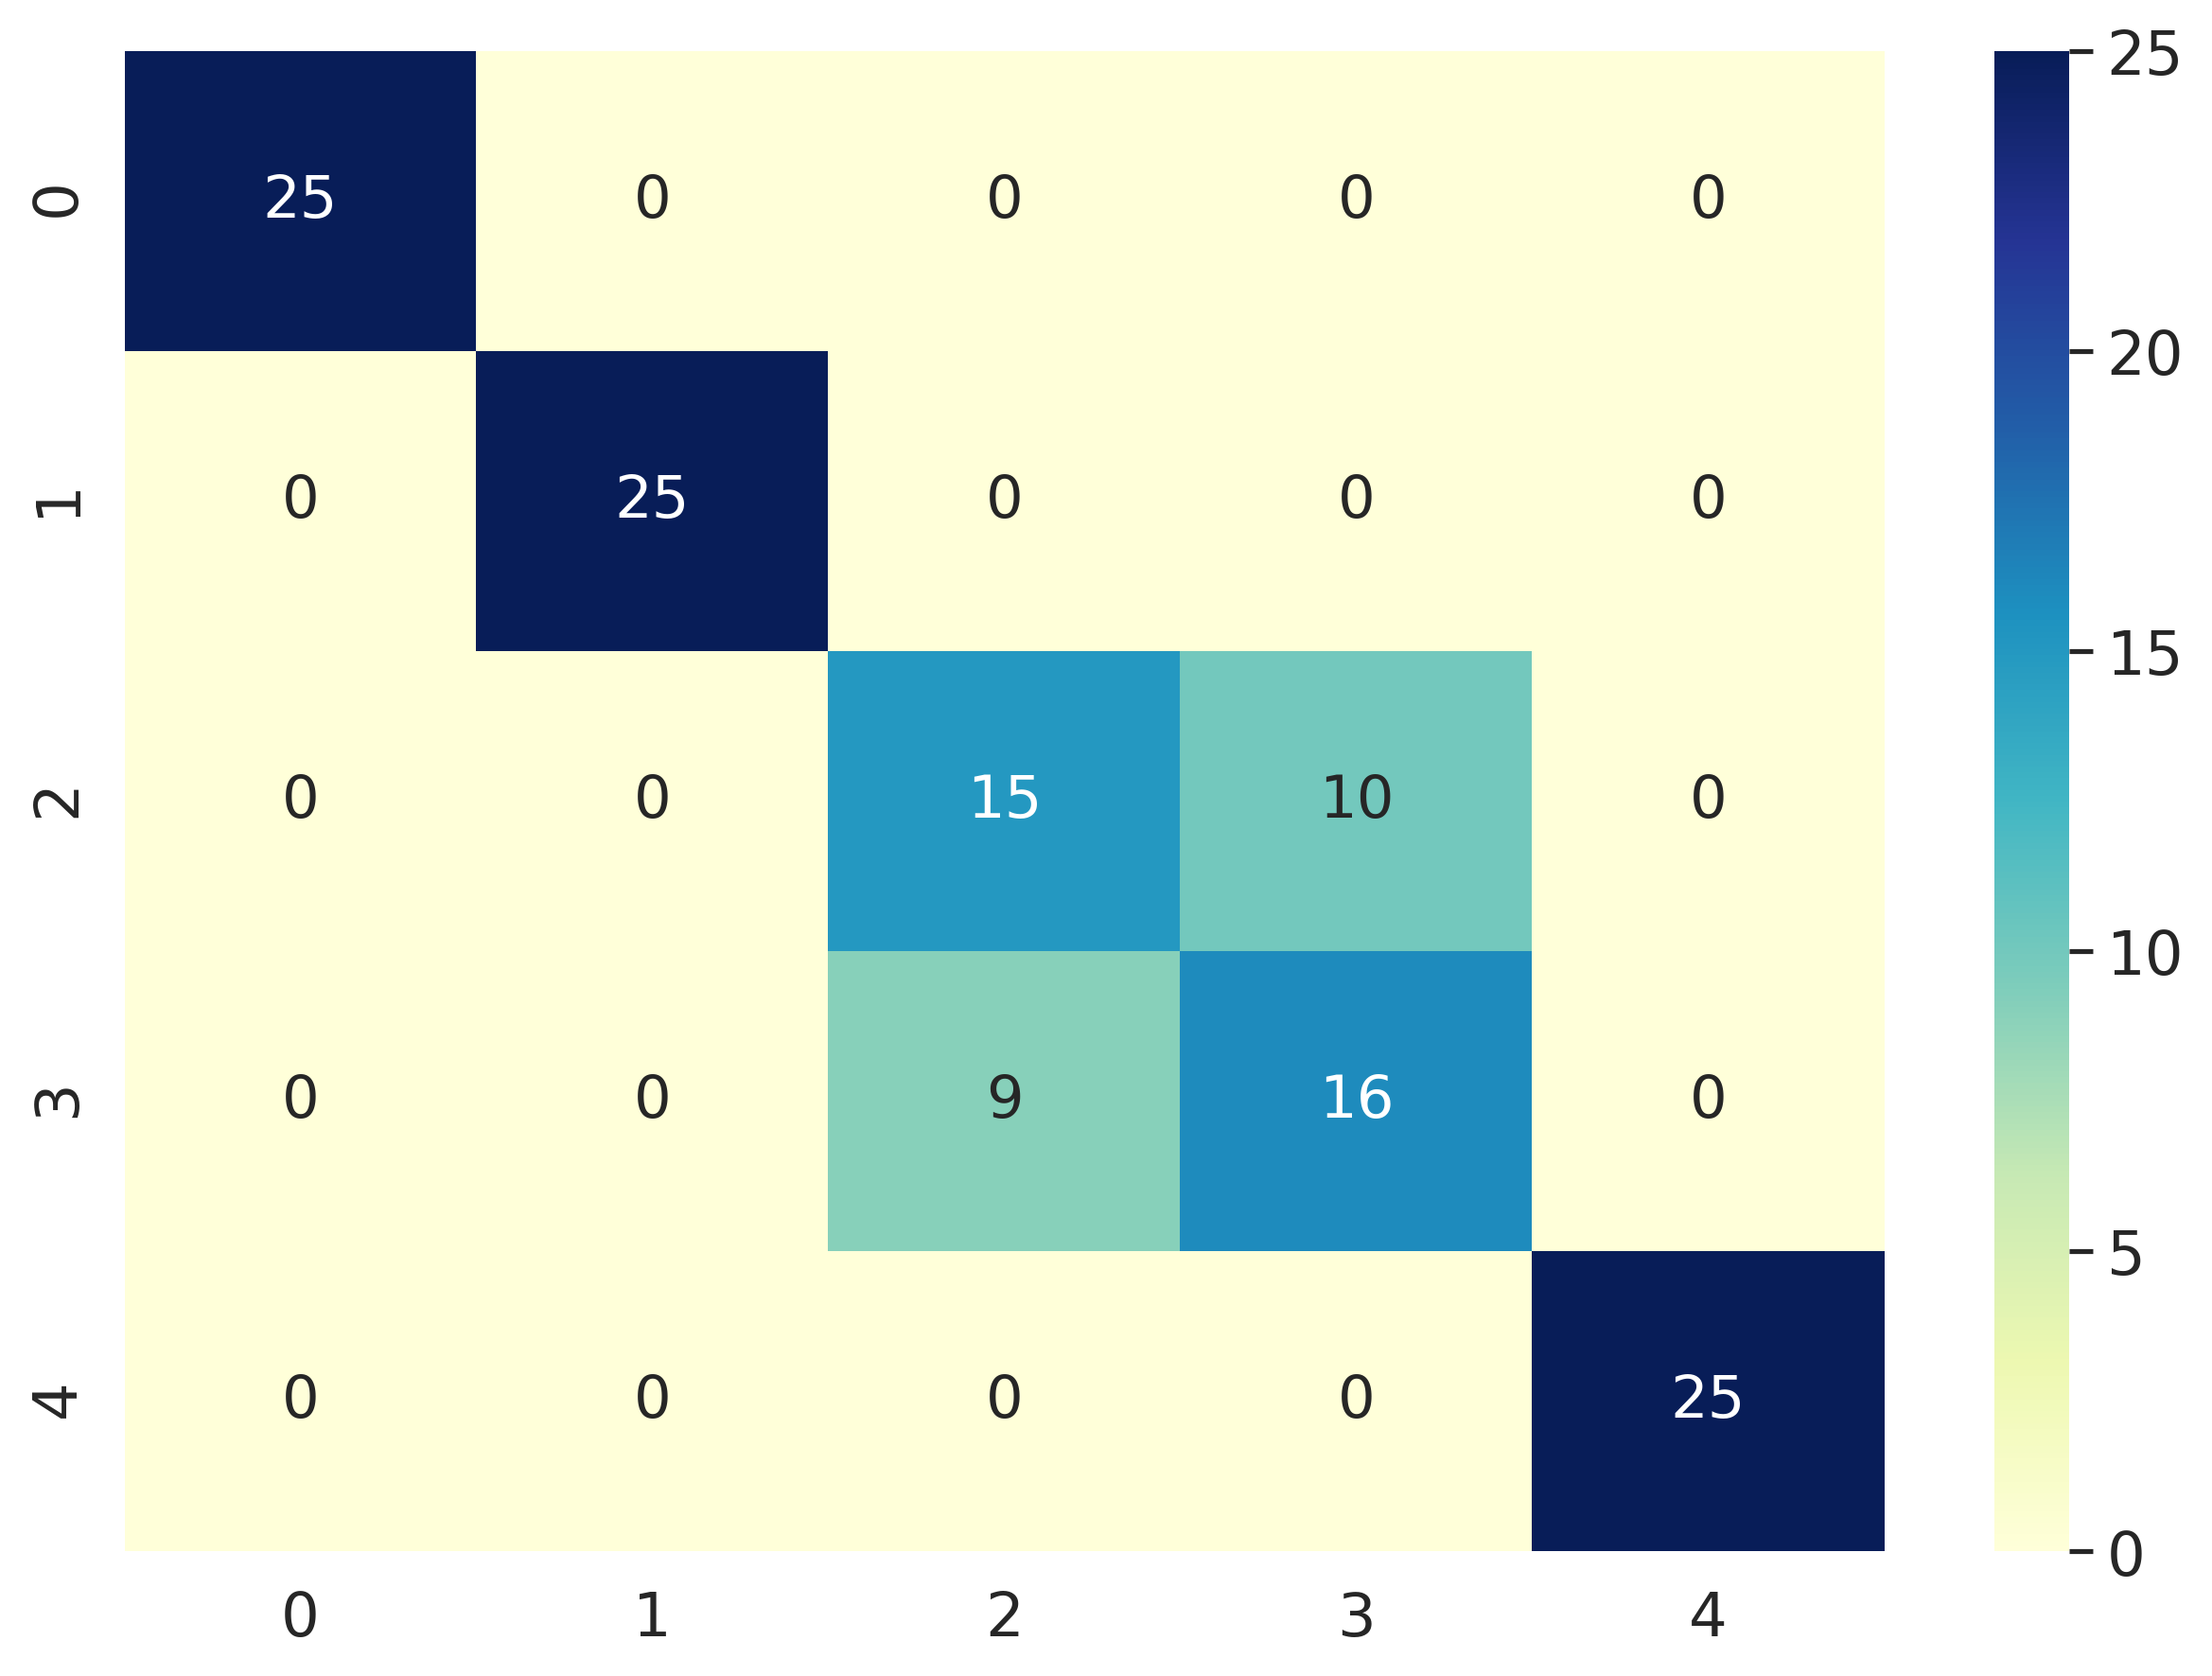

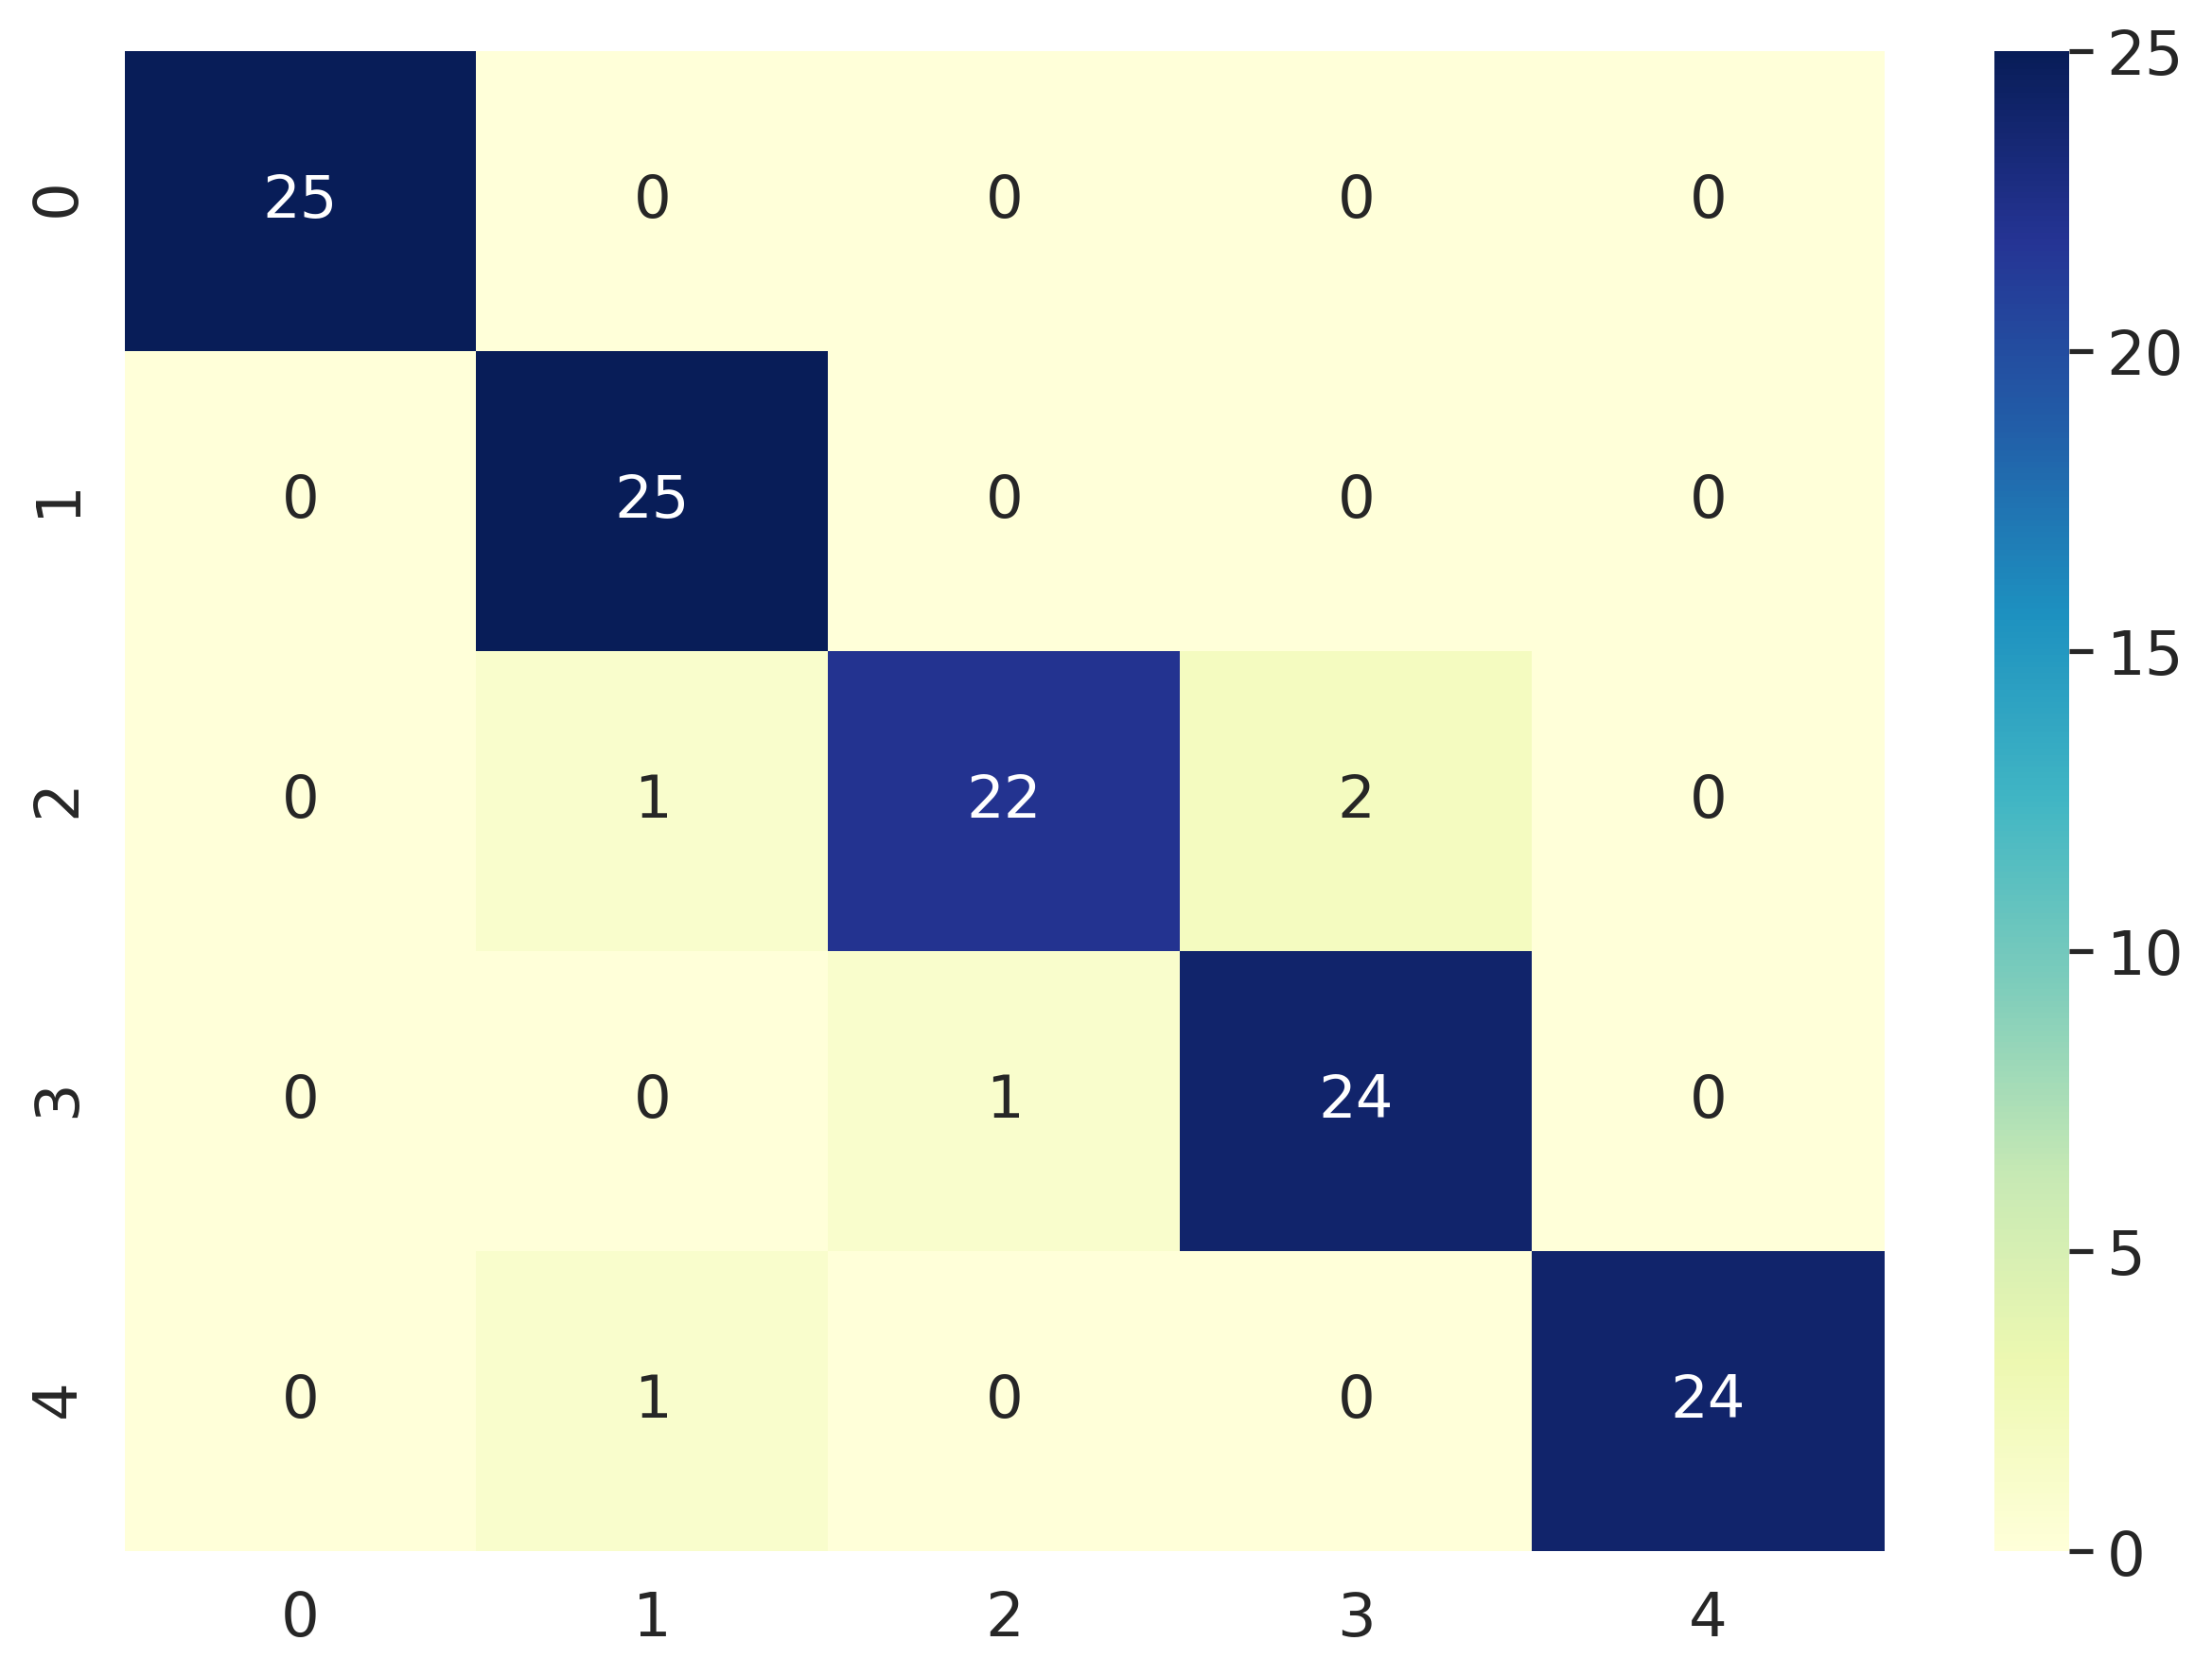

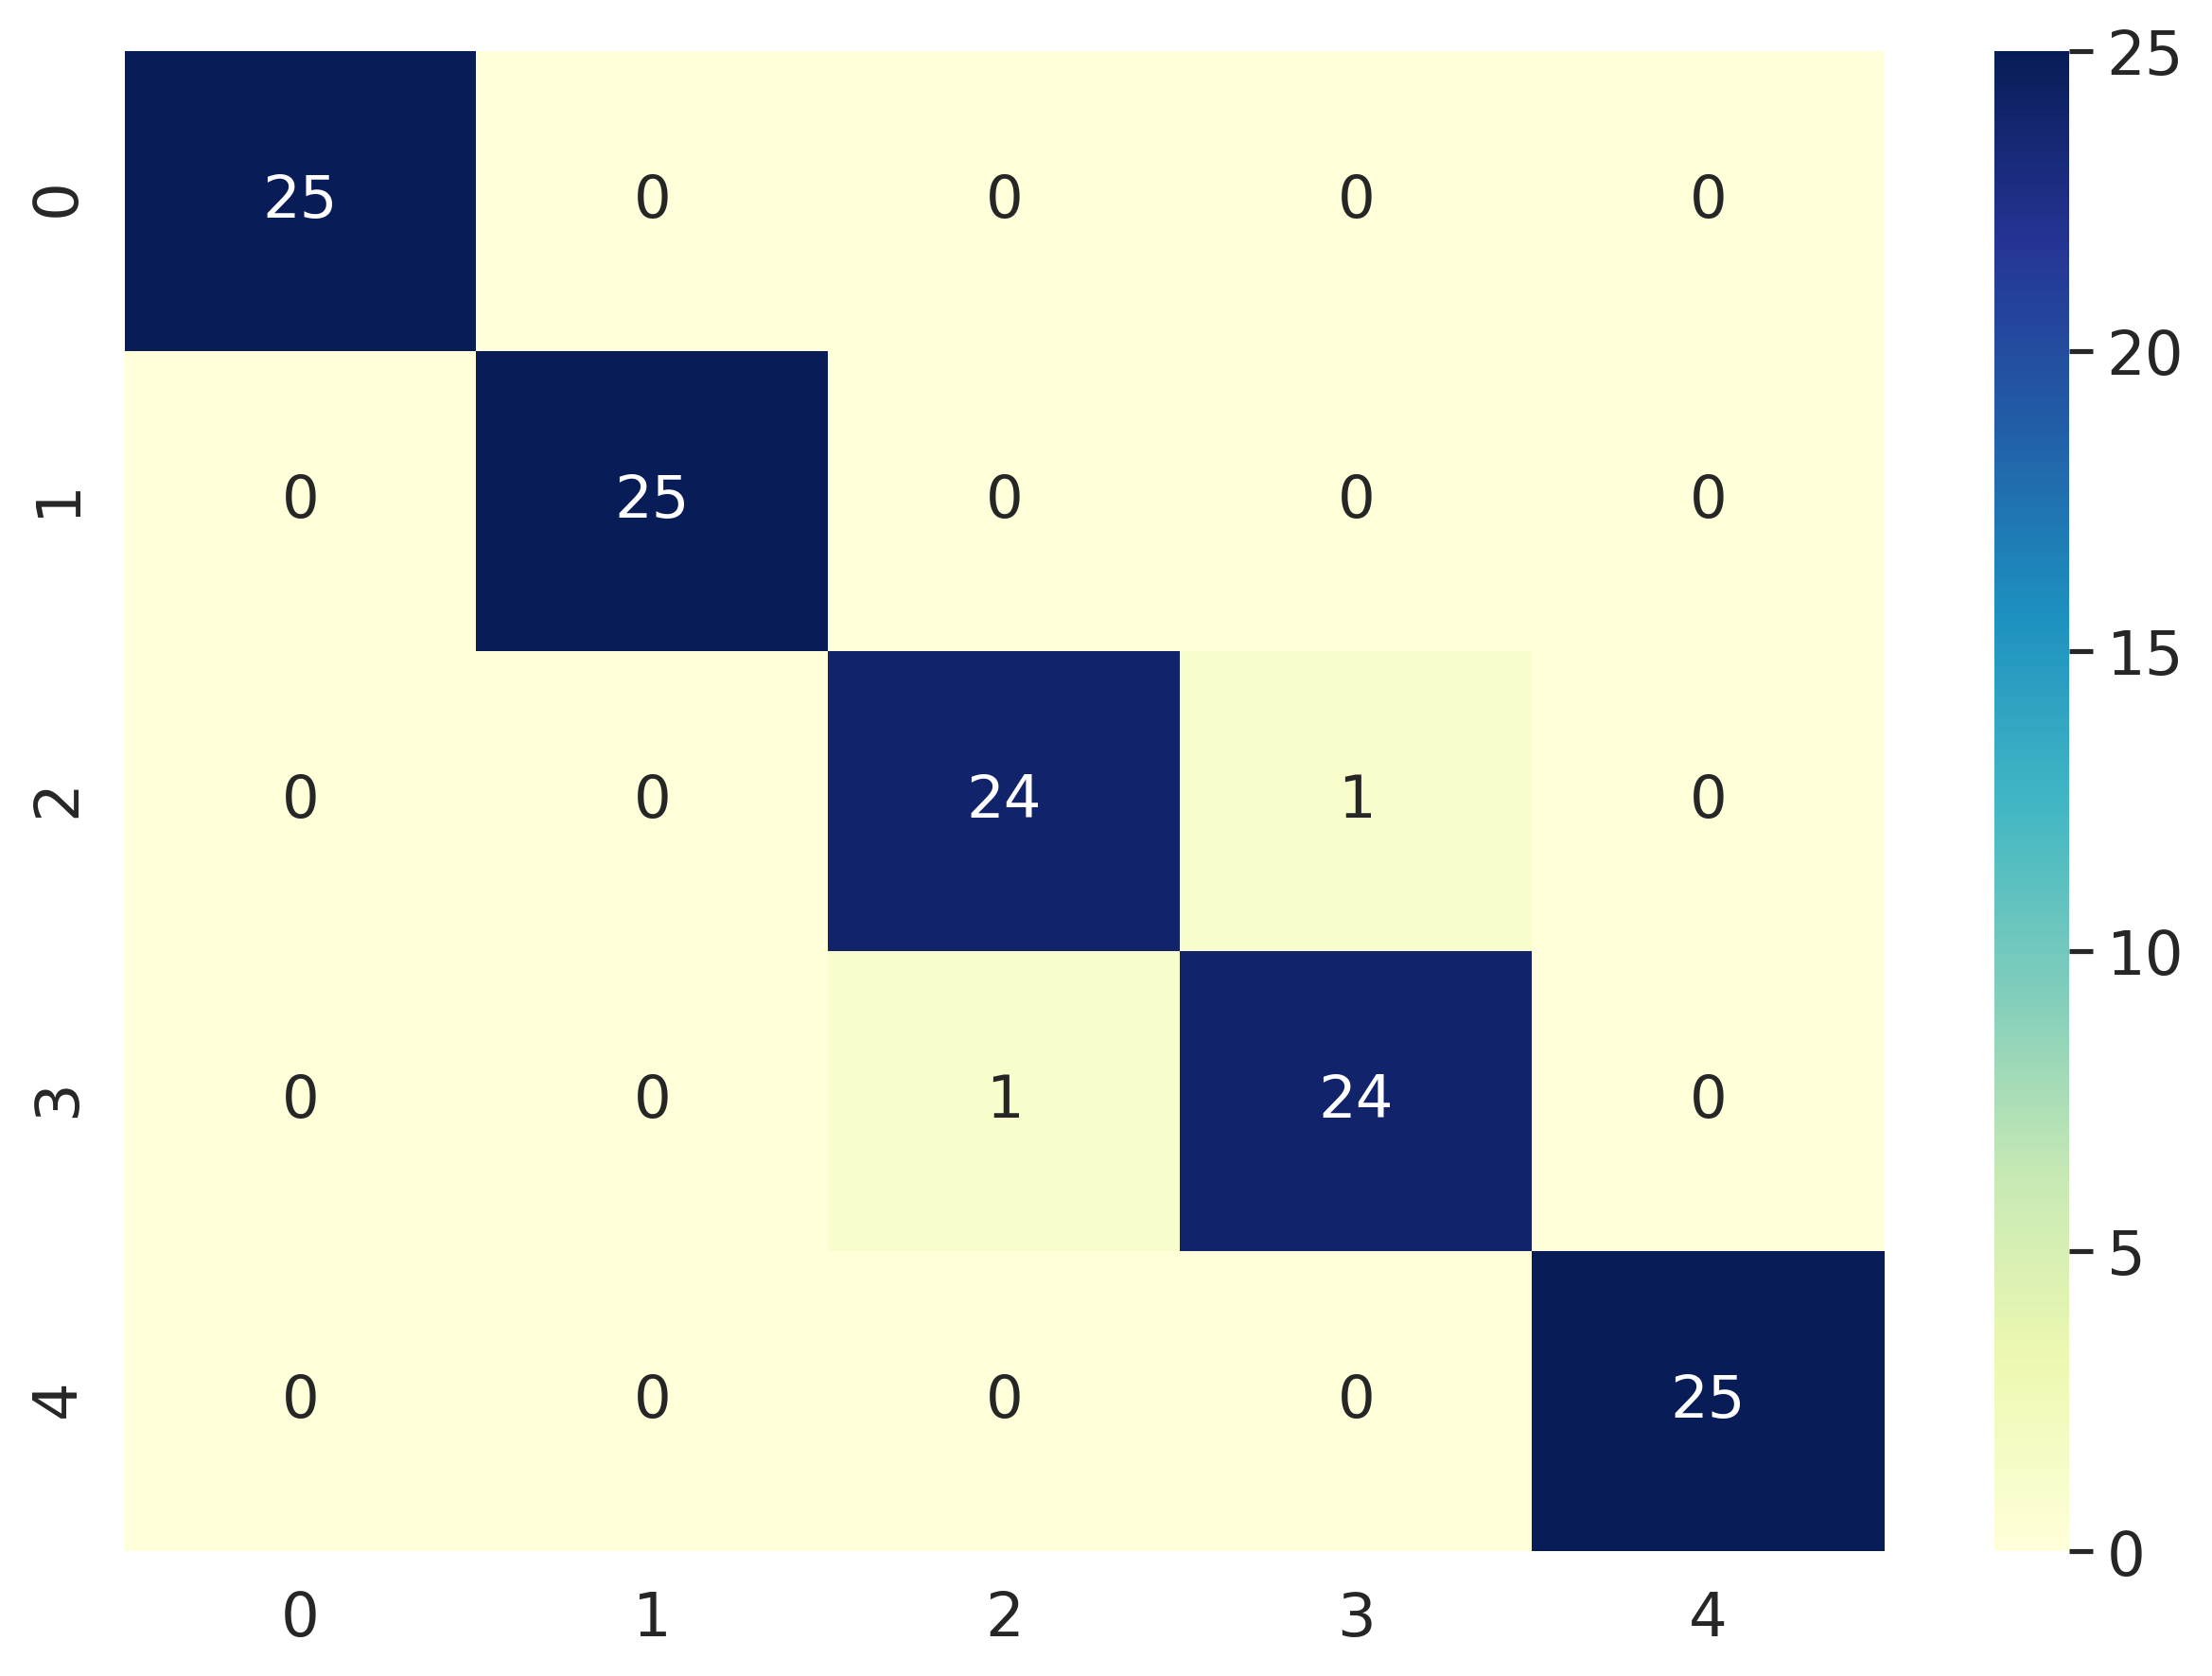

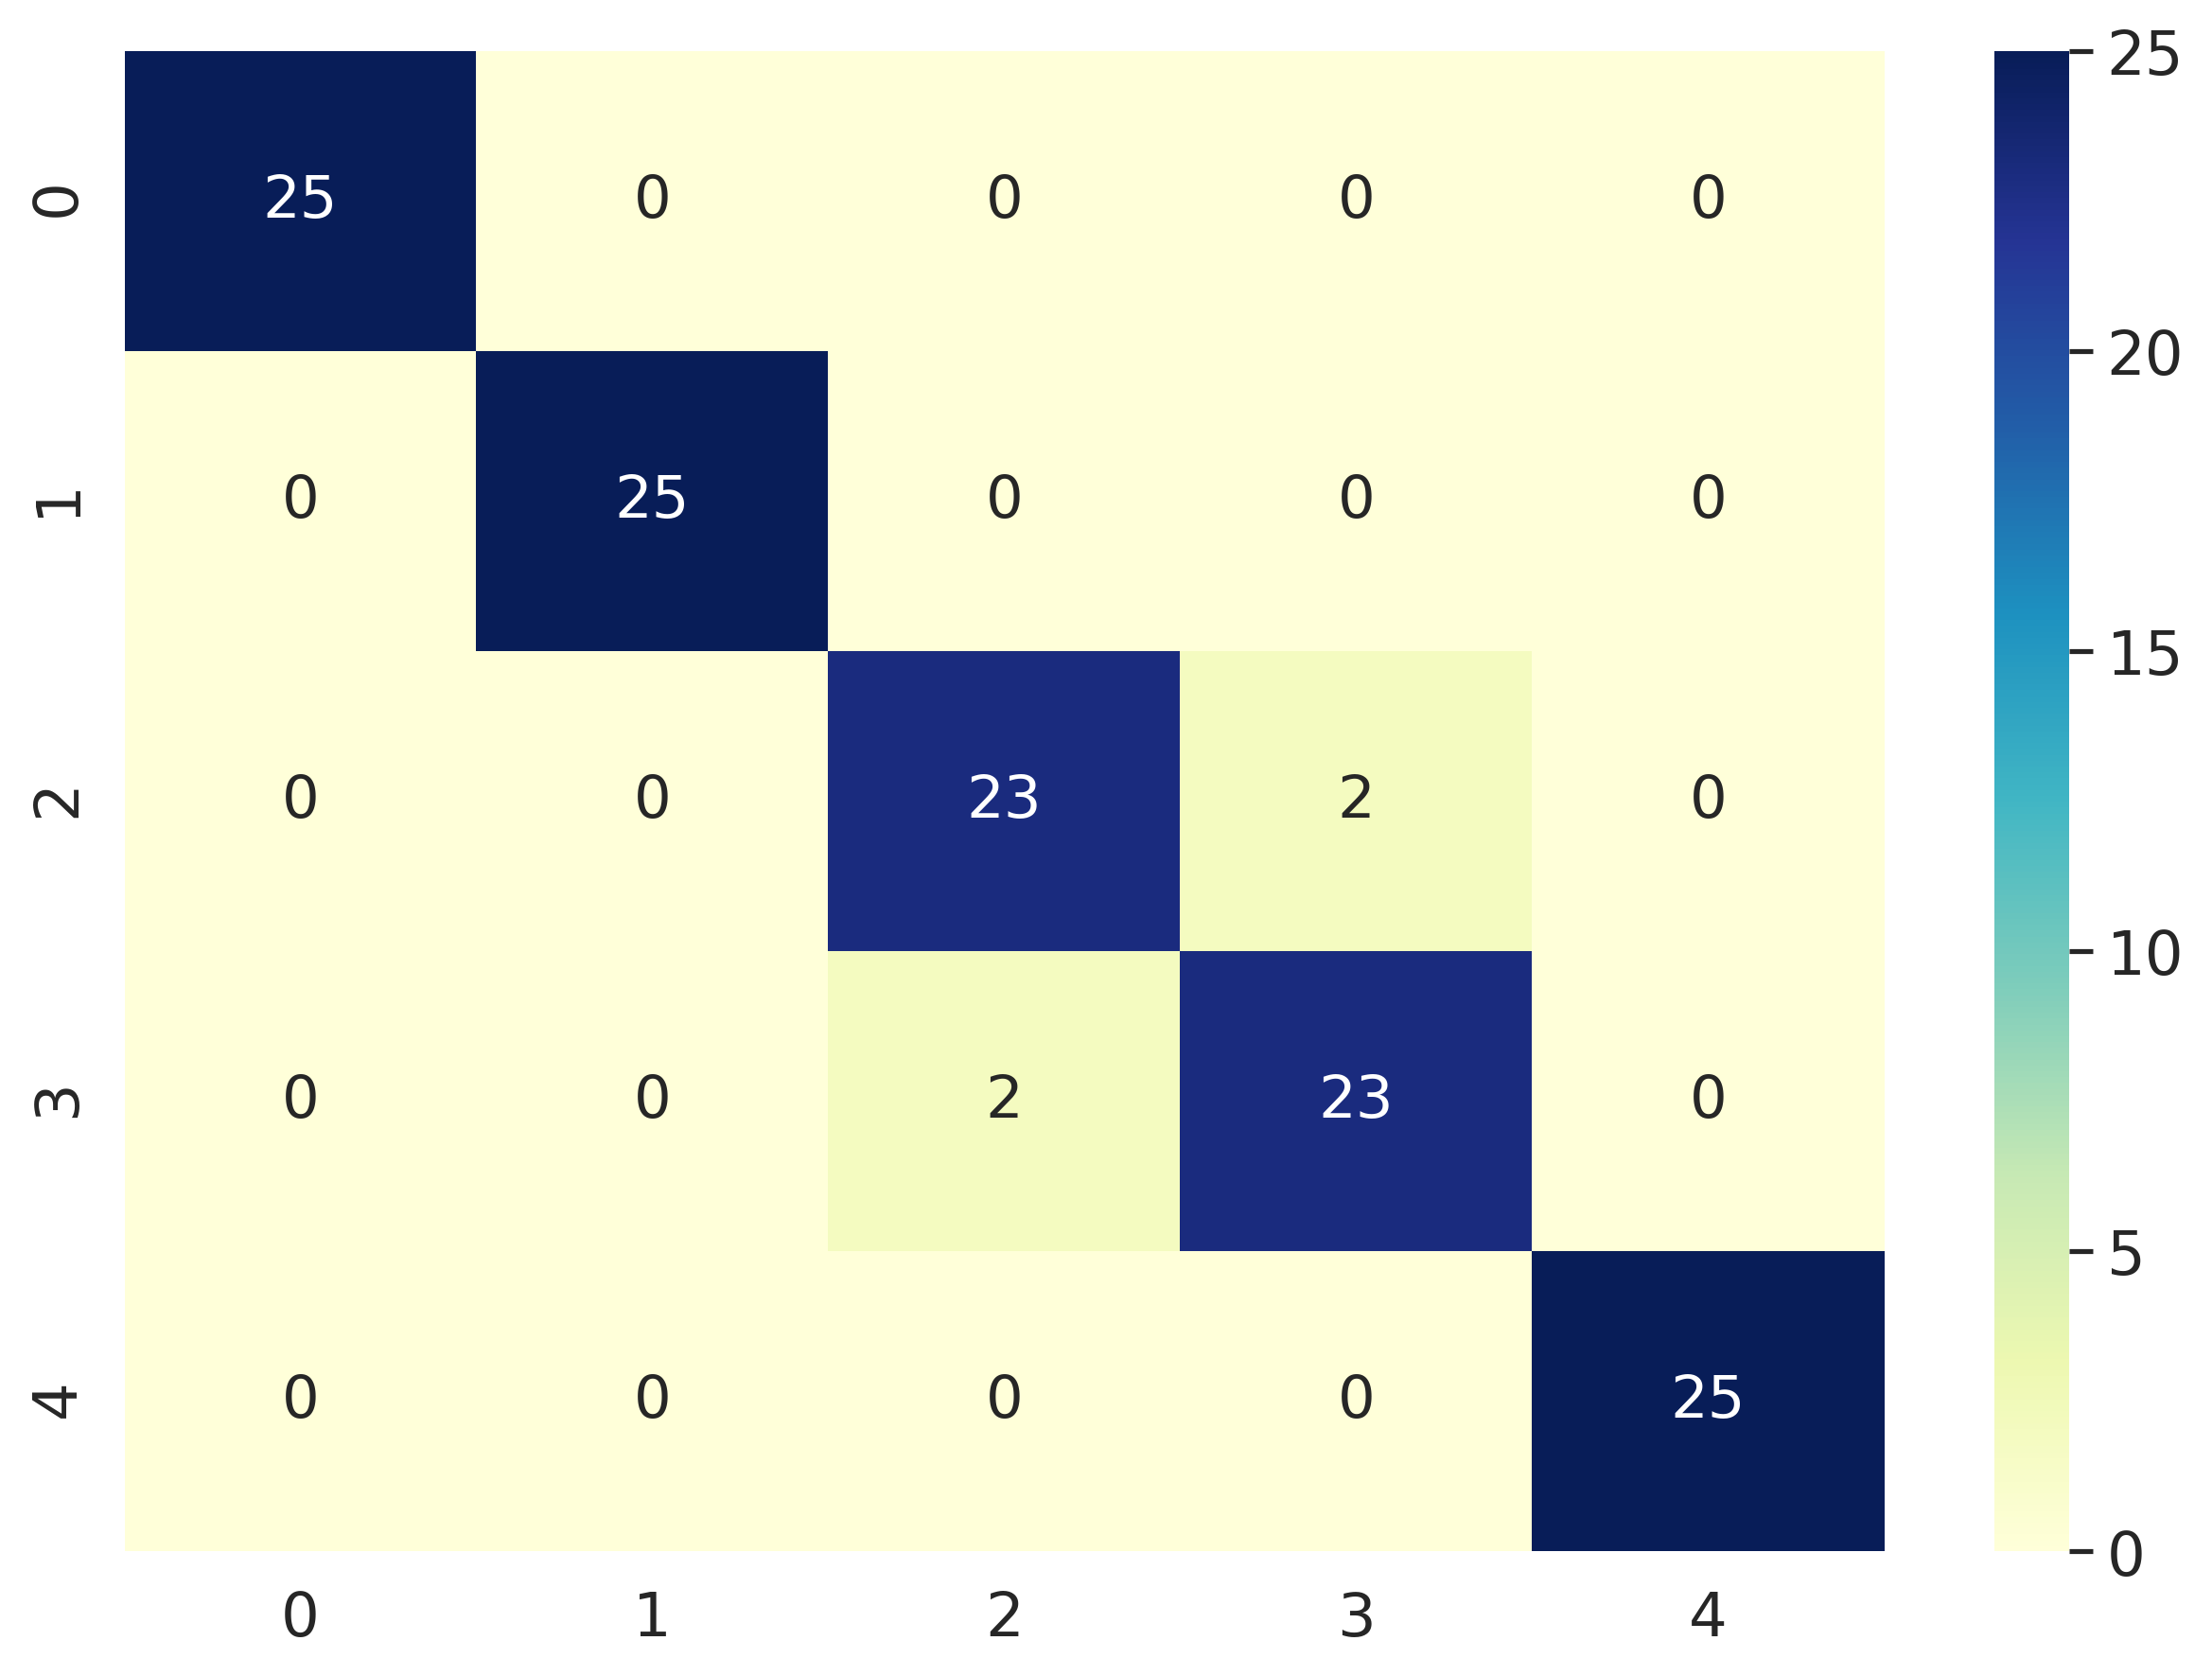

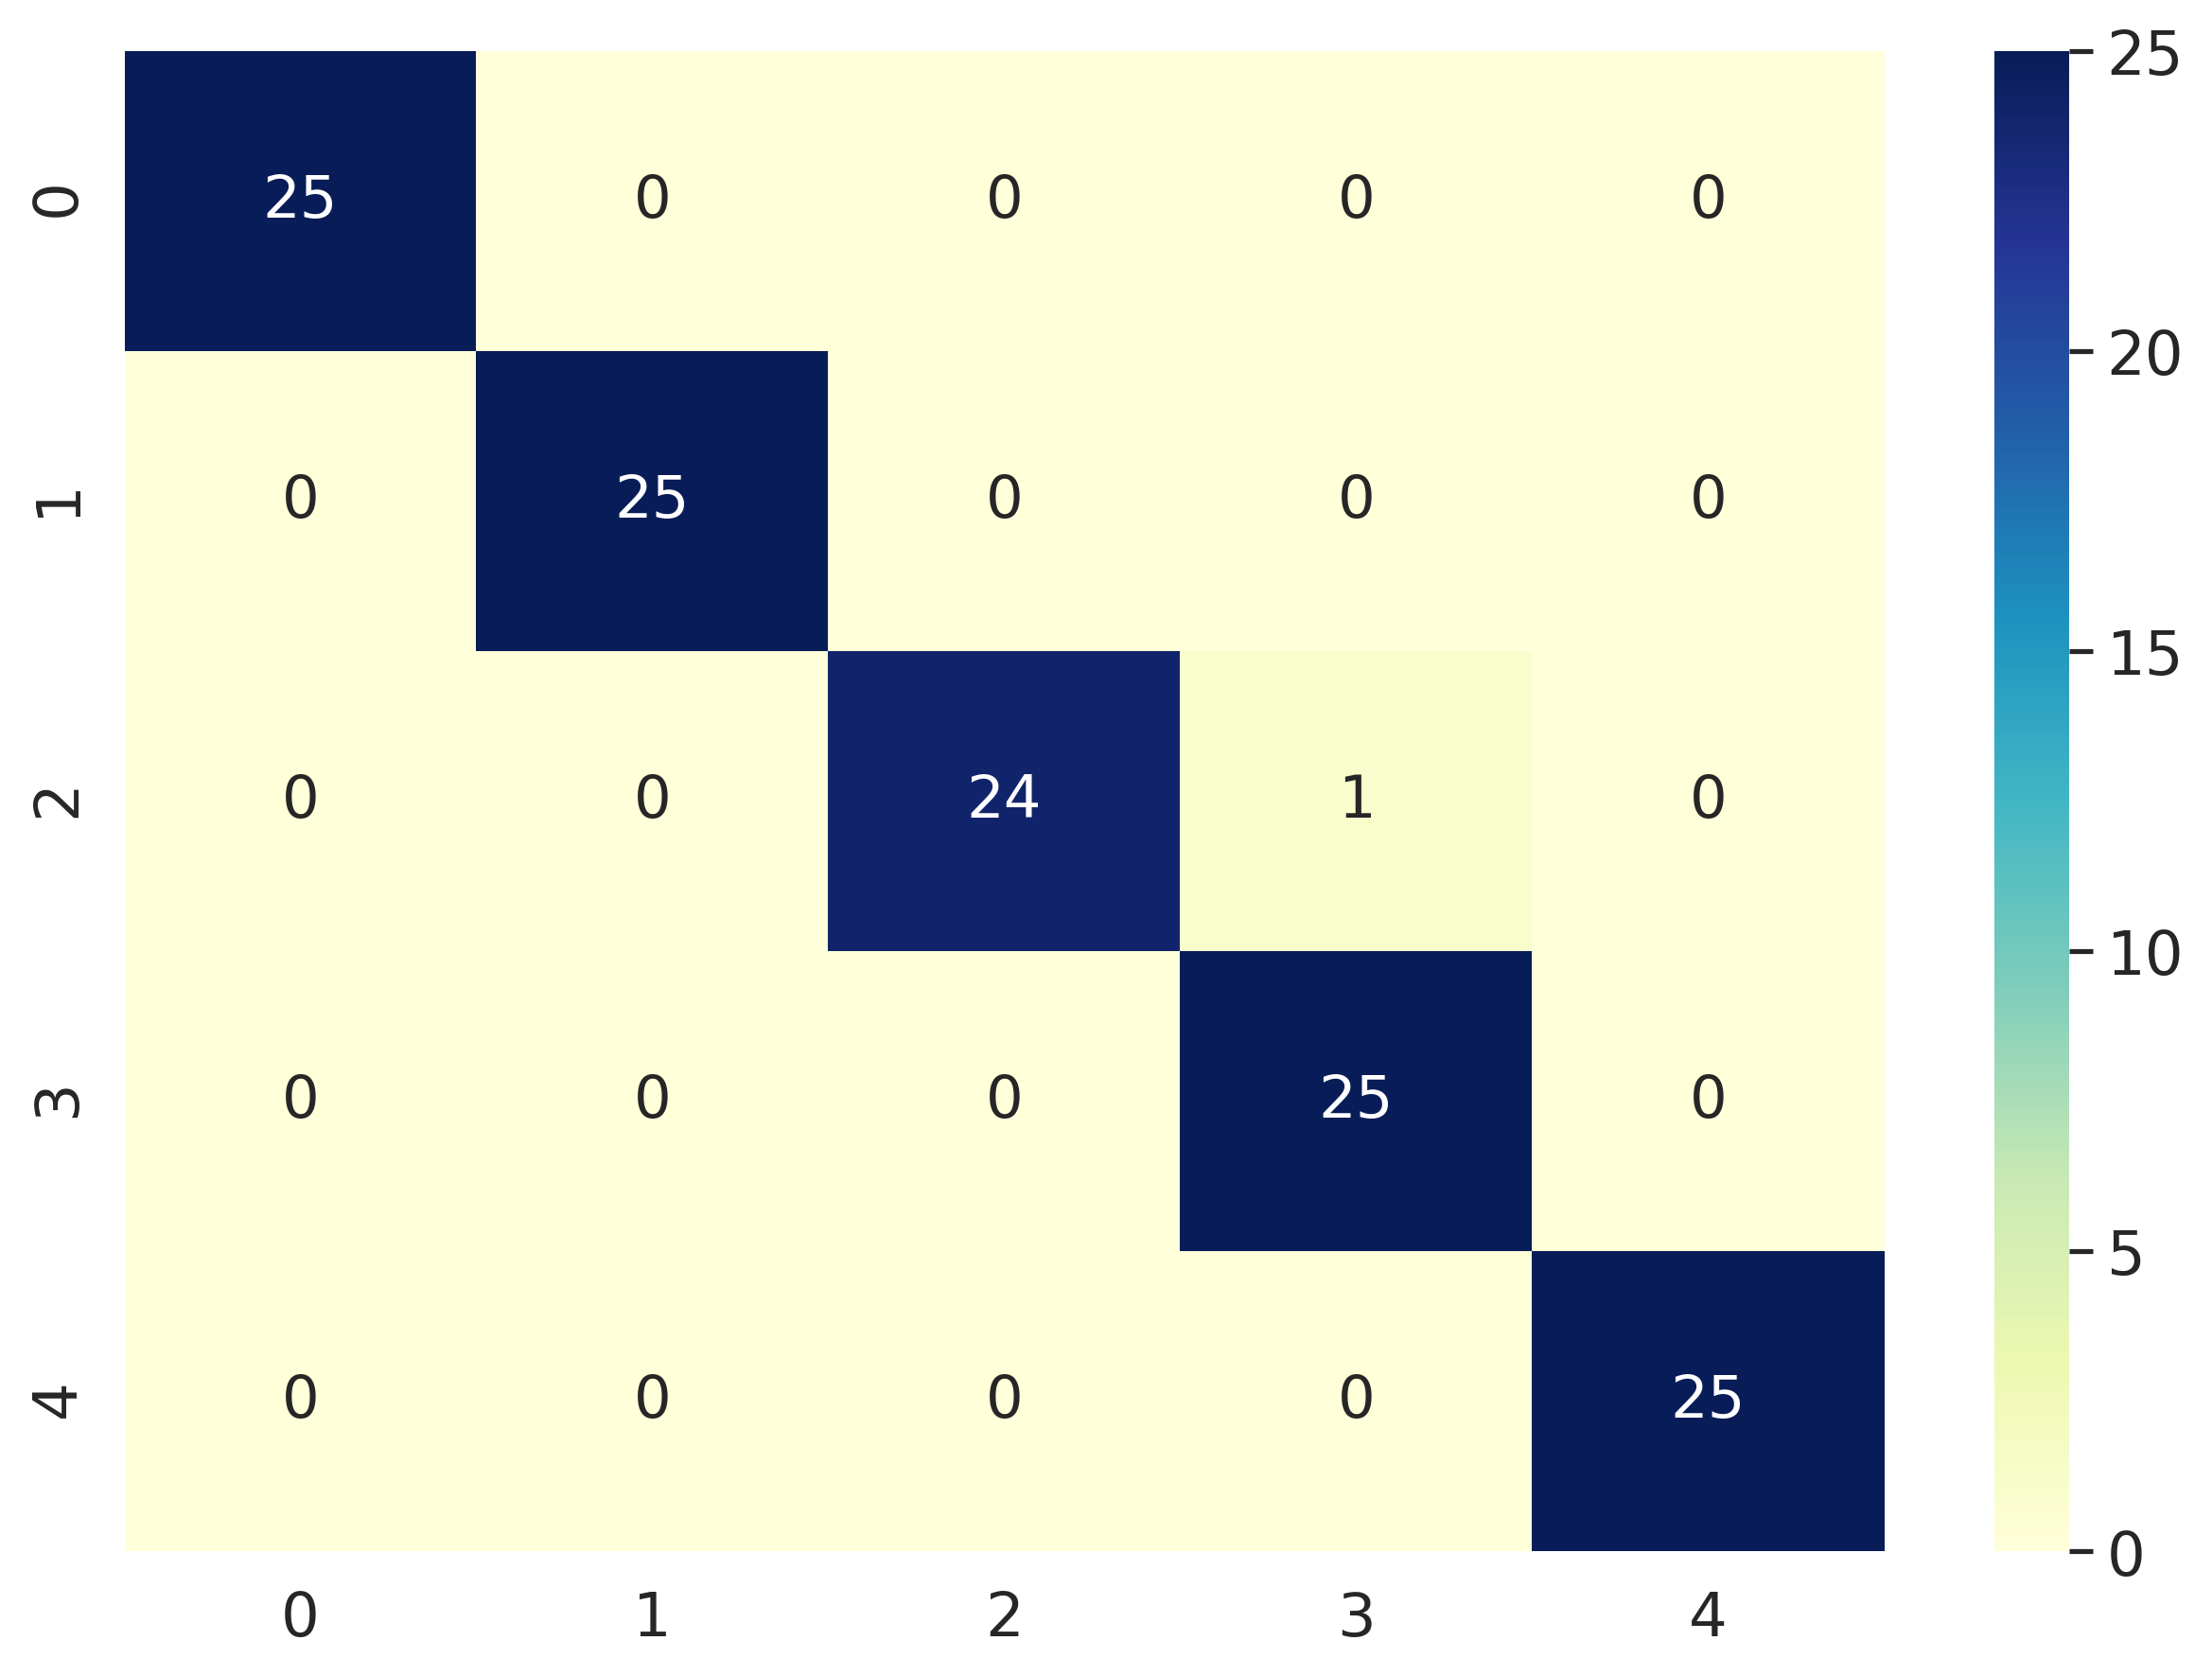

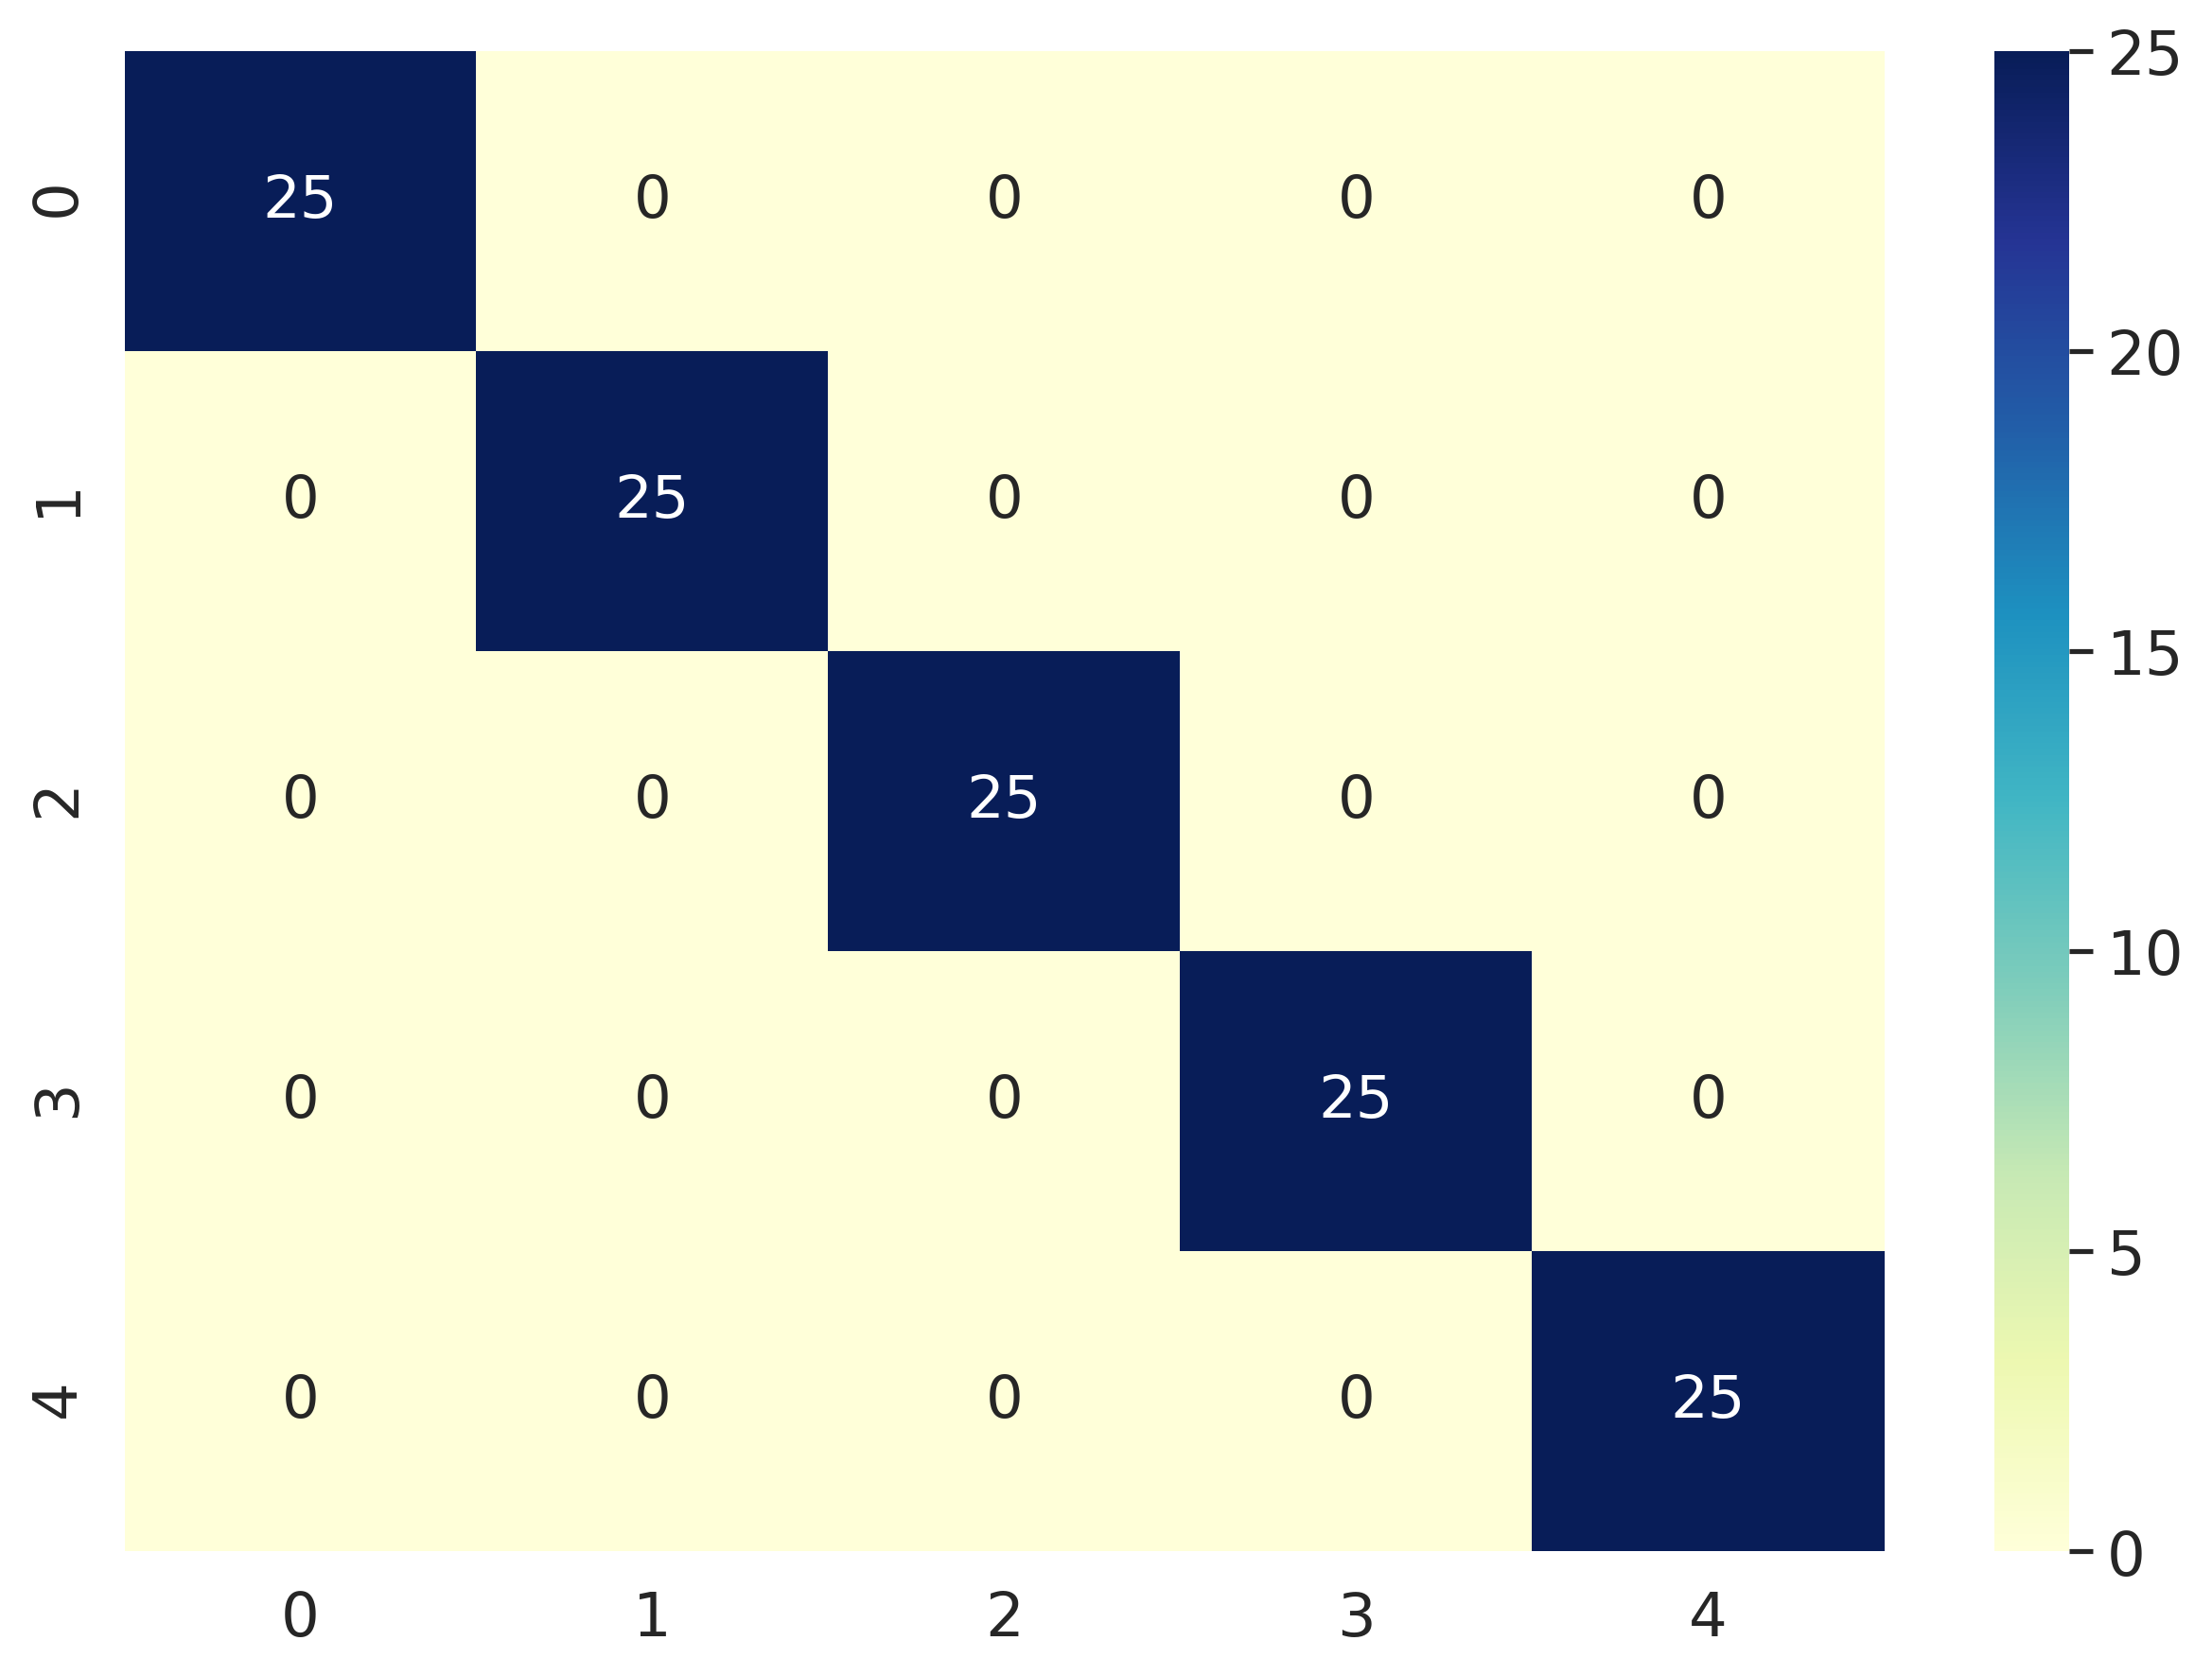

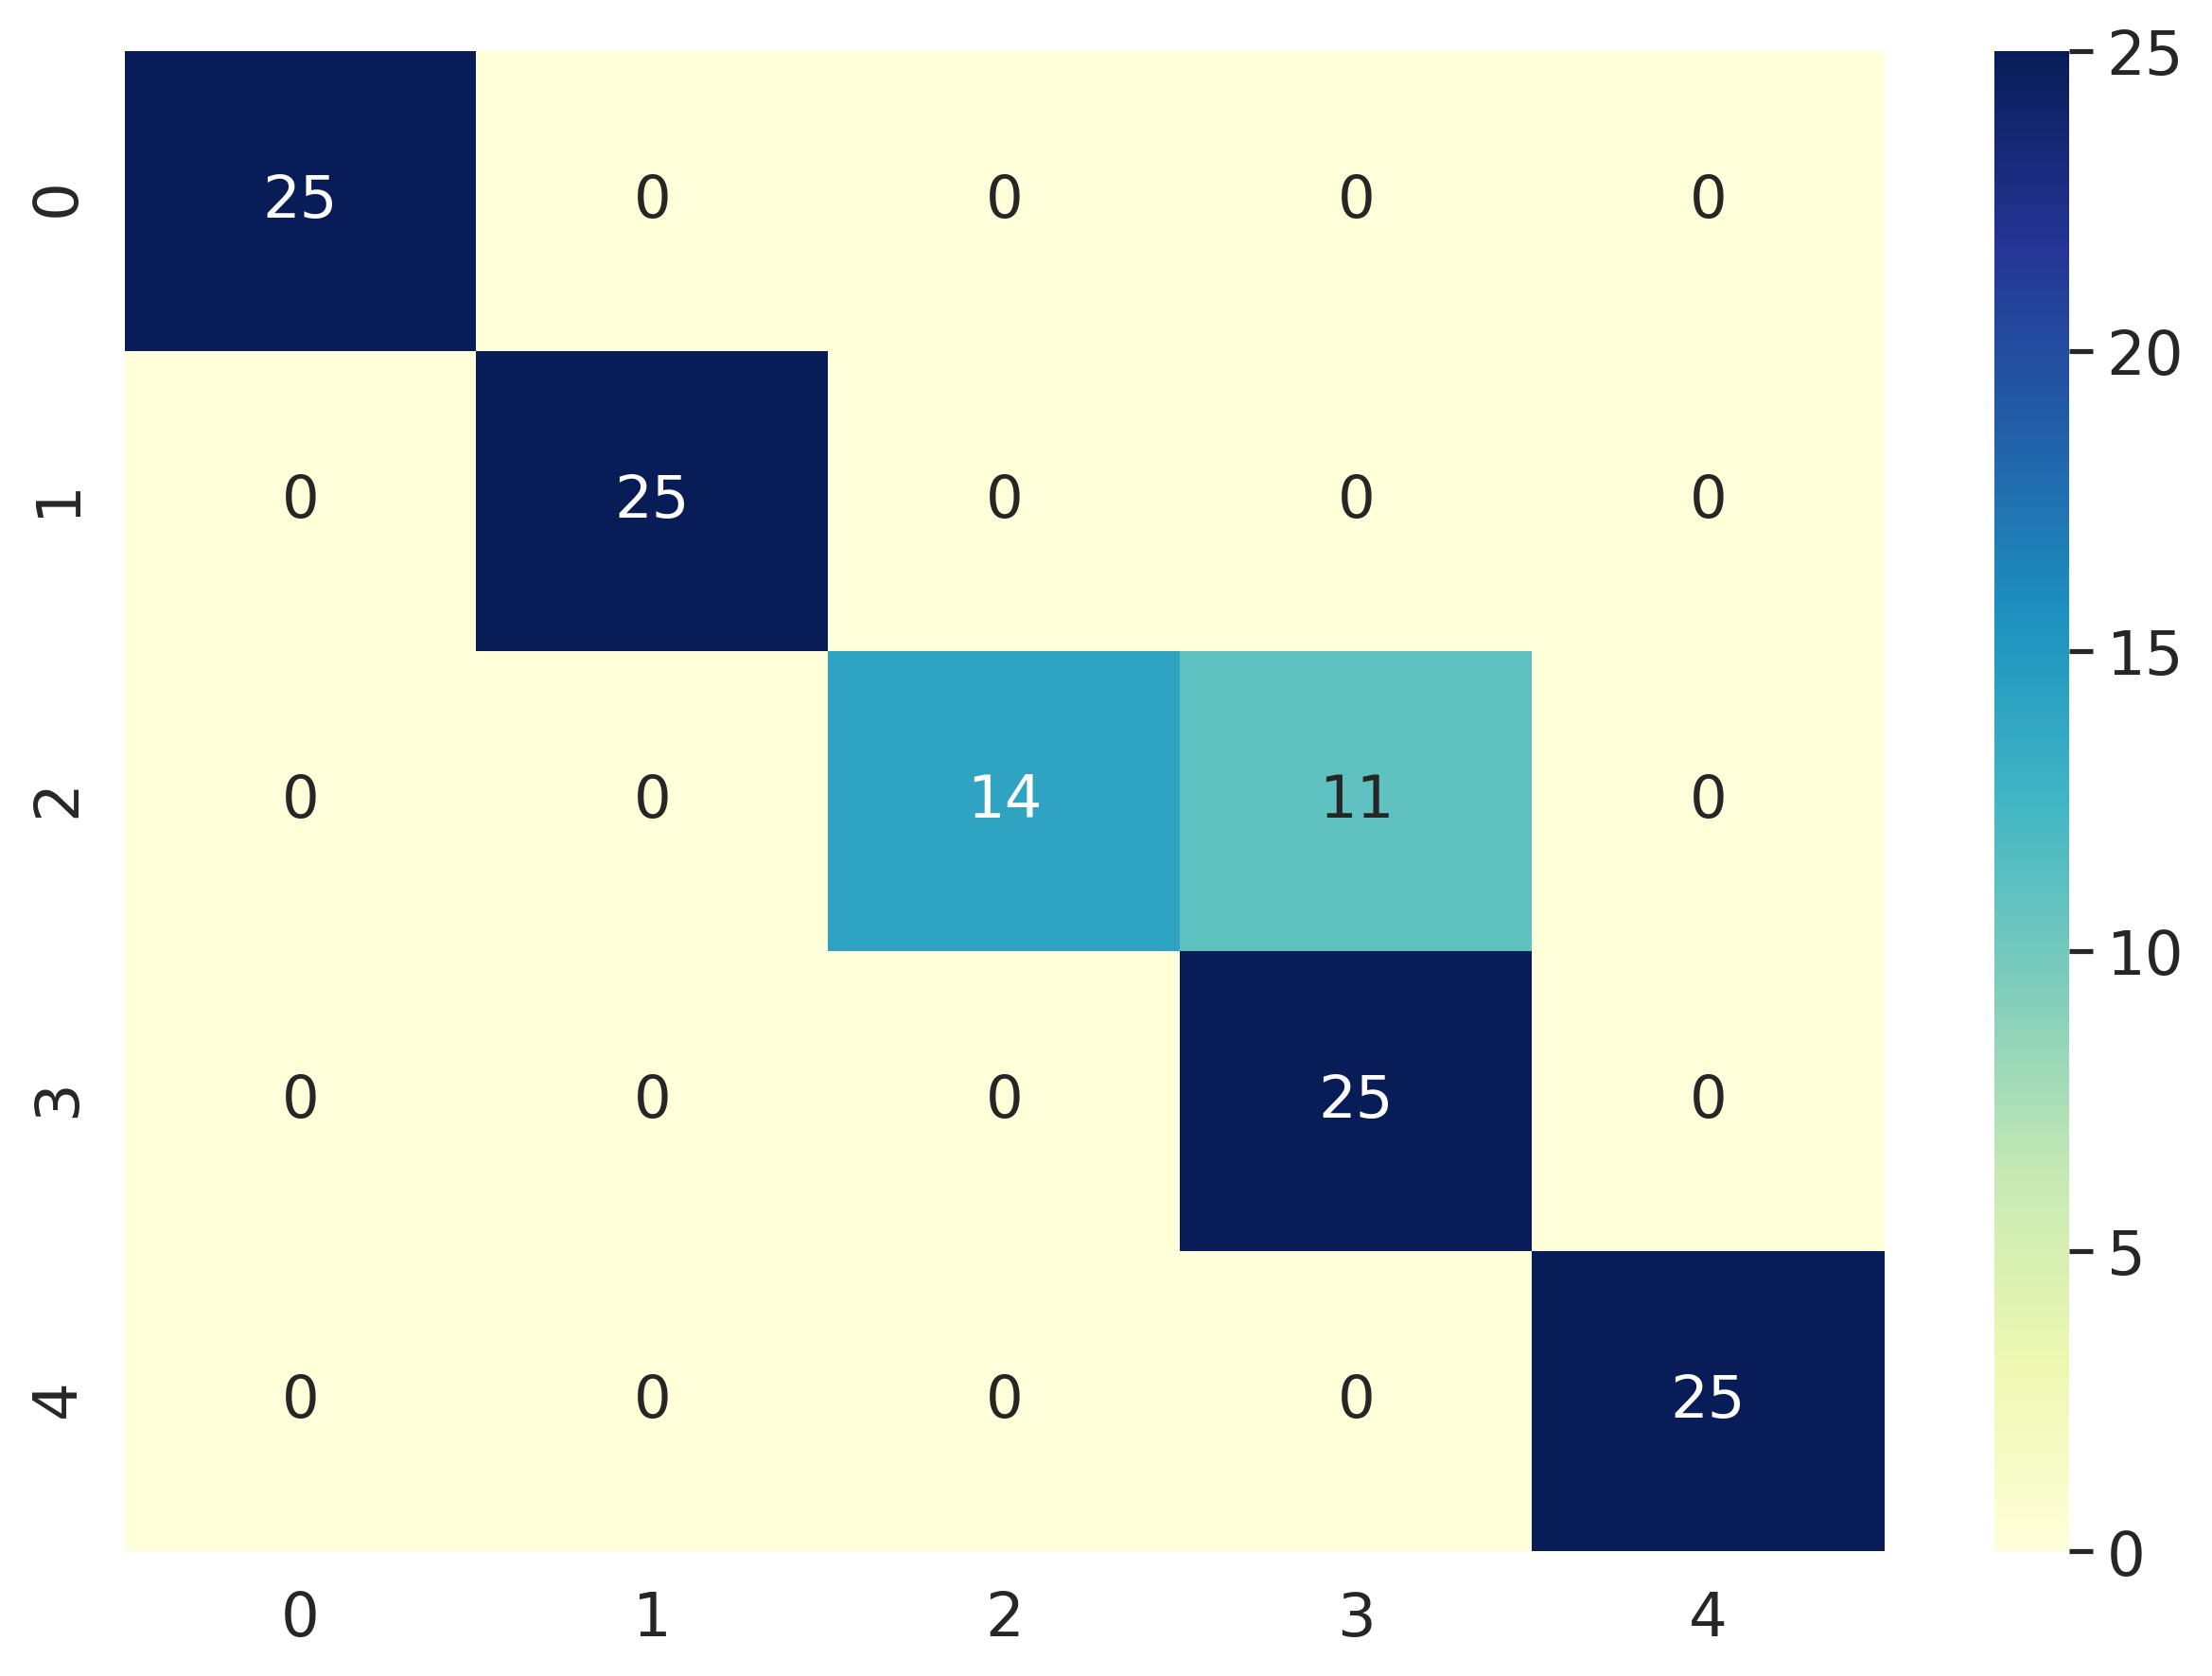

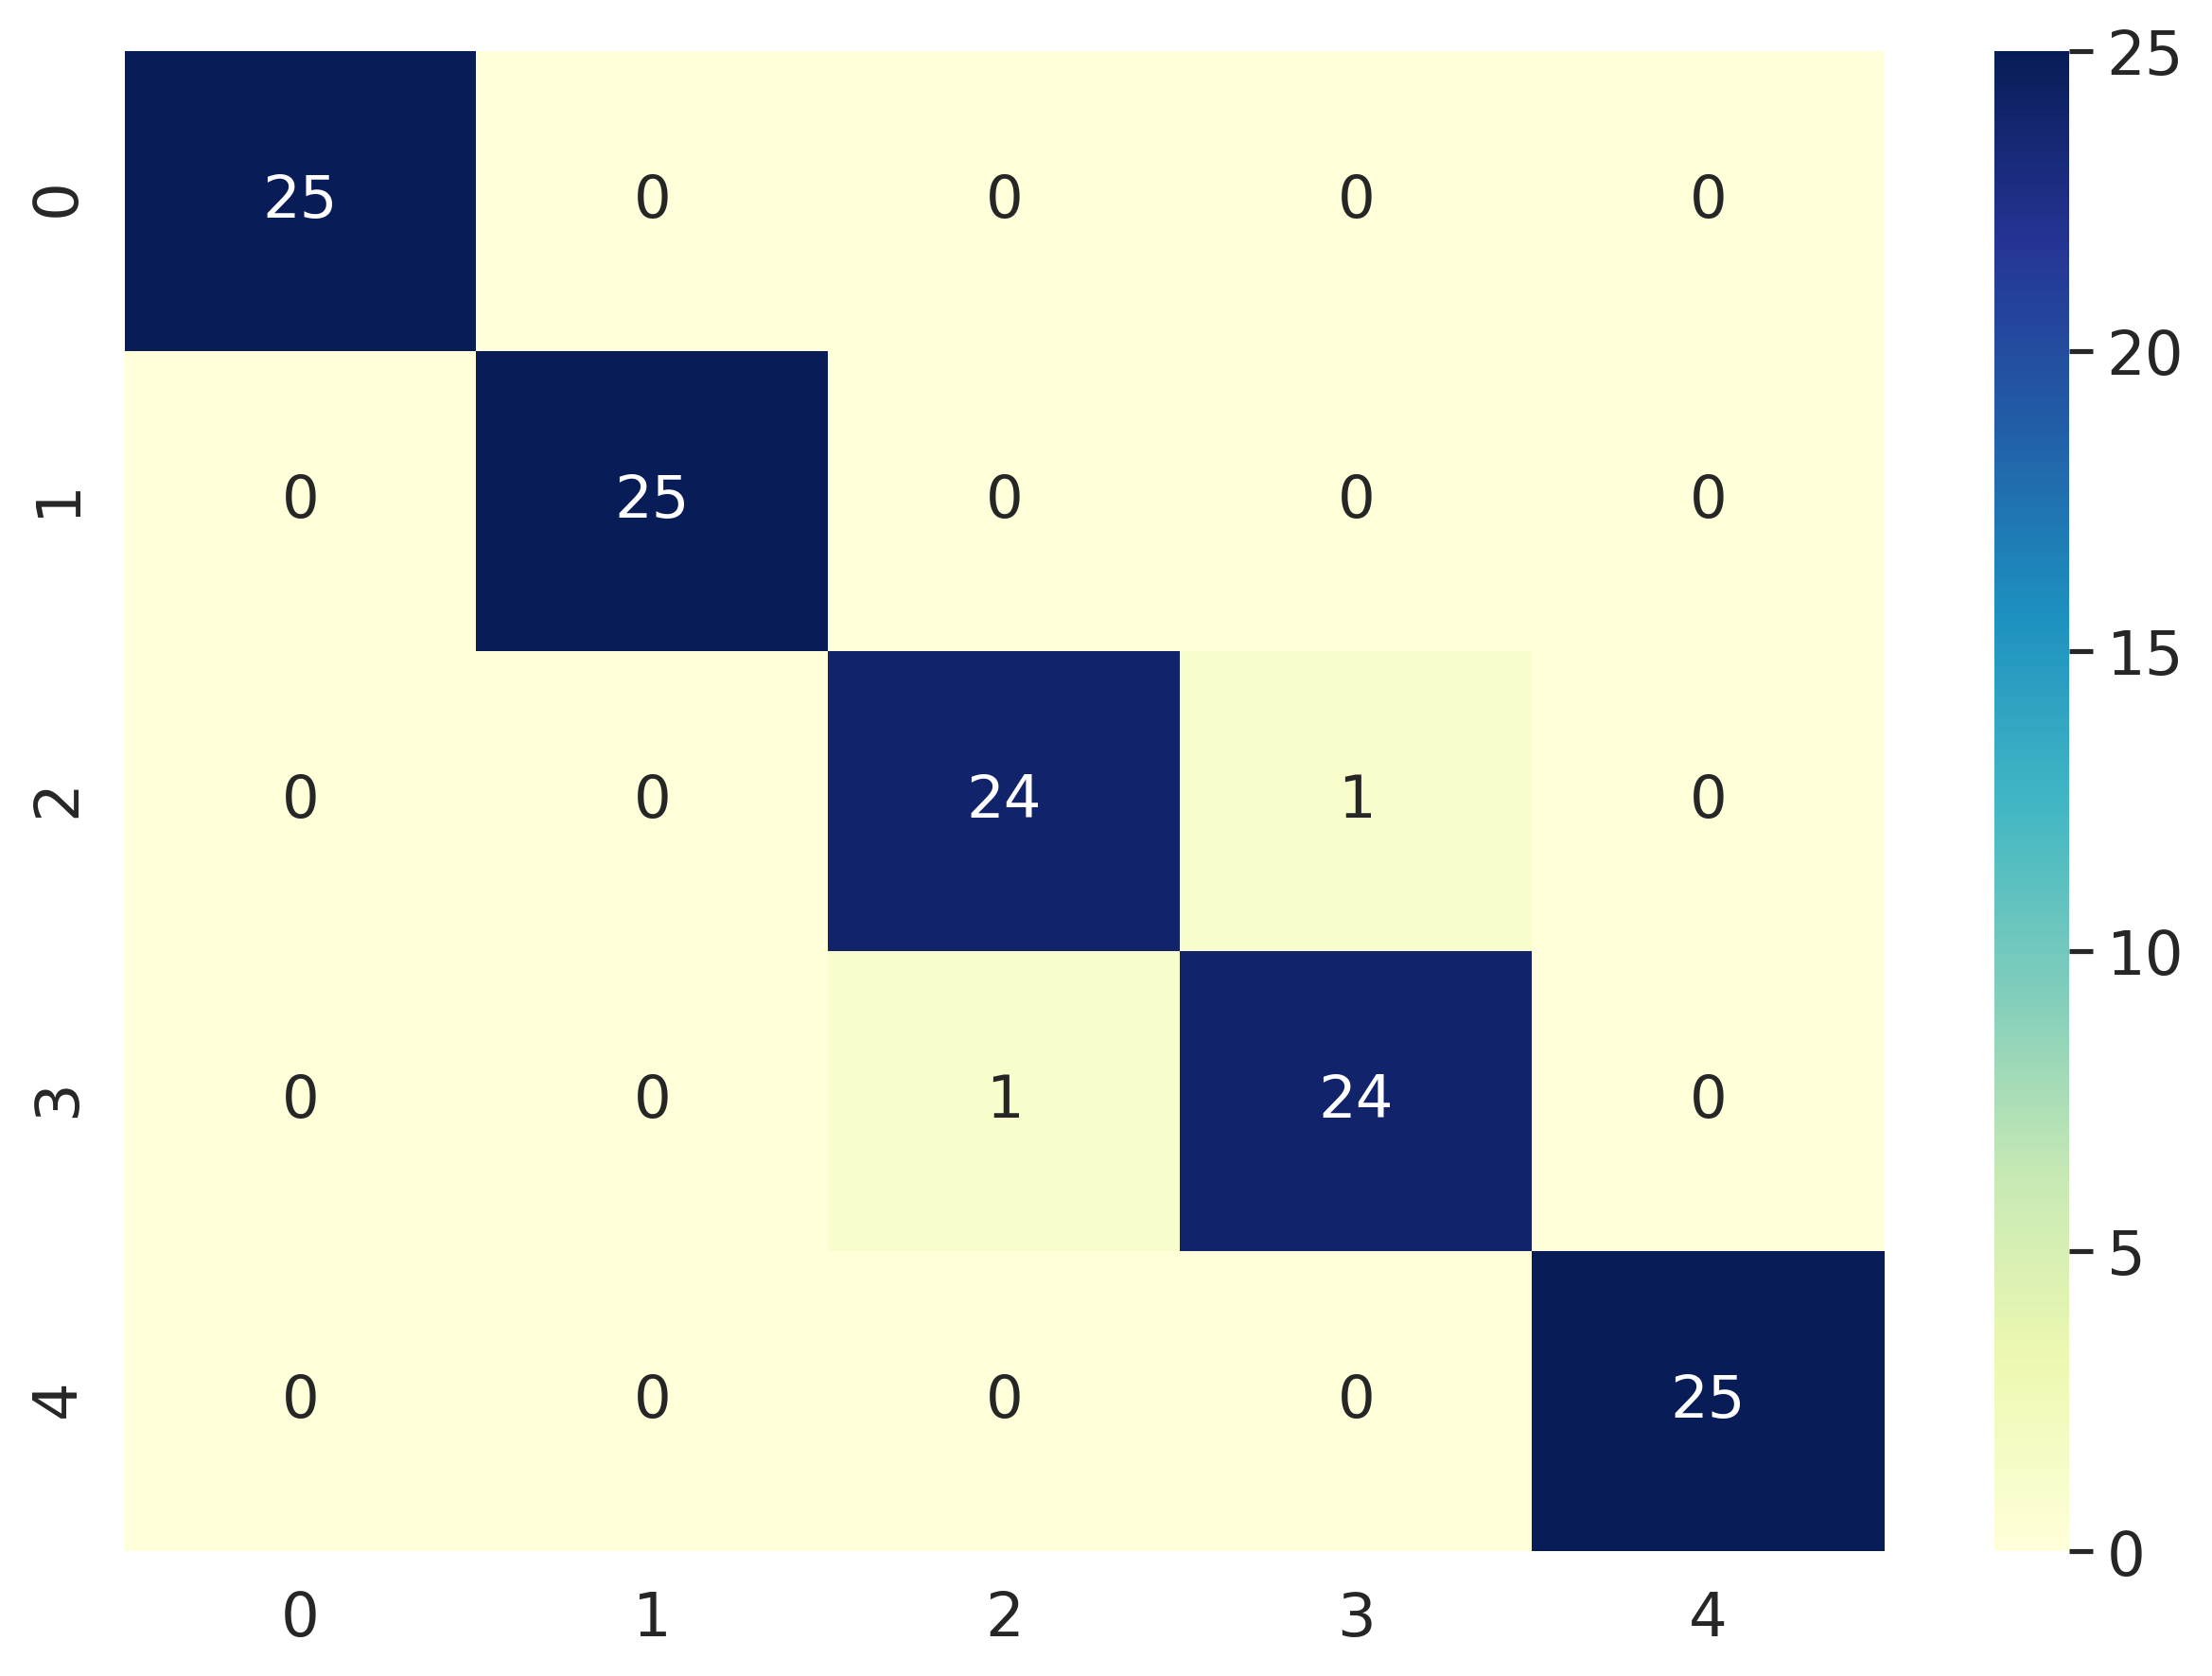

In [10]:
if cmx_plot:
    for dataset in datasets_name_list:
        for classifier in classifiers_name_list:
            plt.figure(figsize = (10,7), dpi=300)

            plot_csv = pd.read_csv(path.join(outpath, dataset, classifier+'_cmx.csv'), sep=',', index_col=0)

            sn.set(font_scale=1.4) # for label size
            sn.heatmap(plot_csv, annot=True, annot_kws={"size": 15}, fmt="d", cmap="YlGnBu") # font size


            plt.savefig(path.join(outpath, dataset+'_'+classifier+'_CMX_plot.png'))